# Introduction

본 문서는 아래 문서의 2번째 버전입니다.

https://github.com/Jooong/Deep-Learning-Study/blob/master/GAN/GAN-Keras-MNIST.ipynb

참고한(수준을 넘어서 거의 가져다 쓴 수준인) 코드는 아래 링크에서 확인할 수 있습니다.

https://github.com/Zackory/Keras-MNIST-GAN/blob/master/mnist_gan.py

version 1에서의 문제점은 (1) generate 되는 이미지들이 모두 숫자 1의 이미지였다는 점, (2) d_loss와 g_loss가 의도대로 수렴하지 않는다는 점

두 가지였는데요, 원 코드와 비교를 해보고 다른점을 두 가지 확인하였습니다.


(1) 실제 이미지에 대한 정규화 작업이 빠져있었습니다.

(2) discriminator를 학습시킬 때 label을 smoothing하는 작업이 빠져있었습니다.

예측되는 가설은, 

(1) 초기에 정규화를 시켜주지 않아 loss가 수렴하지 않았을 것이다.

(2) one-sided-labeling을 해주지 않아 Discriminator를 쉽게 속일 만한 이미지만을 생성했을 수 있다. [one-sided-labeling 참고 링크](https://github.com/YBIGTA/Deep_learning/blob/master/GAN/2017-08-02-tips-from-goodfellow.md)


두 가지였습니다.

---

나중에 확인하게 된 사실인데, minibatch 세팅을 잘못 했습니다.. 

batch-size를 100으로 세팅했는데, 전체 데이터셋에서 인덱스를 하나씩만 미루면서 99개의 데이터가 겹치는 형식으로 세팅되어 있었습니다. 

당연하게도 이 부분이 가장 크리티컬했습니다....

---

## Import needed modules

In [25]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [26]:
import pandas as pd
import cufflinks as cf
cf.go_offline()
% matplotlib inline

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [27]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializations

K.set_image_dim_ordering('th')

## Initialize some values & load MNIST data

In [98]:
# Dim of noise vector == 100 -> most of GAN implementations do so.
noiseDim = 100
examples = 16

# set sample noise to keep track of how well Generator is trained
sample_noise = np.random.normal(0, 1, size=[examples, noiseDim])
np.random.seed(1000)


# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5     # ver 1에서 빠져있던 코드입니다. normalization이 안되어있었어요.
np.random.shuffle(X_train)
X_train = X_train.reshape(60000, 784)


# make mini batches
BATCH_SIZE = 100
NUM_BATCH = X_train.shape[0] // BATCH_SIZE
X_batches = np.array([X_train[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE] for i in range(NUM_BATCH)])

# List for tracking losses
dLosses = []
gLosses = []

## Set Optimizer

In [77]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

## Build GAN

#### 0) Initializer

In [78]:
def initNormal(shape, name=None):
    return initializations.normal(shape, scale=0.02, name=name)

#### 1) Build Generator

In [79]:
generator = Sequential()
# Layer1
generator.add(Dense(256, input_dim=noiseDim, init=initNormal))
generator.add(LeakyReLU(0.2))

# Layer2|
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))

# Layer3
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))

# Layer4
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

#### 2) Build Discriminator

In [80]:
discriminator = Sequential()
# Layer1
discriminator.add(Dense(1024, input_dim=784,  init=initNormal))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

# Layer2
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))


# Layer3
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

# Layer4
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

#### 3) Combine D & G

In [81]:
discriminator.trainable = False    # disable training of discriminator while training Generator
ganInput = Input(shape=(noiseDim,)) # Init Keras Tensor
x = generator(ganInput)             # Generate Fake Images
ganOutput = discriminator(x)        # Test Discriminator with the Fake Images
gan = Model(input=ganInput, output=ganOutput)  # random noise -> GAN -> probability vector
gan.compile(loss='binary_crossentropy', optimizer=adam)

## Auxiliary Functions

In [82]:
# Plot the loss from each batch
def plotLoss(dLosses,gLosses):
    df = pd.DataFrame([dLosses,gLosses]).T.rename(columns={0:"d_loss",1:"g_loss"})
    df.iplot(title="Tracking Losses of Discriminator and Generator",
             xTitle="Epoch",yTitle="Loss",
             filename='result2/gan_loss_epoch_%d.png' % epoch)
    
    
# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, noise, examples=16, dim=(4, 4), figsize=(6, 6)):
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('result2/gan_generated_image_epoch_%d.png' % epoch)

## Training Function

In [83]:
def train(epochs=200, batchSize=100):
    batchCount = X_train.shape[0] // batchSize
    print( 'Epochs:', epochs)
    print( 'Batch size:', batchSize)
    print( 'Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print( '-'*15, 'Epoch %d' % e, '-'*15)
        for i in tqdm_notebook(range(len(X_batches))):
            
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, noiseDim])
            imageBatch = X_batches[i]
            

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            
            # input Matrix for Discriminator
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yLabel = np.zeros(2*batchSize)
            
            # Smooth the label of the real image: 1->0.9
            yLabel[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yLabel)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, noiseDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)
            if (i+1) % 100 == 0:
                print("{}th step // d_loss:{}, g_loss:{}".format(i+1,dloss,gloss))
                
        plotGeneratedImages(e,sample_noise)
        
        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)
    

Epochs: 200
Batch size: 100
Batches per epoch: 600
--------------- Epoch 1 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5118930339813232, g_loss:0.8542665839195251
200th step // d_loss:0.3823356628417969, g_loss:1.906246304512024

300th step // d_loss:0.33336660265922546, g_loss:2.2429091930389404
400th step // d_loss:0.4413030743598938, g_loss:1.4023394584655762
500th step // d_loss:0.3714909553527832, g_loss:2.89477801322937
600th step // d_loss:0.4327278137207031, g_loss:3.397451639175415

--------------- Epoch 2 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5504792332649231, g_loss:1.6093075275421143
200th step // d_loss:0.488278329372406, g_loss:2.042417049407959
300th step // d_loss:0.5109318494796753, g_loss:1.611711859703064
400th step // d_loss:0.3321564197540283, g_loss:2.2395827770233154
500th step // d_loss:0.3293903172016144, g_loss:3.216594696044922
600th step // d_loss:0.32397061586380005, g_loss:3.4324984550476074

--------------- Epoch 3 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.31683725118637085, g_loss:3.024749755859375
200th step // d_loss:0.3074987828731537, g_loss:2.671869993209839
300th step // d_loss:0.3638930916786194, g_loss:2.4819889068603516
400th step // d_loss:0.31689396500587463, g_loss:3.0209999084472656
500th step // d_loss:0.3666742742061615, g_loss:2.7830283641815186
600th step // d_loss:0.3240063488483429, g_loss:2.828023672103882

--------------- Epoch 4 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.38293230533599854, g_loss:1.9561125040054321
200th step // d_loss:0.32361674308776855, g_loss:3.1623761653900146
300th step // d_loss:0.35689812898635864, g_loss:1.596451759338379
400th step // d_loss:0.3258178234100342, g_loss:2.8488423824310303
500th step // d_loss:0.37279653549194336, g_loss:1.8475679159164429
600th step // d_loss:0.3482109308242798, g_loss:2.2147231101989746

--------------- Epoch 5 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.4492200016975403, g_loss:1.7377536296844482
200th step // d_loss:0.39174216985702515, g_loss:2.500227928161621
300th step // d_loss:0.42052796483039856, g_loss:1.8646584749221802
400th step // d_loss:0.5020970702171326, g_loss:1.7181707620620728
500th step // d_loss:0.5023866295814514, g_loss:1.4987637996673584
600th step // d_loss:0.3750670254230499, g_loss:2.113002061843872

--------------- Epoch 6 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.4229816198348999, g_loss:2.154069423675537
200th step // d_loss:0.37078553438186646, g_loss:2.3894357681274414
300th step // d_loss:0.4721851348876953, g_loss:2.3038923740386963
400th step // d_loss:0.4232654869556427, g_loss:1.5251449346542358
500th step // d_loss:0.405790776014328, g_loss:2.1719019412994385
600th step // d_loss:0.43574830889701843, g_loss:2.152499198913574

--------------- Epoch 7 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5251808166503906, g_loss:1.0475317239761353
200th step // d_loss:0.4327056407928467, g_loss:2.9643805027008057
300th step // d_loss:0.4525769352912903, g_loss:1.9272027015686035
400th step // d_loss:0.5083724856376648, g_loss:2.17317795753479
500th step // d_loss:0.4671826958656311, g_loss:1.2697077989578247
600th step // d_loss:0.4481663107872009, g_loss:1.3563848733901978

--------------- Epoch 8 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.49384909868240356, g_loss:1.5646508932113647
200th step // d_loss:0.5124713182449341, g_loss:2.2651240825653076
300th step // d_loss:0.5127319097518921, g_loss:1.9953503608703613
400th step // d_loss:0.4789039194583893, g_loss:1.8619842529296875
500th step // d_loss:0.5085194706916809, g_loss:1.6313093900680542
600th step // d_loss:0.517776370048523, g_loss:1.1346454620361328

--------------- Epoch 9 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5691651105880737, g_loss:1.2188502550125122
200th step // d_loss:0.5065274238586426, g_loss:2.5679914951324463
300th step // d_loss:0.517429530620575, g_loss:1.97538423538208
400th step // d_loss:0.5453834533691406, g_loss:1.6868089437484741
500th step // d_loss:0.5543630719184875, g_loss:1.4069139957427979
600th step // d_loss:0.4884243309497833, g_loss:1.44921875

--------------- Epoch 10 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5533643960952759, g_loss:1.2294270992279053
200th step // d_loss:0.4969612956047058, g_loss:1.800553798675537
300th step // d_loss:0.5076442360877991, g_loss:1.4288007020950317
400th step // d_loss:0.49404606223106384, g_loss:1.6090304851531982
500th step // d_loss:0.502140462398529, g_loss:1.772189736366272
600th step // d_loss:0.5073567628860474, g_loss:1.3908706903457642

--------------- Epoch 11 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5318061113357544, g_loss:1.304240345954895
200th step // d_loss:0.4954138994216919, g_loss:1.3250278234481812
300th step // d_loss:0.5669591426849365, g_loss:1.7956007719039917
400th step // d_loss:0.48136112093925476, g_loss:1.8110100030899048
500th step // d_loss:0.4909501075744629, g_loss:1.5049455165863037
600th step // d_loss:0.5216033458709717, g_loss:1.7441202402114868

--------------- Epoch 12 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5370491743087769, g_loss:1.400377869606018
200th step // d_loss:0.530168354511261, g_loss:1.722283124923706
300th step // d_loss:0.5425521731376648, g_loss:1.5244230031967163
400th step // d_loss:0.5572179555892944, g_loss:1.6992981433868408
500th step // d_loss:0.5680317878723145, g_loss:1.488391399383545
600th step // d_loss:0.5053471922874451, g_loss:1.202598214149475

--------------- Epoch 13 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5454265475273132, g_loss:1.2858283519744873
200th step // d_loss:0.46146878600120544, g_loss:1.7897727489471436
300th step // d_loss:0.5766518115997314, g_loss:1.3759392499923706
400th step // d_loss:0.5381487607955933, g_loss:1.3445277214050293
500th step // d_loss:0.49575912952423096, g_loss:1.211259365081787
600th step // d_loss:0.542471170425415, g_loss:1.8235201835632324

--------------- Epoch 14 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5411480069160461, g_loss:1.5500519275665283
200th step // d_loss:0.5143334269523621, g_loss:1.8219130039215088
300th step // d_loss:0.5246433019638062, g_loss:1.431928038597107
400th step // d_loss:0.5119141936302185, g_loss:1.5724221467971802
500th step // d_loss:0.538774847984314, g_loss:1.4285677671432495
600th step // d_loss:0.5465978980064392, g_loss:1.1426587104797363

--------------- Epoch 15 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5663910508155823, g_loss:1.4985593557357788
200th step // d_loss:0.5121960043907166, g_loss:1.690353274345398
300th step // d_loss:0.5484572052955627, g_loss:1.1784021854400635
400th step // d_loss:0.5331377387046814, g_loss:1.8355154991149902
500th step // d_loss:0.5208580493927002, g_loss:1.5892404317855835
600th step // d_loss:0.5330236554145813, g_loss:1.4503918886184692

--------------- Epoch 16 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.541618824005127, g_loss:1.448725700378418
200th step // d_loss:0.5159860253334045, g_loss:1.735079288482666
300th step // d_loss:0.5229448080062866, g_loss:1.7452977895736694
400th step // d_loss:0.5633789300918579, g_loss:1.6399918794631958
500th step // d_loss:0.5526924133300781, g_loss:1.3803843259811401
600th step // d_loss:0.5781349539756775, g_loss:1.2761682271957397

--------------- Epoch 17 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5799986720085144, g_loss:1.495582938194275
200th step // d_loss:0.5166197419166565, g_loss:1.7500754594802856
300th step // d_loss:0.5356736779212952, g_loss:1.258062481880188
400th step // d_loss:0.5407389998435974, g_loss:1.4678958654403687
500th step // d_loss:0.5607105493545532, g_loss:1.5841480493545532
600th step // d_loss:0.6125974655151367, g_loss:1.0541417598724365

--------------- Epoch 18 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5736849308013916, g_loss:0.9572779536247253
200th step // d_loss:0.5344671010971069, g_loss:1.58658766746521
300th step // d_loss:0.5494247078895569, g_loss:1.3187586069107056
400th step // d_loss:0.5553116202354431, g_loss:1.3105019330978394
500th step // d_loss:0.5441276431083679, g_loss:1.4715840816497803
600th step // d_loss:0.5476078391075134, g_loss:1.3019201755523682

--------------- Epoch 19 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.527880072593689, g_loss:1.6378124952316284
200th step // d_loss:0.5274698734283447, g_loss:1.4605069160461426
300th step // d_loss:0.5925345420837402, g_loss:1.0288183689117432
400th step // d_loss:0.5718730688095093, g_loss:1.2785879373550415
500th step // d_loss:0.5848670601844788, g_loss:1.6936414241790771
600th step // d_loss:0.5302653908729553, g_loss:1.3862948417663574

--------------- Epoch 20 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6470815539360046, g_loss:1.5149928331375122
200th step // d_loss:0.5552810430526733, g_loss:1.4577372074127197
300th step // d_loss:0.5873872637748718, g_loss:1.3369042873382568
400th step // d_loss:0.5291141867637634, g_loss:1.6755858659744263
500th step // d_loss:0.5628323554992676, g_loss:1.3704081773757935
600th step // d_loss:0.5495892763137817, g_loss:1.3753767013549805

--------------- Epoch 21 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5680562853813171, g_loss:1.669550895690918
200th step // d_loss:0.5246775150299072, g_loss:1.3680018186569214
300th step // d_loss:0.5732396841049194, g_loss:1.2925121784210205
400th step // d_loss:0.5693234801292419, g_loss:1.5243935585021973
500th step // d_loss:0.5447299480438232, g_loss:1.597663164138794
600th step // d_loss:0.528779149055481, g_loss:1.3340288400650024



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



--------------- Epoch 22 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5633906126022339, g_loss:1.5930049419403076
200th step // d_loss:0.5258362889289856, g_loss:1.4730615615844727
300th step // d_loss:0.5497018098831177, g_loss:1.618491768836975
400th step // d_loss:0.5783991813659668, g_loss:1.310990810394287
500th step // d_loss:0.578752875328064, g_loss:1.4345735311508179
600th step // d_loss:0.5229803323745728, g_loss:1.5472229719161987

--------------- Epoch 23 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5613911151885986, g_loss:1.491819977760315
200th step // d_loss:0.4839276075363159, g_loss:1.4941867589950562
300th step // d_loss:0.6100167036056519, g_loss:1.1267504692077637
400th step // d_loss:0.533203661441803, g_loss:1.2311636209487915
500th step // d_loss:0.5661780834197998, g_loss:1.137595534324646
600th step // d_loss:0.5442447662353516, g_loss:1.5854814052581787

--------------- Epoch 24 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5469895601272583, g_loss:1.6851047277450562
200th step // d_loss:0.4929749667644501, g_loss:1.7000188827514648
300th step // d_loss:0.5357055068016052, g_loss:1.3850041627883911
400th step // d_loss:0.5491007566452026, g_loss:1.4437795877456665
500th step // d_loss:0.5649669170379639, g_loss:1.368410348892212
600th step // d_loss:0.5721727013587952, g_loss:1.925118088722229

--------------- Epoch 25 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5342212915420532, g_loss:1.2499959468841553
200th step // d_loss:0.5747444033622742, g_loss:1.183376669883728
300th step // d_loss:0.5343443155288696, g_loss:1.3088858127593994
400th step // d_loss:0.529275119304657, g_loss:1.336952567100525
500th step // d_loss:0.5368030071258545, g_loss:1.6063429117202759
600th step // d_loss:0.5366104245185852, g_loss:1.4957340955734253

--------------- Epoch 26 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5706255435943604, g_loss:1.4644814729690552
200th step // d_loss:0.5359296798706055, g_loss:1.1410571336746216
300th step // d_loss:0.558478832244873, g_loss:1.335564136505127
400th step // d_loss:0.555762529373169, g_loss:1.858860969543457
500th step // d_loss:0.5552905797958374, g_loss:1.2921028137207031
600th step // d_loss:0.5400892496109009, g_loss:1.2526159286499023

--------------- Epoch 27 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.57736736536026, g_loss:1.5477759838104248
200th step // d_loss:0.5092869997024536, g_loss:1.2348772287368774
300th step // d_loss:0.5495778918266296, g_loss:1.4785852432250977
400th step // d_loss:0.5242754817008972, g_loss:1.5117907524108887
500th step // d_loss:0.5651533603668213, g_loss:1.561104655265808
600th step // d_loss:0.559707522392273, g_loss:1.5844022035598755

--------------- Epoch 28 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5676642060279846, g_loss:1.2245500087738037
200th step // d_loss:0.586062490940094, g_loss:1.3407295942306519
300th step // d_loss:0.5559988021850586, g_loss:1.2768921852111816
400th step // d_loss:0.5692628026008606, g_loss:1.1588191986083984
500th step // d_loss:0.5691696405410767, g_loss:1.3608468770980835
600th step // d_loss:0.5735282897949219, g_loss:1.1334583759307861

--------------- Epoch 29 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5697011947631836, g_loss:1.2295533418655396
200th step // d_loss:0.5378506779670715, g_loss:1.3373305797576904
300th step // d_loss:0.6050271391868591, g_loss:1.2804402112960815
400th step // d_loss:0.5344299077987671, g_loss:1.3686120510101318
500th step // d_loss:0.5950230360031128, g_loss:1.0511852502822876
600th step // d_loss:0.5770753622055054, g_loss:1.7831696271896362

--------------- Epoch 30 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5770817399024963, g_loss:1.5496118068695068
200th step // d_loss:0.5422563552856445, g_loss:1.4430735111236572
300th step // d_loss:0.5728585720062256, g_loss:1.5571829080581665
400th step // d_loss:0.5859565138816833, g_loss:1.4982285499572754
500th step // d_loss:0.5832096934318542, g_loss:1.1523324251174927
600th step // d_loss:0.5878510475158691, g_loss:1.487888216972351

--------------- Epoch 31 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6116770505905151, g_loss:1.478304386138916
200th step // d_loss:0.573865532875061, g_loss:1.3958402872085571
300th step // d_loss:0.5724248886108398, g_loss:1.4798221588134766
400th step // d_loss:0.49194779992103577, g_loss:1.3037238121032715
500th step // d_loss:0.5934668183326721, g_loss:1.057010531425476
600th step // d_loss:0.5467151999473572, g_loss:1.2914332151412964

--------------- Epoch 32 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5357303619384766, g_loss:1.4738984107971191
200th step // d_loss:0.553982675075531, g_loss:1.7035256624221802
300th step // d_loss:0.6230406761169434, g_loss:1.3033151626586914
400th step // d_loss:0.5729225873947144, g_loss:1.7066105604171753
500th step // d_loss:0.5779617428779602, g_loss:1.2747873067855835
600th step // d_loss:0.548780620098114, g_loss:1.7060768604278564

--------------- Epoch 33 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5724906921386719, g_loss:1.2987288236618042
200th step // d_loss:0.5393544435501099, g_loss:1.527214765548706
300th step // d_loss:0.5795437097549438, g_loss:1.3256111145019531
400th step // d_loss:0.5720139741897583, g_loss:1.2528157234191895
500th step // d_loss:0.5522053241729736, g_loss:1.3193514347076416
600th step // d_loss:0.5826827883720398, g_loss:1.4155153036117554

--------------- Epoch 34 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5972604155540466, g_loss:1.24864661693573
200th step // d_loss:0.547654926776886, g_loss:1.2482565641403198
300th step // d_loss:0.5988198518753052, g_loss:1.3993288278579712
400th step // d_loss:0.5314935445785522, g_loss:1.4055463075637817
500th step // d_loss:0.5605638027191162, g_loss:1.2517997026443481
600th step // d_loss:0.583110511302948, g_loss:1.6456152200698853

--------------- Epoch 35 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6158809065818787, g_loss:1.4991707801818848
200th step // d_loss:0.5763731002807617, g_loss:1.5479930639266968
300th step // d_loss:0.5586454272270203, g_loss:1.4579508304595947
400th step // d_loss:0.5537105798721313, g_loss:1.298283338546753
500th step // d_loss:0.5835132002830505, g_loss:1.4006139039993286
600th step // d_loss:0.5963988304138184, g_loss:1.2043160200119019

--------------- Epoch 36 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5884259939193726, g_loss:1.367682695388794
200th step // d_loss:0.5280828475952148, g_loss:1.3538527488708496
300th step // d_loss:0.5959149599075317, g_loss:1.6579371690750122
400th step // d_loss:0.5692196488380432, g_loss:1.5528488159179688
500th step // d_loss:0.5721264481544495, g_loss:1.1108925342559814
600th step // d_loss:0.5426813364028931, g_loss:1.4232244491577148

--------------- Epoch 37 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5516338348388672, g_loss:1.241621494293213
200th step // d_loss:0.5236782431602478, g_loss:1.1818636655807495
300th step // d_loss:0.5927819013595581, g_loss:1.225724220275879
400th step // d_loss:0.588454008102417, g_loss:1.900621771812439
500th step // d_loss:0.5645756721496582, g_loss:1.4592032432556152
600th step // d_loss:0.5764150023460388, g_loss:1.3138841390609741

--------------- Epoch 38 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6450543403625488, g_loss:1.4603403806686401
200th step // d_loss:0.5522485375404358, g_loss:1.5906434059143066
300th step // d_loss:0.5420466661453247, g_loss:1.3074833154678345
400th step // d_loss:0.5547991394996643, g_loss:1.5003105401992798
500th step // d_loss:0.5312584638595581, g_loss:1.636460542678833
600th step // d_loss:0.5912186503410339, g_loss:1.2180761098861694

--------------- Epoch 39 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5932056903839111, g_loss:1.405558705329895
200th step // d_loss:0.5697049498558044, g_loss:1.1454336643218994
300th step // d_loss:0.6011834144592285, g_loss:1.7684199810028076
400th step // d_loss:0.569185197353363, g_loss:1.2520335912704468
500th step // d_loss:0.5414038896560669, g_loss:1.4137669801712036
600th step // d_loss:0.5565177798271179, g_loss:1.1109392642974854

--------------- Epoch 40 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5420048832893372, g_loss:1.1396256685256958
200th step // d_loss:0.5479000210762024, g_loss:1.5685977935791016
300th step // d_loss:0.5799903273582458, g_loss:1.228743553161621
400th step // d_loss:0.5512749552726746, g_loss:1.3515654802322388
500th step // d_loss:0.5596638917922974, g_loss:1.3023748397827148
600th step // d_loss:0.5997514724731445, g_loss:1.1876184940338135

--------------- Epoch 41 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5983125567436218, g_loss:1.4421683549880981
200th step // d_loss:0.5753780603408813, g_loss:1.1591137647628784
300th step // d_loss:0.6020854711532593, g_loss:1.2526041269302368
400th step // d_loss:0.5841077566146851, g_loss:1.4711717367172241
500th step // d_loss:0.5562410950660706, g_loss:1.3613321781158447
600th step // d_loss:0.5852841138839722, g_loss:1.1045795679092407

--------------- Epoch 42 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5911418199539185, g_loss:1.3540921211242676
200th step // d_loss:0.5393612384796143, g_loss:1.2598326206207275
300th step // d_loss:0.5847323536872864, g_loss:1.3080551624298096
400th step // d_loss:0.5663963556289673, g_loss:1.298601746559143
500th step // d_loss:0.5602463483810425, g_loss:1.2781953811645508
600th step // d_loss:0.5805404782295227, g_loss:1.2360574007034302

--------------- Epoch 43 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5726925134658813, g_loss:1.3084172010421753
200th step // d_loss:0.5512205362319946, g_loss:1.1988152265548706
300th step // d_loss:0.5961523056030273, g_loss:1.034029483795166
400th step // d_loss:0.5417867302894592, g_loss:1.2549947500228882
500th step // d_loss:0.5887728929519653, g_loss:1.1347190141677856
600th step // d_loss:0.6185909509658813, g_loss:1.3119020462036133

--------------- Epoch 44 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5620552897453308, g_loss:1.1811432838439941
200th step // d_loss:0.5826166868209839, g_loss:1.1107946634292603
300th step // d_loss:0.6135538220405579, g_loss:1.497470498085022
400th step // d_loss:0.54726243019104, g_loss:1.4492651224136353
500th step // d_loss:0.5386036038398743, g_loss:1.3905631303787231
600th step // d_loss:0.6017134189605713, g_loss:1.1994370222091675

--------------- Epoch 45 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5983313322067261, g_loss:1.4157493114471436
200th step // d_loss:0.5480403304100037, g_loss:1.1212366819381714
300th step // d_loss:0.5838491320610046, g_loss:1.3320719003677368
400th step // d_loss:0.541685938835144, g_loss:1.321597933769226
500th step // d_loss:0.5671425461769104, g_loss:1.3584803342819214
600th step // d_loss:0.5681259036064148, g_loss:1.4634695053100586

--------------- Epoch 46 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5503556132316589, g_loss:1.3328577280044556
200th step // d_loss:0.5349570512771606, g_loss:1.4860796928405762
300th step // d_loss:0.5591744780540466, g_loss:1.3407939672470093
400th step // d_loss:0.5246424078941345, g_loss:1.45303213596344
500th step // d_loss:0.5624789595603943, g_loss:1.0902528762817383
600th step // d_loss:0.6113747954368591, g_loss:1.2562425136566162

--------------- Epoch 47 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5984418392181396, g_loss:0.9994445443153381
200th step // d_loss:0.5662935376167297, g_loss:1.0766688585281372
300th step // d_loss:0.5834546089172363, g_loss:1.3055496215820312
400th step // d_loss:0.5579735636711121, g_loss:1.3251781463623047
500th step // d_loss:0.5702494382858276, g_loss:1.1847877502441406
600th step // d_loss:0.5725893378257751, g_loss:1.3310565948486328

--------------- Epoch 48 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5952852368354797, g_loss:1.3461933135986328
200th step // d_loss:0.5806298851966858, g_loss:1.0991744995117188
300th step // d_loss:0.6314956545829773, g_loss:1.3015965223312378
400th step // d_loss:0.5377066731452942, g_loss:1.3277337551116943
500th step // d_loss:0.5661592483520508, g_loss:1.4878594875335693
600th step // d_loss:0.5686368942260742, g_loss:1.4025020599365234

--------------- Epoch 49 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5774638652801514, g_loss:1.4333665370941162
200th step // d_loss:0.5819883346557617, g_loss:1.2242010831832886
300th step // d_loss:0.5677717924118042, g_loss:1.1565523147583008
400th step // d_loss:0.5777700543403625, g_loss:1.0657930374145508
500th step // d_loss:0.5767119526863098, g_loss:1.0969163179397583
600th step // d_loss:0.5794912576675415, g_loss:1.3420777320861816

--------------- Epoch 50 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5819888114929199, g_loss:1.1960068941116333
200th step // d_loss:0.570412278175354, g_loss:1.2046797275543213
300th step // d_loss:0.5789422392845154, g_loss:1.157170295715332
400th step // d_loss:0.5074309706687927, g_loss:1.3861318826675415
500th step // d_loss:0.54867023229599, g_loss:1.171377182006836
600th step // d_loss:0.5686317086219788, g_loss:1.374632716178894

--------------- Epoch 51 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6205152869224548, g_loss:1.5291420221328735
200th step // d_loss:0.574377179145813, g_loss:1.4964220523834229
300th step // d_loss:0.6066283583641052, g_loss:1.211829662322998
400th step // d_loss:0.5780447721481323, g_loss:1.335189938545227
500th step // d_loss:0.5897911787033081, g_loss:1.0522809028625488
600th step // d_loss:0.5860947370529175, g_loss:1.3660097122192383

--------------- Epoch 52 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5807004570960999, g_loss:1.1698129177093506
200th step // d_loss:0.5620113015174866, g_loss:1.3266860246658325
300th step // d_loss:0.6179238557815552, g_loss:1.0469495058059692
400th step // d_loss:0.5586454272270203, g_loss:1.7866131067276
500th step // d_loss:0.5619915723800659, g_loss:1.2622406482696533
600th step // d_loss:0.5873696208000183, g_loss:1.4893146753311157

--------------- Epoch 53 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.585813581943512, g_loss:1.3816558122634888
200th step // d_loss:0.5732001662254333, g_loss:1.4197134971618652
300th step // d_loss:0.5580676794052124, g_loss:1.0839784145355225
400th step // d_loss:0.5522500276565552, g_loss:1.2809686660766602
500th step // d_loss:0.5910752415657043, g_loss:1.243348479270935
600th step // d_loss:0.6065242290496826, g_loss:1.1294950246810913

--------------- Epoch 54 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6429463028907776, g_loss:1.0454810857772827
200th step // d_loss:0.573204517364502, g_loss:1.1485399007797241
300th step // d_loss:0.6006776094436646, g_loss:1.1248008012771606
400th step // d_loss:0.5700003504753113, g_loss:1.2014713287353516
500th step // d_loss:0.6097285747528076, g_loss:1.3415806293487549
600th step // d_loss:0.5784773826599121, g_loss:1.3019673824310303

--------------- Epoch 55 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6082316637039185, g_loss:1.2308975458145142
200th step // d_loss:0.5802791714668274, g_loss:1.0461808443069458
300th step // d_loss:0.5951792597770691, g_loss:1.085771918296814
400th step // d_loss:0.5473578572273254, g_loss:1.252293348312378
500th step // d_loss:0.5644963383674622, g_loss:1.2020635604858398
600th step // d_loss:0.5406274795532227, g_loss:1.2455497980117798

--------------- Epoch 56 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5719581842422485, g_loss:1.2371629476547241
200th step // d_loss:0.5923231840133667, g_loss:1.3499575853347778
300th step // d_loss:0.6149249076843262, g_loss:1.1960663795471191
400th step // d_loss:0.5773322582244873, g_loss:1.4588561058044434
500th step // d_loss:0.5965800285339355, g_loss:1.475589632987976
600th step // d_loss:0.5592942237854004, g_loss:1.4557005167007446

--------------- Epoch 57 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5854841470718384, g_loss:1.2249797582626343
200th step // d_loss:0.5804042816162109, g_loss:1.2301795482635498
300th step // d_loss:0.5973939895629883, g_loss:1.1592957973480225
400th step // d_loss:0.5894378423690796, g_loss:1.2094371318817139
500th step // d_loss:0.5940926671028137, g_loss:1.1496641635894775
600th step // d_loss:0.5953800678253174, g_loss:1.1563096046447754

--------------- Epoch 58 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5510430932044983, g_loss:1.150981068611145
200th step // d_loss:0.5741585493087769, g_loss:1.0025711059570312
300th step // d_loss:0.5999928116798401, g_loss:1.2843289375305176
400th step // d_loss:0.5820876955986023, g_loss:1.4171948432922363
500th step // d_loss:0.5647063851356506, g_loss:1.5806450843811035
600th step // d_loss:0.6026673913002014, g_loss:1.3067113161087036

--------------- Epoch 59 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6313066482543945, g_loss:1.083229899406433
200th step // d_loss:0.5511884093284607, g_loss:1.2305727005004883
300th step // d_loss:0.5569429397583008, g_loss:1.233169436454773
400th step // d_loss:0.5616273880004883, g_loss:1.2864724397659302
500th step // d_loss:0.5719475150108337, g_loss:1.029628038406372
600th step // d_loss:0.5835392475128174, g_loss:1.2803846597671509

--------------- Epoch 60 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6030846834182739, g_loss:1.424580454826355
200th step // d_loss:0.5440477132797241, g_loss:1.1444615125656128
300th step // d_loss:0.5833269953727722, g_loss:1.274367332458496
400th step // d_loss:0.5482763051986694, g_loss:1.4588044881820679
500th step // d_loss:0.6083663105964661, g_loss:1.1578009128570557
600th step // d_loss:0.576613187789917, g_loss:1.144118309020996

--------------- Epoch 61 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5858637094497681, g_loss:1.3933424949645996
200th step // d_loss:0.5843992233276367, g_loss:1.1775811910629272
300th step // d_loss:0.6122706532478333, g_loss:1.1871110200881958
400th step // d_loss:0.5843514800071716, g_loss:1.1315525770187378
500th step // d_loss:0.5880451798439026, g_loss:1.2027757167816162
600th step // d_loss:0.5768197774887085, g_loss:1.6220054626464844

--------------- Epoch 62 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5901555418968201, g_loss:1.1838990449905396
200th step // d_loss:0.5889214277267456, g_loss:1.0486520528793335
300th step // d_loss:0.5840822458267212, g_loss:1.379294753074646
400th step // d_loss:0.5710673928260803, g_loss:1.093002438545227
500th step // d_loss:0.5667571425437927, g_loss:1.2622257471084595
600th step // d_loss:0.6102145314216614, g_loss:1.060506820678711

--------------- Epoch 63 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6025656461715698, g_loss:1.0244790315628052
200th step // d_loss:0.5411040782928467, g_loss:1.1594573259353638
300th step // d_loss:0.6099047660827637, g_loss:1.2510255575180054
400th step // d_loss:0.6524685621261597, g_loss:1.1120723485946655
500th step // d_loss:0.592612087726593, g_loss:1.122876524925232
600th step // d_loss:0.5824467539787292, g_loss:1.3582042455673218

--------------- Epoch 64 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6317828297615051, g_loss:1.2423521280288696
200th step // d_loss:0.5767813920974731, g_loss:1.2723956108093262
300th step // d_loss:0.6160762310028076, g_loss:1.3437203168869019
400th step // d_loss:0.5783859491348267, g_loss:1.19937264919281
500th step // d_loss:0.5751675963401794, g_loss:1.2519773244857788
600th step // d_loss:0.583733081817627, g_loss:1.3421595096588135

--------------- Epoch 65 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5620748400688171, g_loss:1.3056105375289917
200th step // d_loss:0.6002867221832275, g_loss:1.2838809490203857
300th step // d_loss:0.6240314841270447, g_loss:1.0029404163360596
400th step // d_loss:0.5512087345123291, g_loss:1.2317763566970825
500th step // d_loss:0.6138428449630737, g_loss:1.1869951486587524
600th step // d_loss:0.5672639012336731, g_loss:1.141892910003662

--------------- Epoch 66 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.580561637878418, g_loss:1.1670680046081543
200th step // d_loss:0.5990483164787292, g_loss:1.2526768445968628
300th step // d_loss:0.6126384139060974, g_loss:1.239919662475586
400th step // d_loss:0.5424057245254517, g_loss:1.2112793922424316
500th step // d_loss:0.5782932639122009, g_loss:1.208353042602539
600th step // d_loss:0.5893980860710144, g_loss:1.2206597328186035

--------------- Epoch 67 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6146586537361145, g_loss:1.3411277532577515
200th step // d_loss:0.6003474593162537, g_loss:1.3261204957962036
300th step // d_loss:0.6123443841934204, g_loss:1.1070082187652588
400th step // d_loss:0.557972252368927, g_loss:1.0916085243225098
500th step // d_loss:0.593758225440979, g_loss:1.237414836883545
600th step // d_loss:0.5913994908332825, g_loss:1.2582390308380127

--------------- Epoch 68 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6107454895973206, g_loss:1.4005264043807983
200th step // d_loss:0.610176682472229, g_loss:1.390225887298584
300th step // d_loss:0.5784413814544678, g_loss:1.2291687726974487
400th step // d_loss:0.5994608998298645, g_loss:1.0177170038223267
500th step // d_loss:0.638259768486023, g_loss:1.1973086595535278
600th step // d_loss:0.5825960636138916, g_loss:1.1772888898849487

--------------- Epoch 69 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5861263871192932, g_loss:1.2341439723968506
200th step // d_loss:0.5856359601020813, g_loss:1.3609198331832886
300th step // d_loss:0.6136978268623352, g_loss:1.2175568342208862
400th step // d_loss:0.5595760941505432, g_loss:1.1403024196624756
500th step // d_loss:0.5718569159507751, g_loss:1.3140593767166138
600th step // d_loss:0.615016758441925, g_loss:1.4030271768569946

--------------- Epoch 70 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5744085311889648, g_loss:1.1149481534957886
200th step // d_loss:0.5789540410041809, g_loss:1.436895728111267
300th step // d_loss:0.5940552949905396, g_loss:1.273959994316101
400th step // d_loss:0.5620934367179871, g_loss:1.3665717840194702
500th step // d_loss:0.560835599899292, g_loss:1.1509817838668823
600th step // d_loss:0.6258902549743652, g_loss:1.1491400003433228

--------------- Epoch 71 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5950879454612732, g_loss:1.1403236389160156
200th step // d_loss:0.5422874689102173, g_loss:1.3416002988815308
300th step // d_loss:0.6321790218353271, g_loss:0.9155586361885071
400th step // d_loss:0.5568394660949707, g_loss:1.2228150367736816
500th step // d_loss:0.5858480930328369, g_loss:1.2565733194351196
600th step // d_loss:0.5682256817817688, g_loss:1.5126173496246338

--------------- Epoch 72 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5783042311668396, g_loss:1.2730387449264526
200th step // d_loss:0.5809369683265686, g_loss:1.1212836503982544
300th step // d_loss:0.5913086533546448, g_loss:1.2175883054733276
400th step // d_loss:0.5767865180969238, g_loss:1.1070634126663208
500th step // d_loss:0.5558754205703735, g_loss:1.4418367147445679
600th step // d_loss:0.5814935564994812, g_loss:1.1628812551498413

--------------- Epoch 73 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5977038145065308, g_loss:1.132177472114563
200th step // d_loss:0.59095299243927, g_loss:1.1509332656860352
300th step // d_loss:0.5838017463684082, g_loss:1.0715948343276978
400th step // d_loss:0.5765640139579773, g_loss:1.2154057025909424
500th step // d_loss:0.5919507741928101, g_loss:1.1606101989746094
600th step // d_loss:0.5748922228813171, g_loss:1.246726155281067

--------------- Epoch 74 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6020746231079102, g_loss:1.220249056816101
200th step // d_loss:0.5378549695014954, g_loss:1.2998154163360596
300th step // d_loss:0.6018860340118408, g_loss:1.1377090215682983
400th step // d_loss:0.549464762210846, g_loss:1.2684361934661865
500th step // d_loss:0.5334298610687256, g_loss:1.2191063165664673
600th step // d_loss:0.556209921836853, g_loss:1.1680353879928589

--------------- Epoch 75 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6000778675079346, g_loss:1.1282178163528442
200th step // d_loss:0.5908974409103394, g_loss:1.1607892513275146
300th step // d_loss:0.5942277312278748, g_loss:1.0775580406188965
400th step // d_loss:0.5746027231216431, g_loss:1.3883346319198608
500th step // d_loss:0.5880210995674133, g_loss:1.092435359954834
600th step // d_loss:0.5805195569992065, g_loss:1.179739236831665

--------------- Epoch 76 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5927676558494568, g_loss:1.225376009941101
200th step // d_loss:0.5921491980552673, g_loss:1.0786622762680054
300th step // d_loss:0.6370835900306702, g_loss:0.9132430553436279
400th step // d_loss:0.570076048374176, g_loss:1.210748314857483
500th step // d_loss:0.5632417798042297, g_loss:1.2319531440734863
600th step // d_loss:0.549645185470581, g_loss:1.2377043962478638

--------------- Epoch 77 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5881990194320679, g_loss:1.566380262374878
200th step // d_loss:0.5973571538925171, g_loss:1.0282485485076904
300th step // d_loss:0.6004126071929932, g_loss:1.28932785987854
400th step // d_loss:0.5620726346969604, g_loss:1.5301669836044312
500th step // d_loss:0.5692896842956543, g_loss:1.0738457441329956
600th step // d_loss:0.5753551125526428, g_loss:1.4008644819259644

--------------- Epoch 78 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6058178544044495, g_loss:1.3950750827789307
200th step // d_loss:0.5635303258895874, g_loss:1.3598002195358276
300th step // d_loss:0.5494679808616638, g_loss:1.1631035804748535
400th step // d_loss:0.5818293690681458, g_loss:1.1436318159103394
500th step // d_loss:0.5628716945648193, g_loss:1.0437240600585938
600th step // d_loss:0.596721887588501, g_loss:1.3719451427459717

--------------- Epoch 79 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6119113564491272, g_loss:1.3580683469772339
200th step // d_loss:0.5881972312927246, g_loss:1.1249955892562866
300th step // d_loss:0.6030018925666809, g_loss:1.0866029262542725
400th step // d_loss:0.544968843460083, g_loss:1.3777714967727661
500th step // d_loss:0.6089433431625366, g_loss:1.311721682548523
600th step // d_loss:0.587468147277832, g_loss:1.1635856628417969

--------------- Epoch 80 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.600979745388031, g_loss:1.2766180038452148
200th step // d_loss:0.6009605526924133, g_loss:0.993082582950592
300th step // d_loss:0.5799793004989624, g_loss:1.1639572381973267
400th step // d_loss:0.5440455079078674, g_loss:1.263884425163269
500th step // d_loss:0.5816230773925781, g_loss:1.2349812984466553
600th step // d_loss:0.5480204820632935, g_loss:1.1199158430099487

--------------- Epoch 81 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6124640107154846, g_loss:1.1487113237380981
200th step // d_loss:0.5547689199447632, g_loss:1.1875524520874023
300th step // d_loss:0.6143056154251099, g_loss:1.307519555091858
400th step // d_loss:0.6048795580863953, g_loss:1.2408106327056885
500th step // d_loss:0.5641649961471558, g_loss:1.4714463949203491
600th step // d_loss:0.6495918035507202, g_loss:1.4923317432403564

--------------- Epoch 82 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5792646408081055, g_loss:1.2344132661819458
200th step // d_loss:0.5996333360671997, g_loss:1.1623107194900513
300th step // d_loss:0.6204744577407837, g_loss:1.231660008430481
400th step // d_loss:0.5547711849212646, g_loss:1.077598214149475
500th step // d_loss:0.576177716255188, g_loss:1.2894946336746216
600th step // d_loss:0.6013259291648865, g_loss:1.1981109380722046

--------------- Epoch 83 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5808822512626648, g_loss:1.1914905309677124
200th step // d_loss:0.5822946429252625, g_loss:1.0836918354034424
300th step // d_loss:0.625511884689331, g_loss:1.2408252954483032
400th step // d_loss:0.5796791911125183, g_loss:1.1633102893829346
500th step // d_loss:0.5727553963661194, g_loss:1.1946941614151
600th step // d_loss:0.6140807271003723, g_loss:1.0327892303466797

--------------- Epoch 84 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5776703953742981, g_loss:1.3831051588058472
200th step // d_loss:0.5557692646980286, g_loss:1.100219488143921
300th step // d_loss:0.5828720927238464, g_loss:1.3313990831375122
400th step // d_loss:0.5991529226303101, g_loss:1.3072954416275024
500th step // d_loss:0.5869221687316895, g_loss:1.243527889251709
600th step // d_loss:0.5687917470932007, g_loss:1.2131590843200684

--------------- Epoch 85 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5783688426017761, g_loss:1.4890222549438477
200th step // d_loss:0.6185051798820496, g_loss:1.1584190130233765
300th step // d_loss:0.6185784935951233, g_loss:1.2763891220092773
400th step // d_loss:0.5841825604438782, g_loss:1.3026416301727295
500th step // d_loss:0.5886693000793457, g_loss:1.124474048614502
600th step // d_loss:0.5772871971130371, g_loss:1.1512670516967773

--------------- Epoch 86 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6056312322616577, g_loss:1.1176929473876953
200th step // d_loss:0.5600175261497498, g_loss:1.1410959959030151
300th step // d_loss:0.6104872822761536, g_loss:1.293061375617981
400th step // d_loss:0.5824427008628845, g_loss:1.3412734270095825
500th step // d_loss:0.6027778387069702, g_loss:1.440822958946228
600th step // d_loss:0.5876246690750122, g_loss:1.103405237197876

--------------- Epoch 87 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6056098341941833, g_loss:1.2760095596313477
200th step // d_loss:0.5982804298400879, g_loss:1.157065510749817
300th step // d_loss:0.6086406707763672, g_loss:1.1673872470855713
400th step // d_loss:0.5815626382827759, g_loss:0.9957901239395142
500th step // d_loss:0.5967308282852173, g_loss:1.5035349130630493
600th step // d_loss:0.5877792239189148, g_loss:1.1233915090560913

--------------- Epoch 88 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.58038729429245, g_loss:1.3331884145736694
200th step // d_loss:0.6299641728401184, g_loss:1.0688713788986206
300th step // d_loss:0.5714637041091919, g_loss:1.1080483198165894
400th step // d_loss:0.5819324254989624, g_loss:1.1367878913879395
500th step // d_loss:0.6178798675537109, g_loss:1.2195892333984375
600th step // d_loss:0.590626060962677, g_loss:1.2443870306015015

--------------- Epoch 89 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5866112112998962, g_loss:1.1301493644714355
200th step // d_loss:0.6041896343231201, g_loss:1.035483717918396
300th step // d_loss:0.6296843886375427, g_loss:1.02662992477417
400th step // d_loss:0.5626732110977173, g_loss:1.2376104593276978
500th step // d_loss:0.6047132611274719, g_loss:1.2046833038330078
600th step // d_loss:0.586532711982727, g_loss:1.2943657636642456

--------------- Epoch 90 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6255842447280884, g_loss:1.0975639820098877
200th step // d_loss:0.5783873200416565, g_loss:1.439827799797058
300th step // d_loss:0.5802801847457886, g_loss:1.0645400285720825
400th step // d_loss:0.5413360595703125, g_loss:1.129101037979126
500th step // d_loss:0.584126889705658, g_loss:1.404731273651123
600th step // d_loss:0.5661908984184265, g_loss:1.3542428016662598

--------------- Epoch 91 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6115800142288208, g_loss:1.3317073583602905
200th step // d_loss:0.5804083943367004, g_loss:1.1582462787628174
300th step // d_loss:0.5993330478668213, g_loss:1.3284069299697876
400th step // d_loss:0.5335341095924377, g_loss:1.2852309942245483
500th step // d_loss:0.5936063528060913, g_loss:1.096085548400879
600th step // d_loss:0.577242910861969, g_loss:1.1418317556381226

--------------- Epoch 92 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5846579670906067, g_loss:1.2451380491256714
200th step // d_loss:0.5740148425102234, g_loss:1.2276580333709717
300th step // d_loss:0.6303096413612366, g_loss:1.0550205707550049
400th step // d_loss:0.5593781471252441, g_loss:1.2553672790527344
500th step // d_loss:0.5962393283843994, g_loss:1.142672061920166
600th step // d_loss:0.5492422580718994, g_loss:1.0915225744247437

--------------- Epoch 93 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5854300856590271, g_loss:1.0732296705245972
200th step // d_loss:0.6081307530403137, g_loss:1.1425870656967163
300th step // d_loss:0.5945925116539001, g_loss:1.3077266216278076
400th step // d_loss:0.5795146822929382, g_loss:1.1682775020599365
500th step // d_loss:0.5775060653686523, g_loss:1.0875922441482544
600th step // d_loss:0.6147412657737732, g_loss:0.9707205891609192

--------------- Epoch 94 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6036838889122009, g_loss:1.2321048974990845
200th step // d_loss:0.6080018281936646, g_loss:1.1176291704177856
300th step // d_loss:0.627048134803772, g_loss:1.2580604553222656
400th step // d_loss:0.573660671710968, g_loss:1.0733311176300049
500th step // d_loss:0.5816967487335205, g_loss:1.030282735824585
600th step // d_loss:0.6121777892112732, g_loss:1.1809052228927612

--------------- Epoch 95 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6074079871177673, g_loss:1.2238649129867554
200th step // d_loss:0.6085432171821594, g_loss:1.1172181367874146
300th step // d_loss:0.579653799533844, g_loss:1.1240521669387817
400th step // d_loss:0.6233857870101929, g_loss:1.3085238933563232
500th step // d_loss:0.5739517211914062, g_loss:1.1462509632110596
600th step // d_loss:0.6096776127815247, g_loss:1.3708242177963257

--------------- Epoch 96 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6096925139427185, g_loss:1.2563152313232422
200th step // d_loss:0.5531784296035767, g_loss:1.1469393968582153
300th step // d_loss:0.6221243739128113, g_loss:0.9376007318496704
400th step // d_loss:0.5695698261260986, g_loss:1.1541633605957031
500th step // d_loss:0.6151119470596313, g_loss:1.1086697578430176
600th step // d_loss:0.5938283801078796, g_loss:1.2345026731491089

--------------- Epoch 97 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5947993993759155, g_loss:1.205283522605896
200th step // d_loss:0.596534788608551, g_loss:1.2774231433868408
300th step // d_loss:0.639981210231781, g_loss:1.1267091035842896
400th step // d_loss:0.5626325607299805, g_loss:1.3643321990966797
500th step // d_loss:0.5722430944442749, g_loss:1.197413444519043
600th step // d_loss:0.5926063060760498, g_loss:1.1015304327011108

--------------- Epoch 98 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6097356081008911, g_loss:1.271907091140747
200th step // d_loss:0.6063870787620544, g_loss:1.1004599332809448
300th step // d_loss:0.5907329320907593, g_loss:1.2779293060302734
400th step // d_loss:0.5902162194252014, g_loss:1.1185123920440674
500th step // d_loss:0.5747499465942383, g_loss:1.1787629127502441
600th step // d_loss:0.6292458772659302, g_loss:1.079465627670288

--------------- Epoch 99 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6100261807441711, g_loss:1.1686699390411377
200th step // d_loss:0.610298216342926, g_loss:1.0346165895462036
300th step // d_loss:0.5990609526634216, g_loss:1.0771533250808716
400th step // d_loss:0.5805836319923401, g_loss:1.1097967624664307
500th step // d_loss:0.6077556610107422, g_loss:1.30210542678833
600th step // d_loss:0.5915457010269165, g_loss:1.3335366249084473

--------------- Epoch 100 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5709553956985474, g_loss:1.275354027748108
200th step // d_loss:0.5822217464447021, g_loss:1.1968319416046143
300th step // d_loss:0.5920369625091553, g_loss:1.0159552097320557
400th step // d_loss:0.5831977725028992, g_loss:1.3878991603851318
500th step // d_loss:0.5677860975265503, g_loss:1.2009496688842773
600th step // d_loss:0.5802984237670898, g_loss:1.076801061630249

--------------- Epoch 101 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5873941779136658, g_loss:1.2459416389465332
200th step // d_loss:0.593282163143158, g_loss:1.3937668800354004
300th step // d_loss:0.6063733100891113, g_loss:1.0316146612167358
400th step // d_loss:0.5697091817855835, g_loss:1.3055646419525146
500th step // d_loss:0.597109317779541, g_loss:1.2370272874832153
600th step // d_loss:0.5824856162071228, g_loss:1.37131667137146

--------------- Epoch 102 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5920239090919495, g_loss:1.145196557044983
200th step // d_loss:0.5748000144958496, g_loss:0.9824101328849792
300th step // d_loss:0.6113303899765015, g_loss:1.0942643880844116
400th step // d_loss:0.5863867998123169, g_loss:0.9740681648254395
500th step // d_loss:0.5985804200172424, g_loss:1.2480907440185547
600th step // d_loss:0.6204618811607361, g_loss:1.013885259628296

--------------- Epoch 103 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5814496278762817, g_loss:1.3292937278747559
200th step // d_loss:0.588493287563324, g_loss:1.218196153640747
300th step // d_loss:0.6417326331138611, g_loss:1.3229862451553345
400th step // d_loss:0.567547082901001, g_loss:1.2270907163619995
500th step // d_loss:0.588028073310852, g_loss:1.2502975463867188
600th step // d_loss:0.6111859083175659, g_loss:1.1472505331039429

--------------- Epoch 104 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.551467776298523, g_loss:1.2446105480194092
200th step // d_loss:0.6094825863838196, g_loss:0.8847963809967041
300th step // d_loss:0.6399669647216797, g_loss:1.200713872909546
400th step // d_loss:0.5915845036506653, g_loss:1.1352132558822632
500th step // d_loss:0.6176573038101196, g_loss:1.114200234413147
600th step // d_loss:0.5789417028427124, g_loss:1.2773768901824951

--------------- Epoch 105 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6193253397941589, g_loss:1.230162501335144
200th step // d_loss:0.5875155925750732, g_loss:0.8807675838470459
300th step // d_loss:0.6035603880882263, g_loss:1.164459466934204
400th step // d_loss:0.569673478603363, g_loss:1.1718347072601318
500th step // d_loss:0.579628050327301, g_loss:1.2824536561965942
600th step // d_loss:0.5937256813049316, g_loss:1.0235897302627563

--------------- Epoch 106 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5879373550415039, g_loss:1.2789855003356934
200th step // d_loss:0.5696160793304443, g_loss:1.2855491638183594
300th step // d_loss:0.6433427333831787, g_loss:1.3195075988769531
400th step // d_loss:0.5743440389633179, g_loss:1.1636158227920532
500th step // d_loss:0.5965914130210876, g_loss:1.0637801885604858
600th step // d_loss:0.5683953166007996, g_loss:1.4083364009857178

--------------- Epoch 107 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6359813213348389, g_loss:1.1358152627944946
200th step // d_loss:0.6391732692718506, g_loss:1.1060138940811157
300th step // d_loss:0.594273030757904, g_loss:1.2282178401947021
400th step // d_loss:0.5719435214996338, g_loss:1.2324734926223755
500th step // d_loss:0.5522226691246033, g_loss:1.230039119720459
600th step // d_loss:0.5948823690414429, g_loss:1.1007496118545532

--------------- Epoch 108 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5674759745597839, g_loss:1.1286839246749878
200th step // d_loss:0.5890947580337524, g_loss:1.051572322845459
300th step // d_loss:0.6062417030334473, g_loss:1.1492711305618286
400th step // d_loss:0.5830268263816833, g_loss:1.2455368041992188
500th step // d_loss:0.6028885245323181, g_loss:1.185543417930603
600th step // d_loss:0.5837651491165161, g_loss:1.1334245204925537

--------------- Epoch 109 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6044973134994507, g_loss:1.1930476427078247
200th step // d_loss:0.569085955619812, g_loss:1.0046616792678833
300th step // d_loss:0.6068692207336426, g_loss:0.9922646284103394
400th step // d_loss:0.5764107704162598, g_loss:1.072253704071045
500th step // d_loss:0.6608461141586304, g_loss:1.3070100545883179
600th step // d_loss:0.5597498416900635, g_loss:1.1483755111694336

--------------- Epoch 110 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5832314491271973, g_loss:1.2748128175735474
200th step // d_loss:0.654830813407898, g_loss:1.0738078355789185
300th step // d_loss:0.6277020573616028, g_loss:1.0884648561477661
400th step // d_loss:0.5928818583488464, g_loss:1.2608344554901123
500th step // d_loss:0.5897006988525391, g_loss:1.235637903213501
600th step // d_loss:0.5940181612968445, g_loss:1.1479052305221558

--------------- Epoch 111 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6020447015762329, g_loss:1.22218918800354
200th step // d_loss:0.5662112832069397, g_loss:1.0731812715530396
300th step // d_loss:0.6303762793540955, g_loss:1.1022380590438843
400th step // d_loss:0.5797850489616394, g_loss:1.2176228761672974
500th step // d_loss:0.624326765537262, g_loss:1.189090371131897
600th step // d_loss:0.6081875562667847, g_loss:1.2583365440368652

--------------- Epoch 112 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6129562854766846, g_loss:1.374391794204712
200th step // d_loss:0.5878822207450867, g_loss:0.8622353076934814
300th step // d_loss:0.61066734790802, g_loss:1.0546842813491821
400th step // d_loss:0.5942227244377136, g_loss:1.2987465858459473
500th step // d_loss:0.5807523727416992, g_loss:1.1392021179199219
600th step // d_loss:0.5728667378425598, g_loss:1.199251413345337

--------------- Epoch 113 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6105450391769409, g_loss:1.1487605571746826
200th step // d_loss:0.575657844543457, g_loss:1.0939980745315552
300th step // d_loss:0.6095508337020874, g_loss:1.1360559463500977
400th step // d_loss:0.6095722913742065, g_loss:1.208287239074707
500th step // d_loss:0.6063193082809448, g_loss:1.142057180404663
600th step // d_loss:0.6351597309112549, g_loss:1.0677056312561035

--------------- Epoch 114 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5720730423927307, g_loss:1.2953671216964722
200th step // d_loss:0.6024174094200134, g_loss:1.1008249521255493
300th step // d_loss:0.5954027771949768, g_loss:1.2157886028289795
400th step // d_loss:0.5873770713806152, g_loss:1.1076933145523071
500th step // d_loss:0.6118012070655823, g_loss:1.290828824043274
600th step // d_loss:0.6135897636413574, g_loss:1.2345739603042603

--------------- Epoch 115 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6051737666130066, g_loss:1.0821549892425537
200th step // d_loss:0.5967682600021362, g_loss:1.1052371263504028
300th step // d_loss:0.5926323533058167, g_loss:0.9856334924697876
400th step // d_loss:0.5645768046379089, g_loss:1.0921921730041504
500th step // d_loss:0.6060499548912048, g_loss:1.1828603744506836
600th step // d_loss:0.6310251355171204, g_loss:1.2722196578979492

--------------- Epoch 116 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6265122890472412, g_loss:1.0851091146469116
200th step // d_loss:0.5889567732810974, g_loss:1.1088370084762573
300th step // d_loss:0.617947518825531, g_loss:1.2307045459747314
400th step // d_loss:0.5829208493232727, g_loss:1.2539196014404297
500th step // d_loss:0.6029018759727478, g_loss:1.0330592393875122
600th step // d_loss:0.5594894886016846, g_loss:1.203559160232544

--------------- Epoch 117 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5798259973526001, g_loss:1.1762197017669678
200th step // d_loss:0.5710004568099976, g_loss:1.190125823020935
300th step // d_loss:0.6150195002555847, g_loss:0.9968093037605286
400th step // d_loss:0.6310756206512451, g_loss:1.1619635820388794
500th step // d_loss:0.5883776545524597, g_loss:1.2907938957214355
600th step // d_loss:0.6018344163894653, g_loss:1.1268197298049927

--------------- Epoch 118 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5586941242218018, g_loss:1.2372772693634033
200th step // d_loss:0.6223666071891785, g_loss:1.0599671602249146
300th step // d_loss:0.6535822153091431, g_loss:1.215207815170288
400th step // d_loss:0.6161758899688721, g_loss:1.1383253335952759
500th step // d_loss:0.5994633436203003, g_loss:1.0964435338974
600th step // d_loss:0.556242823600769, g_loss:1.3357077836990356

--------------- Epoch 119 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6059795618057251, g_loss:1.1578423976898193
200th step // d_loss:0.6029254794120789, g_loss:1.3163015842437744
300th step // d_loss:0.6160812377929688, g_loss:1.094041347503662
400th step // d_loss:0.5803879499435425, g_loss:1.1660447120666504
500th step // d_loss:0.6008014678955078, g_loss:1.2026939392089844
600th step // d_loss:0.6190451383590698, g_loss:1.3274492025375366

--------------- Epoch 120 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6133765578269958, g_loss:1.1659249067306519
200th step // d_loss:0.614743173122406, g_loss:1.1321302652359009
300th step // d_loss:0.5920376181602478, g_loss:1.1552876234054565
400th step // d_loss:0.6026869416236877, g_loss:1.1477216482162476
500th step // d_loss:0.5857992768287659, g_loss:1.2050968408584595
600th step // d_loss:0.6163957715034485, g_loss:1.182337999343872

--------------- Epoch 121 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6092984080314636, g_loss:1.1985752582550049
200th step // d_loss:0.611673891544342, g_loss:0.9809467792510986
300th step // d_loss:0.5840543508529663, g_loss:1.029514193534851
400th step // d_loss:0.5721335411071777, g_loss:1.2542476654052734
500th step // d_loss:0.5653596520423889, g_loss:1.2772706747055054
600th step // d_loss:0.559782087802887, g_loss:1.2264349460601807

--------------- Epoch 122 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5948939919471741, g_loss:1.262477993965149
200th step // d_loss:0.6414276957511902, g_loss:1.0158029794692993
300th step // d_loss:0.6201644539833069, g_loss:1.259657621383667
400th step // d_loss:0.5762332677841187, g_loss:1.304192066192627
500th step // d_loss:0.5822547674179077, g_loss:1.1535316705703735
600th step // d_loss:0.6072490215301514, g_loss:1.146938681602478

--------------- Epoch 123 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6089625954627991, g_loss:1.1858494281768799
200th step // d_loss:0.5764192938804626, g_loss:1.1720912456512451
300th step // d_loss:0.6618247628211975, g_loss:1.092367172241211
400th step // d_loss:0.6136146783828735, g_loss:1.0552726984024048
500th step // d_loss:0.6081467866897583, g_loss:1.1244351863861084
600th step // d_loss:0.6241740584373474, g_loss:1.0542393922805786

--------------- Epoch 124 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6488234996795654, g_loss:1.3504657745361328
200th step // d_loss:0.611146092414856, g_loss:0.9665849208831787
300th step // d_loss:0.5975738763809204, g_loss:1.0143369436264038
400th step // d_loss:0.6032565832138062, g_loss:1.250638484954834
500th step // d_loss:0.5835679769515991, g_loss:1.1648610830307007
600th step // d_loss:0.6108428835868835, g_loss:1.1811197996139526

--------------- Epoch 125 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6059797406196594, g_loss:1.114393711090088
200th step // d_loss:0.6401682496070862, g_loss:1.0483944416046143
300th step // d_loss:0.6345269083976746, g_loss:0.9727106690406799
400th step // d_loss:0.6021590828895569, g_loss:1.2236465215682983
500th step // d_loss:0.6129428744316101, g_loss:1.2432966232299805
600th step // d_loss:0.6040597558021545, g_loss:1.1710728406906128

--------------- Epoch 126 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6385350227355957, g_loss:1.0385127067565918
200th step // d_loss:0.594977855682373, g_loss:1.1432733535766602
300th step // d_loss:0.6188313364982605, g_loss:1.1954302787780762
400th step // d_loss:0.6063106060028076, g_loss:1.0724056959152222
500th step // d_loss:0.5975536704063416, g_loss:1.198615550994873
600th step // d_loss:0.5934070944786072, g_loss:1.156572937965393

--------------- Epoch 127 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5970034599304199, g_loss:1.22675359249115
200th step // d_loss:0.5880057215690613, g_loss:1.1251083612442017
300th step // d_loss:0.6514623165130615, g_loss:1.150652527809143
400th step // d_loss:0.5892981886863708, g_loss:1.1359326839447021
500th step // d_loss:0.6145185828208923, g_loss:1.2189922332763672
600th step // d_loss:0.5866885185241699, g_loss:1.312208890914917

--------------- Epoch 128 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5842755436897278, g_loss:1.2473177909851074
200th step // d_loss:0.6389622688293457, g_loss:1.1163334846496582
300th step // d_loss:0.6310035586357117, g_loss:1.0058162212371826
400th step // d_loss:0.5977088212966919, g_loss:1.123543620109558
500th step // d_loss:0.6102110743522644, g_loss:1.2152725458145142
600th step // d_loss:0.567252516746521, g_loss:1.2849016189575195

--------------- Epoch 129 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5997651815414429, g_loss:1.172590732574463
200th step // d_loss:0.5699096322059631, g_loss:1.1643441915512085
300th step // d_loss:0.645126461982727, g_loss:1.1382696628570557
400th step // d_loss:0.5809751749038696, g_loss:1.21290123462677
500th step // d_loss:0.6169072389602661, g_loss:1.083249568939209
600th step // d_loss:0.585282564163208, g_loss:1.2670131921768188

--------------- Epoch 130 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.611960768699646, g_loss:1.1665140390396118
200th step // d_loss:0.5775437355041504, g_loss:1.0437618494033813
300th step // d_loss:0.6447075605392456, g_loss:1.0402185916900635
400th step // d_loss:0.609275758266449, g_loss:1.115105152130127
500th step // d_loss:0.5738434791564941, g_loss:1.1359833478927612
600th step // d_loss:0.6105226874351501, g_loss:1.3535974025726318

--------------- Epoch 131 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5842723846435547, g_loss:1.2649017572402954
200th step // d_loss:0.6239985823631287, g_loss:1.1803457736968994
300th step // d_loss:0.6229767203330994, g_loss:1.037044882774353
400th step // d_loss:0.5932272672653198, g_loss:1.1806044578552246
500th step // d_loss:0.6129711866378784, g_loss:1.2779016494750977
600th step // d_loss:0.5805762410163879, g_loss:1.1511815786361694

--------------- Epoch 132 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6045787930488586, g_loss:1.1544091701507568
200th step // d_loss:0.6005178689956665, g_loss:1.1631015539169312
300th step // d_loss:0.6070414781570435, g_loss:1.0424690246582031
400th step // d_loss:0.5587509274482727, g_loss:1.3453538417816162
500th step // d_loss:0.5728785395622253, g_loss:1.299058437347412
600th step // d_loss:0.5830543041229248, g_loss:1.1977049112319946

--------------- Epoch 133 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5823805928230286, g_loss:1.16255521774292
200th step // d_loss:0.6368522047996521, g_loss:1.0062609910964966
300th step // d_loss:0.5953717827796936, g_loss:1.3622151613235474
400th step // d_loss:0.5596910119056702, g_loss:1.0383623838424683
500th step // d_loss:0.5959485173225403, g_loss:1.0704433917999268
600th step // d_loss:0.5944755673408508, g_loss:1.2229118347167969

--------------- Epoch 134 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.57743901014328, g_loss:1.2550020217895508
200th step // d_loss:0.6034908294677734, g_loss:1.1088913679122925
300th step // d_loss:0.6008495688438416, g_loss:0.9784695506095886
400th step // d_loss:0.5830620527267456, g_loss:1.1153401136398315
500th step // d_loss:0.5921596884727478, g_loss:1.043218970298767
600th step // d_loss:0.6279247999191284, g_loss:1.1453633308410645

--------------- Epoch 135 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5850544571876526, g_loss:1.321378231048584
200th step // d_loss:0.6386061310768127, g_loss:0.9809066653251648
300th step // d_loss:0.6057335734367371, g_loss:1.0704327821731567
400th step // d_loss:0.5430402159690857, g_loss:1.280330777168274
500th step // d_loss:0.6169318556785583, g_loss:1.093225121498108
600th step // d_loss:0.5812680125236511, g_loss:1.0780487060546875

--------------- Epoch 136 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6153876185417175, g_loss:0.9546316266059875
200th step // d_loss:0.6454650163650513, g_loss:1.0619453191757202
300th step // d_loss:0.6231517195701599, g_loss:1.1697454452514648
400th step // d_loss:0.5912346839904785, g_loss:1.1017128229141235
500th step // d_loss:0.5947384834289551, g_loss:1.1529929637908936
600th step // d_loss:0.6165753602981567, g_loss:1.157023549079895

--------------- Epoch 137 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5927819609642029, g_loss:1.2400274276733398
200th step // d_loss:0.6092934608459473, g_loss:0.970188558101654
300th step // d_loss:0.6168016791343689, g_loss:1.0203921794891357
400th step // d_loss:0.5715943574905396, g_loss:1.1820584535598755
500th step // d_loss:0.5869175791740417, g_loss:1.1290721893310547
600th step // d_loss:0.5787128210067749, g_loss:1.0632442235946655

--------------- Epoch 138 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6111876964569092, g_loss:1.2458062171936035
200th step // d_loss:0.5775982141494751, g_loss:1.0618605613708496
300th step // d_loss:0.6294308304786682, g_loss:1.0239375829696655
400th step // d_loss:0.5821429491043091, g_loss:1.0744783878326416
500th step // d_loss:0.5693169832229614, g_loss:1.192177176475525
600th step // d_loss:0.598429799079895, g_loss:1.270487666130066

--------------- Epoch 139 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6325593590736389, g_loss:1.1555923223495483
200th step // d_loss:0.6003777980804443, g_loss:1.1209932565689087
300th step // d_loss:0.6095638871192932, g_loss:1.124306559562683
400th step // d_loss:0.5977826714515686, g_loss:1.0999635457992554
500th step // d_loss:0.6265899538993835, g_loss:1.1947637796401978
600th step // d_loss:0.6021286845207214, g_loss:1.0083646774291992

--------------- Epoch 140 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5670399069786072, g_loss:1.2186299562454224
200th step // d_loss:0.6151371002197266, g_loss:1.2265681028366089
300th step // d_loss:0.6095452308654785, g_loss:1.1358329057693481
400th step // d_loss:0.5829793214797974, g_loss:1.21121346950531
500th step // d_loss:0.5757128000259399, g_loss:1.1239264011383057
600th step // d_loss:0.5733326077461243, g_loss:1.1574863195419312

--------------- Epoch 141 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5962306261062622, g_loss:1.0960290431976318
200th step // d_loss:0.6022413372993469, g_loss:1.099982500076294
300th step // d_loss:0.5935779809951782, g_loss:1.01889967918396
400th step // d_loss:0.5989863872528076, g_loss:1.1569706201553345
500th step // d_loss:0.590126633644104, g_loss:1.2444552183151245
600th step // d_loss:0.5866245031356812, g_loss:1.1907368898391724

--------------- Epoch 142 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5975922346115112, g_loss:1.332729458808899
200th step // d_loss:0.6282397508621216, g_loss:1.2811403274536133
300th step // d_loss:0.5951501727104187, g_loss:1.1187682151794434
400th step // d_loss:0.5585265159606934, g_loss:1.1146528720855713
500th step // d_loss:0.6050592660903931, g_loss:1.1535334587097168
600th step // d_loss:0.5826209187507629, g_loss:1.1671736240386963

--------------- Epoch 143 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.613768458366394, g_loss:1.3314037322998047
200th step // d_loss:0.5941711664199829, g_loss:1.1110066175460815
300th step // d_loss:0.606724202632904, g_loss:1.0024186372756958
400th step // d_loss:0.6006914973258972, g_loss:1.3344366550445557
500th step // d_loss:0.5925318002700806, g_loss:1.080201506614685
600th step // d_loss:0.5854666233062744, g_loss:0.9953160881996155

--------------- Epoch 144 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5920206308364868, g_loss:1.144706130027771
200th step // d_loss:0.630806565284729, g_loss:0.9621156454086304
300th step // d_loss:0.6139110326766968, g_loss:1.0952709913253784
400th step // d_loss:0.5924774408340454, g_loss:1.3243454694747925
500th step // d_loss:0.6081700921058655, g_loss:1.235342264175415
600th step // d_loss:0.6161388754844666, g_loss:1.039550542831421

--------------- Epoch 145 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6034833192825317, g_loss:1.1856584548950195
200th step // d_loss:0.596920907497406, g_loss:1.1826037168502808
300th step // d_loss:0.5647113919258118, g_loss:1.135644555091858
400th step // d_loss:0.5539162755012512, g_loss:1.202561616897583
500th step // d_loss:0.6247366070747375, g_loss:1.2593001127243042
600th step // d_loss:0.5848671793937683, g_loss:1.1589763164520264

--------------- Epoch 146 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5858162045478821, g_loss:1.1552351713180542
200th step // d_loss:0.6122932434082031, g_loss:1.0827748775482178
300th step // d_loss:0.5744893550872803, g_loss:0.9579261541366577
400th step // d_loss:0.5772265791893005, g_loss:1.1813989877700806
500th step // d_loss:0.5889497995376587, g_loss:1.0717474222183228
600th step // d_loss:0.6203928589820862, g_loss:1.178074836730957

--------------- Epoch 147 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5953665375709534, g_loss:1.119667410850525
200th step // d_loss:0.5997070670127869, g_loss:1.061030387878418
300th step // d_loss:0.5922542810440063, g_loss:1.0938218832015991
400th step // d_loss:0.6011183857917786, g_loss:1.1803115606307983
500th step // d_loss:0.617926836013794, g_loss:1.3576979637145996
600th step // d_loss:0.6038374900817871, g_loss:1.1870630979537964

--------------- Epoch 148 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5960179567337036, g_loss:1.3303993940353394
200th step // d_loss:0.6084861159324646, g_loss:1.1404684782028198
300th step // d_loss:0.6142147183418274, g_loss:1.2660133838653564
400th step // d_loss:0.5503253936767578, g_loss:1.1000645160675049
500th step // d_loss:0.6130124926567078, g_loss:1.1492054462432861
600th step // d_loss:0.595825731754303, g_loss:1.146240472793579

--------------- Epoch 149 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6224780082702637, g_loss:1.0866214036941528
200th step // d_loss:0.6070237755775452, g_loss:1.0925580263137817
300th step // d_loss:0.6293798089027405, g_loss:0.9903748035430908
400th step // d_loss:0.5829138159751892, g_loss:1.104356288909912
500th step // d_loss:0.5634359121322632, g_loss:1.2667205333709717
600th step // d_loss:0.6166037321090698, g_loss:1.1077431440353394

--------------- Epoch 150 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6062390804290771, g_loss:1.0482112169265747
200th step // d_loss:0.6261006593704224, g_loss:1.0320414304733276
300th step // d_loss:0.6084078550338745, g_loss:1.1319315433502197
400th step // d_loss:0.5864342451095581, g_loss:1.1057924032211304
500th step // d_loss:0.6307276487350464, g_loss:1.1833295822143555
600th step // d_loss:0.5912120938301086, g_loss:1.3374336957931519

--------------- Epoch 151 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6129632592201233, g_loss:1.1567095518112183
200th step // d_loss:0.6051881313323975, g_loss:1.1282624006271362
300th step // d_loss:0.6185855865478516, g_loss:1.0317575931549072
400th step // d_loss:0.5904168486595154, g_loss:1.186822533607483
500th step // d_loss:0.6093159317970276, g_loss:1.0663596391677856
600th step // d_loss:0.6115483045578003, g_loss:1.2900501489639282

--------------- Epoch 152 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5899222493171692, g_loss:1.197766661643982
200th step // d_loss:0.6297501921653748, g_loss:0.9423246383666992
300th step // d_loss:0.6004224419593811, g_loss:0.9697336554527283
400th step // d_loss:0.5920153856277466, g_loss:1.3203301429748535
500th step // d_loss:0.6294196248054504, g_loss:1.196197271347046
600th step // d_loss:0.6092778444290161, g_loss:1.2429507970809937

--------------- Epoch 153 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5949724912643433, g_loss:1.110349178314209
200th step // d_loss:0.6238819360733032, g_loss:1.109856367111206
300th step // d_loss:0.6337312459945679, g_loss:0.977609395980835
400th step // d_loss:0.5952732563018799, g_loss:1.3700919151306152
500th step // d_loss:0.5882436633110046, g_loss:1.1193885803222656
600th step // d_loss:0.6036564707756042, g_loss:1.0545947551727295

--------------- Epoch 154 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5838101506233215, g_loss:1.3240793943405151
200th step // d_loss:0.6175704002380371, g_loss:1.0172604322433472
300th step // d_loss:0.6147422194480896, g_loss:1.094919204711914
400th step // d_loss:0.5595090985298157, g_loss:1.0616968870162964
500th step // d_loss:0.6362652778625488, g_loss:0.9976450800895691
600th step // d_loss:0.6049435138702393, g_loss:1.1750348806381226

--------------- Epoch 155 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6182796955108643, g_loss:1.1146749258041382
200th step // d_loss:0.5933828949928284, g_loss:1.1273494958877563
300th step // d_loss:0.5841301083564758, g_loss:1.3275715112686157
400th step // d_loss:0.5945062041282654, g_loss:1.1956455707550049
500th step // d_loss:0.6182037591934204, g_loss:1.1682544946670532
600th step // d_loss:0.5852369666099548, g_loss:1.1992921829223633

--------------- Epoch 156 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6080937385559082, g_loss:1.1106505393981934
200th step // d_loss:0.5680223107337952, g_loss:1.196140170097351
300th step // d_loss:0.6221218705177307, g_loss:1.1355183124542236
400th step // d_loss:0.6244298219680786, g_loss:1.1169443130493164
500th step // d_loss:0.6155409216880798, g_loss:1.3485987186431885
600th step // d_loss:0.602807879447937, g_loss:1.2019058465957642

--------------- Epoch 157 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.59002685546875, g_loss:1.089508295059204
200th step // d_loss:0.6369708776473999, g_loss:0.9506911039352417
300th step // d_loss:0.6014869213104248, g_loss:1.0751502513885498
400th step // d_loss:0.5737367868423462, g_loss:1.2013105154037476
500th step // d_loss:0.5961790084838867, g_loss:1.3015520572662354
600th step // d_loss:0.5771604180335999, g_loss:1.1594678163528442

--------------- Epoch 158 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6310215592384338, g_loss:1.290730357170105
200th step // d_loss:0.6280298233032227, g_loss:1.0390938520431519
300th step // d_loss:0.5993418097496033, g_loss:1.315710186958313
400th step // d_loss:0.5809751152992249, g_loss:1.1193560361862183
500th step // d_loss:0.594267725944519, g_loss:1.2151137590408325
600th step // d_loss:0.6088975667953491, g_loss:1.0575063228607178

--------------- Epoch 159 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5967564582824707, g_loss:1.0812569856643677
200th step // d_loss:0.6351996064186096, g_loss:0.9253926277160645
300th step // d_loss:0.6235678195953369, g_loss:1.101820707321167
400th step // d_loss:0.6155405640602112, g_loss:1.1846914291381836
500th step // d_loss:0.6111898422241211, g_loss:1.1586077213287354
600th step // d_loss:0.6096019744873047, g_loss:1.1732629537582397

--------------- Epoch 160 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6025242209434509, g_loss:1.1226248741149902
200th step // d_loss:0.6014268398284912, g_loss:1.0118145942687988
300th step // d_loss:0.608814537525177, g_loss:1.0624260902404785
400th step // d_loss:0.5631718635559082, g_loss:1.28251314163208
500th step // d_loss:0.6112156510353088, g_loss:1.11210298538208
600th step // d_loss:0.6112949252128601, g_loss:1.149006724357605

--------------- Epoch 161 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5713392496109009, g_loss:1.1795661449432373
200th step // d_loss:0.5560861229896545, g_loss:1.2898094654083252
300th step // d_loss:0.6260601282119751, g_loss:1.0955427885055542
400th step // d_loss:0.5867708921432495, g_loss:1.096464991569519
500th step // d_loss:0.5879253149032593, g_loss:1.2342605590820312
600th step // d_loss:0.5866913199424744, g_loss:1.213843822479248

--------------- Epoch 162 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.598048746585846, g_loss:1.2189810276031494
200th step // d_loss:0.637406051158905, g_loss:1.0826534032821655
300th step // d_loss:0.6070193648338318, g_loss:1.0492923259735107
400th step // d_loss:0.6065679788589478, g_loss:1.1982896327972412
500th step // d_loss:0.6076169610023499, g_loss:1.272503137588501
600th step // d_loss:0.6014659404754639, g_loss:1.1737165451049805

--------------- Epoch 163 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6124058961868286, g_loss:1.1371722221374512
200th step // d_loss:0.614983081817627, g_loss:1.1722267866134644
300th step // d_loss:0.622946560382843, g_loss:1.1026418209075928
400th step // d_loss:0.5339630246162415, g_loss:1.2474812269210815
500th step // d_loss:0.6120545864105225, g_loss:1.220169186592102
600th step // d_loss:0.5989786982536316, g_loss:1.1129354238510132

--------------- Epoch 164 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5903270244598389, g_loss:1.0218737125396729
200th step // d_loss:0.6086925268173218, g_loss:1.0465947389602661
300th step // d_loss:0.6113628149032593, g_loss:1.1763129234313965
400th step // d_loss:0.6131670475006104, g_loss:1.1727794408798218
500th step // d_loss:0.5845119953155518, g_loss:1.1830075979232788
600th step // d_loss:0.6011742353439331, g_loss:1.410380244255066

--------------- Epoch 165 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6088122129440308, g_loss:1.1556233167648315
200th step // d_loss:0.5834102034568787, g_loss:0.9923786520957947
300th step // d_loss:0.6149247288703918, g_loss:1.04292893409729
400th step // d_loss:0.6167317628860474, g_loss:1.1240019798278809
500th step // d_loss:0.6164643168449402, g_loss:1.1941514015197754
600th step // d_loss:0.5855318307876587, g_loss:1.2324631214141846

--------------- Epoch 166 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5893206596374512, g_loss:1.1491289138793945
200th step // d_loss:0.6195423007011414, g_loss:0.9664655923843384
300th step // d_loss:0.5861956477165222, g_loss:0.9829410314559937
400th step // d_loss:0.5816873908042908, g_loss:1.0497384071350098
500th step // d_loss:0.6361501812934875, g_loss:1.1155142784118652
600th step // d_loss:0.6003753542900085, g_loss:1.1392165422439575

--------------- Epoch 167 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6352490186691284, g_loss:1.1733989715576172
200th step // d_loss:0.6179643869400024, g_loss:1.261593222618103
300th step // d_loss:0.5987324118614197, g_loss:1.1083059310913086
400th step // d_loss:0.5754580497741699, g_loss:1.0603569746017456
500th step // d_loss:0.6092352271080017, g_loss:1.1650375127792358
600th step // d_loss:0.6390091180801392, g_loss:1.0795844793319702

--------------- Epoch 168 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6060949563980103, g_loss:1.2422230243682861
200th step // d_loss:0.6389150619506836, g_loss:1.0027563571929932
300th step // d_loss:0.5694173574447632, g_loss:1.0873103141784668
400th step // d_loss:0.5796571969985962, g_loss:1.0828269720077515
500th step // d_loss:0.5855370163917542, g_loss:1.3143848180770874
600th step // d_loss:0.5766110420227051, g_loss:1.106081485748291

--------------- Epoch 169 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5817601084709167, g_loss:1.2023793458938599
200th step // d_loss:0.5959866642951965, g_loss:1.069071888923645
300th step // d_loss:0.6037523746490479, g_loss:1.193647027015686
400th step // d_loss:0.5956572890281677, g_loss:1.0920398235321045
500th step // d_loss:0.6012812852859497, g_loss:1.204959750175476
600th step // d_loss:0.6030362248420715, g_loss:1.1234400272369385

--------------- Epoch 170 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6159883141517639, g_loss:1.0572974681854248
200th step // d_loss:0.5965093970298767, g_loss:1.0821619033813477
300th step // d_loss:0.6259549260139465, g_loss:1.150299310684204
400th step // d_loss:0.589090883731842, g_loss:1.0776094198226929
500th step // d_loss:0.5771202445030212, g_loss:1.229488730430603
600th step // d_loss:0.5530590415000916, g_loss:1.1274646520614624

--------------- Epoch 171 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6235544085502625, g_loss:1.1832679510116577
200th step // d_loss:0.5738301873207092, g_loss:1.1421334743499756
300th step // d_loss:0.6361368894577026, g_loss:1.1419097185134888
400th step // d_loss:0.5322486162185669, g_loss:1.209107756614685
500th step // d_loss:0.6070036888122559, g_loss:1.2559970617294312
600th step // d_loss:0.6080889701843262, g_loss:1.2362064123153687

--------------- Epoch 172 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6172013878822327, g_loss:1.2499635219573975
200th step // d_loss:0.6083562970161438, g_loss:1.0459328889846802
300th step // d_loss:0.6068483591079712, g_loss:1.0904791355133057
400th step // d_loss:0.586597740650177, g_loss:1.210766315460205
500th step // d_loss:0.5908002853393555, g_loss:1.2436769008636475
600th step // d_loss:0.6195040941238403, g_loss:1.0356024503707886

--------------- Epoch 173 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6022957563400269, g_loss:1.1118881702423096
200th step // d_loss:0.5724745392799377, g_loss:1.0044053792953491
300th step // d_loss:0.6200867295265198, g_loss:1.119586706161499
400th step // d_loss:0.5880723595619202, g_loss:1.2735172510147095
500th step // d_loss:0.5797634124755859, g_loss:1.3521206378936768
600th step // d_loss:0.6061084270477295, g_loss:1.178586483001709

--------------- Epoch 174 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6124544739723206, g_loss:1.1845448017120361
200th step // d_loss:0.6310773491859436, g_loss:1.1234097480773926
300th step // d_loss:0.6060435175895691, g_loss:1.1436759233474731
400th step // d_loss:0.6013636589050293, g_loss:1.2385891675949097
500th step // d_loss:0.6076523065567017, g_loss:1.0153974294662476
600th step // d_loss:0.6039518117904663, g_loss:1.1068605184555054

--------------- Epoch 175 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6061298847198486, g_loss:1.0997962951660156
200th step // d_loss:0.575321614742279, g_loss:1.0806533098220825
300th step // d_loss:0.5949075222015381, g_loss:1.0580174922943115
400th step // d_loss:0.5856042504310608, g_loss:1.355347752571106
500th step // d_loss:0.6217522621154785, g_loss:1.0860995054244995
600th step // d_loss:0.6466265320777893, g_loss:1.0212079286575317

--------------- Epoch 176 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6406843662261963, g_loss:1.064441204071045
200th step // d_loss:0.5837029814720154, g_loss:1.166161298751831
300th step // d_loss:0.6273325681686401, g_loss:1.0508885383605957
400th step // d_loss:0.5827037692070007, g_loss:1.2077313661575317
500th step // d_loss:0.6192406415939331, g_loss:1.2392207384109497
600th step // d_loss:0.6143098473548889, g_loss:1.0436105728149414

--------------- Epoch 177 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6229261755943298, g_loss:1.0672169923782349
200th step // d_loss:0.5960813760757446, g_loss:1.2588483095169067
300th step // d_loss:0.5846562385559082, g_loss:1.1657798290252686
400th step // d_loss:0.5610862970352173, g_loss:1.342421054840088
500th step // d_loss:0.6324416995048523, g_loss:1.3246853351593018
600th step // d_loss:0.6036041975021362, g_loss:1.0720715522766113

--------------- Epoch 178 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6197493076324463, g_loss:1.0222196578979492
200th step // d_loss:0.5944074392318726, g_loss:1.0314680337905884
300th step // d_loss:0.616646409034729, g_loss:1.0812513828277588
400th step // d_loss:0.5864614844322205, g_loss:1.304242730140686
500th step // d_loss:0.610342800617218, g_loss:1.280571699142456
600th step // d_loss:0.5975272059440613, g_loss:1.056795597076416

--------------- Epoch 179 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5790411829948425, g_loss:1.2037761211395264
200th step // d_loss:0.6042172312736511, g_loss:1.1150496006011963
300th step // d_loss:0.6032699942588806, g_loss:1.0223039388656616
400th step // d_loss:0.5916041731834412, g_loss:1.285300612449646
500th step // d_loss:0.5817254781723022, g_loss:1.1835204362869263
600th step // d_loss:0.6154353022575378, g_loss:1.252685308456421

--------------- Epoch 180 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5822029113769531, g_loss:1.28510320186615
200th step // d_loss:0.629342257976532, g_loss:1.0285708904266357
300th step // d_loss:0.6287282705307007, g_loss:0.8896317481994629
400th step // d_loss:0.583526611328125, g_loss:1.172571063041687
500th step // d_loss:0.600827157497406, g_loss:1.312497854232788
600th step // d_loss:0.5902700424194336, g_loss:1.1488418579101562

--------------- Epoch 181 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6137322783470154, g_loss:1.2182530164718628
200th step // d_loss:0.583045244216919, g_loss:1.3502947092056274
300th step // d_loss:0.5921716690063477, g_loss:1.1460506916046143
400th step // d_loss:0.575436532497406, g_loss:1.0534591674804688
500th step // d_loss:0.5854374170303345, g_loss:1.1097526550292969
600th step // d_loss:0.6023620367050171, g_loss:1.2414342164993286

--------------- Epoch 182 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.582366943359375, g_loss:0.9621466398239136
200th step // d_loss:0.5665793418884277, g_loss:1.1639491319656372
300th step // d_loss:0.6250356435775757, g_loss:1.1391223669052124
400th step // d_loss:0.5526630282402039, g_loss:1.0760762691497803
500th step // d_loss:0.5476858019828796, g_loss:1.489174723625183
600th step // d_loss:0.586071252822876, g_loss:1.139955759048462

--------------- Epoch 183 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5876370668411255, g_loss:1.1997909545898438
200th step // d_loss:0.6176263093948364, g_loss:1.2161279916763306
300th step // d_loss:0.6239562630653381, g_loss:1.1019861698150635
400th step // d_loss:0.5901163816452026, g_loss:1.151065468788147
500th step // d_loss:0.5642514228820801, g_loss:1.2256029844284058
600th step // d_loss:0.6231045722961426, g_loss:1.0987958908081055

--------------- Epoch 184 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.607245683670044, g_loss:1.0908210277557373
200th step // d_loss:0.6391081213951111, g_loss:1.0497970581054688
300th step // d_loss:0.6226860880851746, g_loss:1.1260242462158203
400th step // d_loss:0.5783267021179199, g_loss:1.3059401512145996
500th step // d_loss:0.6009159088134766, g_loss:1.2403860092163086
600th step // d_loss:0.5959795713424683, g_loss:1.0231388807296753

--------------- Epoch 185 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5984913110733032, g_loss:1.1317745447158813
200th step // d_loss:0.6069866418838501, g_loss:1.156268835067749
300th step // d_loss:0.6381685733795166, g_loss:1.1156381368637085
400th step // d_loss:0.5982471704483032, g_loss:1.167064905166626
500th step // d_loss:0.6023015975952148, g_loss:1.247036099433899
600th step // d_loss:0.6005221605300903, g_loss:1.0792311429977417

--------------- Epoch 186 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6230334639549255, g_loss:1.1964844465255737
200th step // d_loss:0.5777252912521362, g_loss:1.2018574476242065
300th step // d_loss:0.6162469387054443, g_loss:1.001899242401123
400th step // d_loss:0.6031848192214966, g_loss:1.0247790813446045
500th step // d_loss:0.5941139459609985, g_loss:1.2768826484680176
600th step // d_loss:0.5960726141929626, g_loss:1.172031044960022

--------------- Epoch 187 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6091867685317993, g_loss:1.1554445028305054
200th step // d_loss:0.5826181769371033, g_loss:1.2170919179916382
300th step // d_loss:0.6178601384162903, g_loss:1.1602627038955688
400th step // d_loss:0.5850710868835449, g_loss:1.2907581329345703
500th step // d_loss:0.5913367867469788, g_loss:1.110929012298584
600th step // d_loss:0.5812148451805115, g_loss:1.0020312070846558

--------------- Epoch 188 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6512912511825562, g_loss:1.1595394611358643
200th step // d_loss:0.5877430438995361, g_loss:1.2079658508300781
300th step // d_loss:0.603574275970459, g_loss:1.2326123714447021
400th step // d_loss:0.5765978097915649, g_loss:1.124987244606018
500th step // d_loss:0.6044860482215881, g_loss:1.0861760377883911
600th step // d_loss:0.6056579351425171, g_loss:1.0320534706115723

--------------- Epoch 189 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.591019332408905, g_loss:1.1486949920654297
200th step // d_loss:0.5874168872833252, g_loss:1.111754298210144
300th step // d_loss:0.6180304288864136, g_loss:1.1044734716415405
400th step // d_loss:0.6658052802085876, g_loss:1.1330701112747192
500th step // d_loss:0.6001355648040771, g_loss:1.2414213418960571
600th step // d_loss:0.6381272673606873, g_loss:1.1978882551193237

--------------- Epoch 190 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6028746366500854, g_loss:1.2014057636260986
200th step // d_loss:0.6277239918708801, g_loss:0.9903765916824341
300th step // d_loss:0.6029571890830994, g_loss:1.1409132480621338
400th step // d_loss:0.6402145028114319, g_loss:1.00802481174469
500th step // d_loss:0.6003885269165039, g_loss:1.1501953601837158
600th step // d_loss:0.5772043466567993, g_loss:1.0731935501098633

--------------- Epoch 191 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6104004979133606, g_loss:1.1228606700897217
200th step // d_loss:0.5900461673736572, g_loss:1.0050818920135498
300th step // d_loss:0.6590566635131836, g_loss:1.1608911752700806
400th step // d_loss:0.5910991430282593, g_loss:1.2595367431640625
500th step // d_loss:0.6112380027770996, g_loss:1.2003962993621826
600th step // d_loss:0.5971375107765198, g_loss:1.0806279182434082

--------------- Epoch 192 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6141011714935303, g_loss:1.1899605989456177
200th step // d_loss:0.6226627826690674, g_loss:1.1297736167907715
300th step // d_loss:0.6120914220809937, g_loss:1.1354886293411255
400th step // d_loss:0.5872155427932739, g_loss:1.1093130111694336
500th step // d_loss:0.5888546109199524, g_loss:1.2118440866470337
600th step // d_loss:0.6150412559509277, g_loss:1.2603206634521484

--------------- Epoch 193 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5840239524841309, g_loss:1.0279386043548584
200th step // d_loss:0.6095789670944214, g_loss:1.1465377807617188
300th step // d_loss:0.6258036494255066, g_loss:1.034828543663025
400th step // d_loss:0.5774431228637695, g_loss:1.0292627811431885
500th step // d_loss:0.6278087496757507, g_loss:1.136116862297058
600th step // d_loss:0.6054943799972534, g_loss:1.1268727779388428

--------------- Epoch 194 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6042946577072144, g_loss:1.0657546520233154
200th step // d_loss:0.6003171801567078, g_loss:1.239537239074707
300th step // d_loss:0.6152014136314392, g_loss:1.0042026042938232
400th step // d_loss:0.5805754065513611, g_loss:1.237708330154419
500th step // d_loss:0.607017993927002, g_loss:1.2169500589370728
600th step // d_loss:0.6159344911575317, g_loss:1.1674152612686157

--------------- Epoch 195 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6248410940170288, g_loss:1.0956547260284424
200th step // d_loss:0.6243653893470764, g_loss:0.9393367171287537
300th step // d_loss:0.6087129712104797, g_loss:1.0692132711410522
400th step // d_loss:0.6101417541503906, g_loss:1.0042004585266113
500th step // d_loss:0.5979544520378113, g_loss:1.3257540464401245
600th step // d_loss:0.5792220830917358, g_loss:1.2790383100509644

--------------- Epoch 196 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.5816657543182373, g_loss:1.243316888809204
200th step // d_loss:0.5752028822898865, g_loss:1.0643552541732788
300th step // d_loss:0.6454451680183411, g_loss:1.1179213523864746
400th step // d_loss:0.6086644530296326, g_loss:1.2436448335647583
500th step // d_loss:0.6202328205108643, g_loss:1.2037824392318726
600th step // d_loss:0.6027263402938843, g_loss:1.0206193923950195

--------------- Epoch 197 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6152141094207764, g_loss:1.1216946840286255
200th step // d_loss:0.6063898205757141, g_loss:1.001412272453308
300th step // d_loss:0.5773115158081055, g_loss:1.127816081047058
400th step // d_loss:0.5874141454696655, g_loss:1.1679069995880127
500th step // d_loss:0.611598789691925, g_loss:1.211747407913208
600th step // d_loss:0.6128172874450684, g_loss:1.0503740310668945

--------------- Epoch 198 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6357663869857788, g_loss:1.192639946937561
200th step // d_loss:0.5968649983406067, g_loss:1.1187233924865723
300th step // d_loss:0.6177796125411987, g_loss:1.029019832611084
400th step // d_loss:0.5829559564590454, g_loss:1.3711553812026978
500th step // d_loss:0.5842929482460022, g_loss:1.1544671058654785
600th step // d_loss:0.5909884572029114, g_loss:1.1604745388031006

--------------- Epoch 199 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.6171495318412781, g_loss:1.190784215927124
200th step // d_loss:0.6049776673316956, g_loss:0.9638689160346985
300th step // d_loss:0.6033759713172913, g_loss:1.2534408569335938
400th step // d_loss:0.6008471846580505, g_loss:1.1940535306930542
500th step // d_loss:0.6230239272117615, g_loss:1.1382110118865967
600th step // d_loss:0.6141255497932434, g_loss:0.986309289932251

--------------- Epoch 200 ---------------


Widget Javascript not detected.  It may not be installed or enabled properly.


100th step // d_loss:0.614405632019043, g_loss:1.2258816957473755
200th step // d_loss:0.6247615218162537, g_loss:1.0151925086975098
300th step // d_loss:0.6065769195556641, g_loss:1.090131402015686
400th step // d_loss:0.5834612250328064, g_loss:1.1729377508163452
500th step // d_loss:0.6073701977729797, g_loss:1.1874445676803589
600th step // d_loss:0.5607469081878662, g_loss:1.0418190956115723



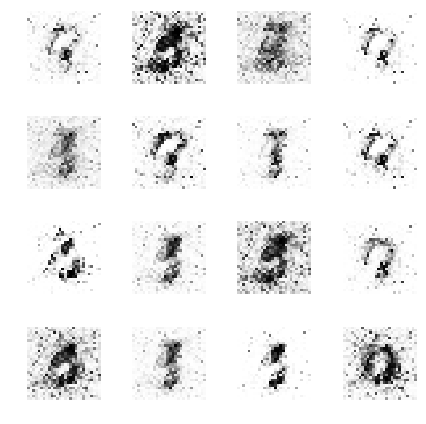

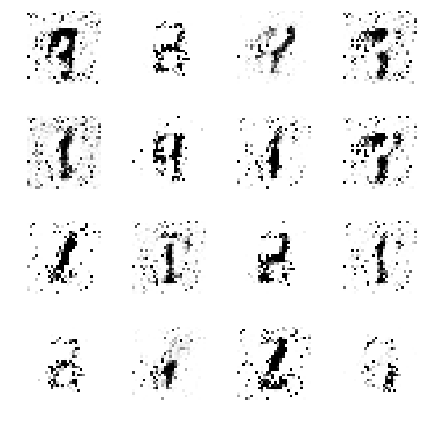

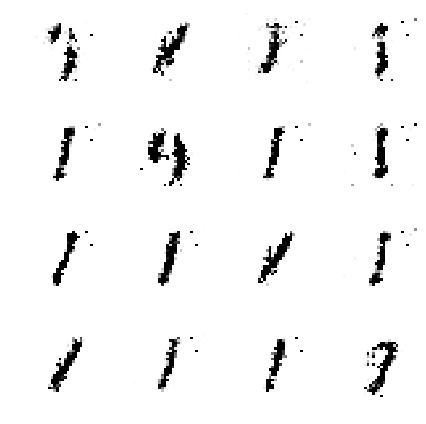

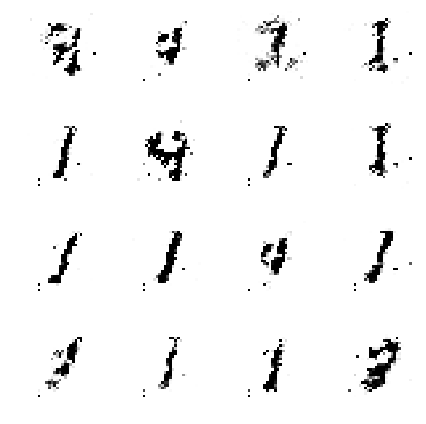

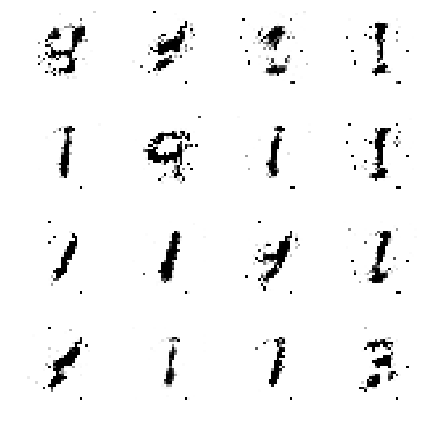

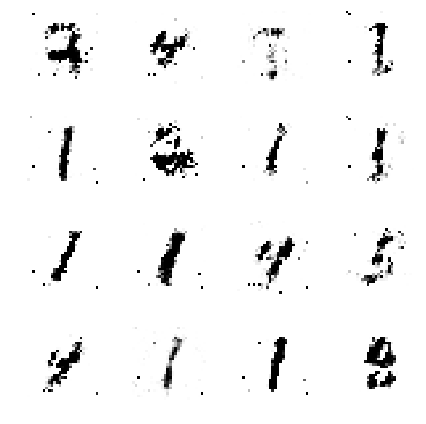

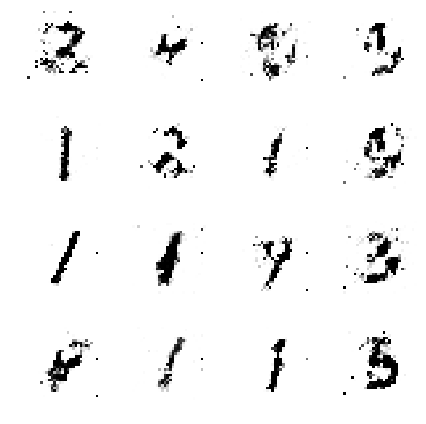

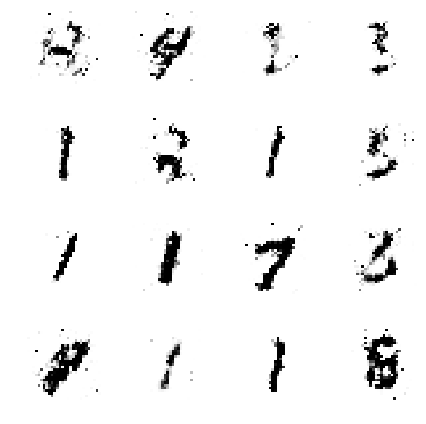

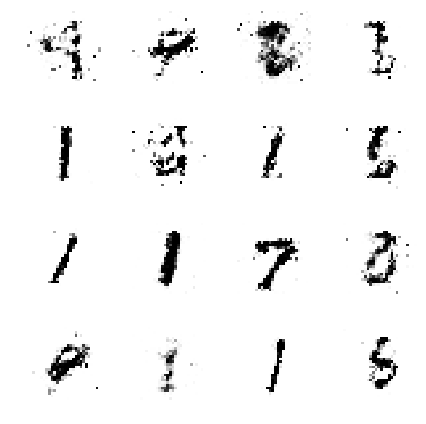

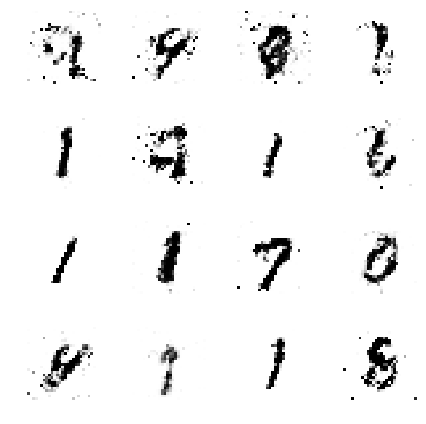

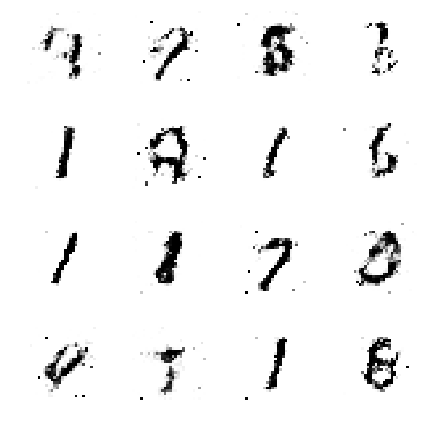

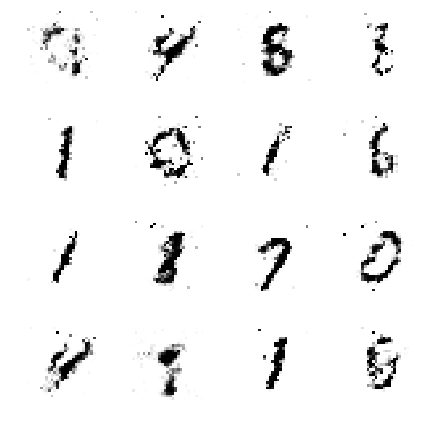

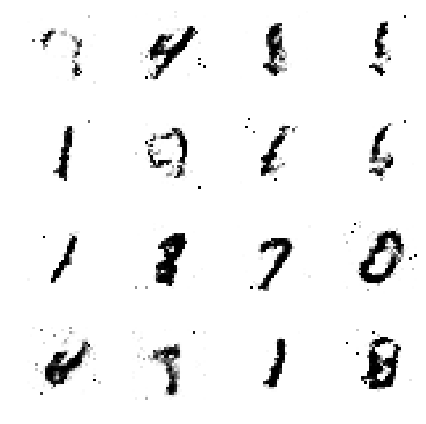

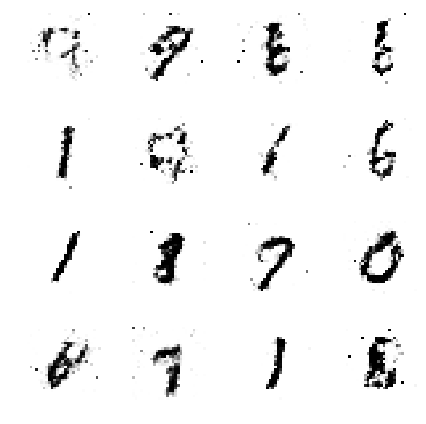

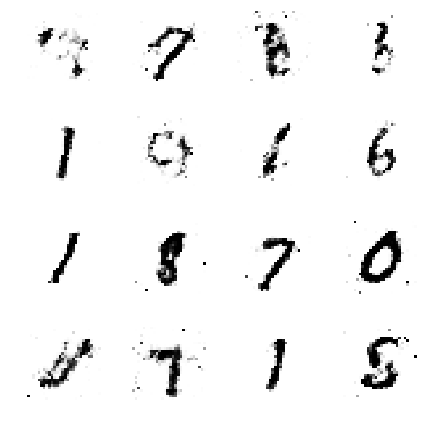

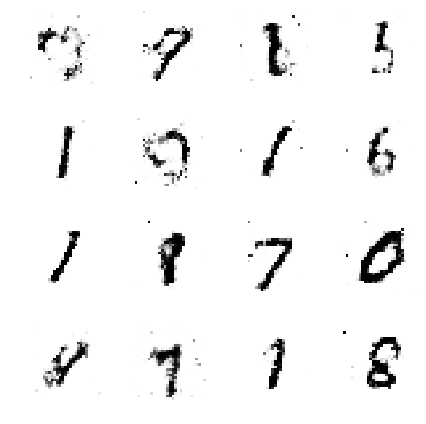

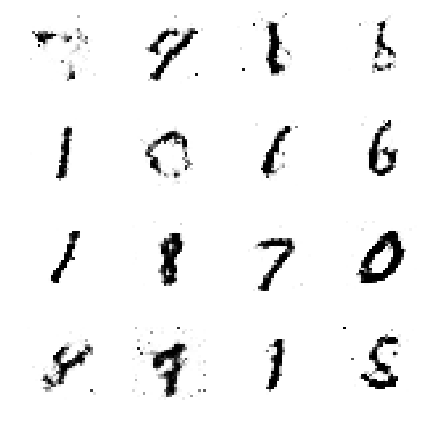

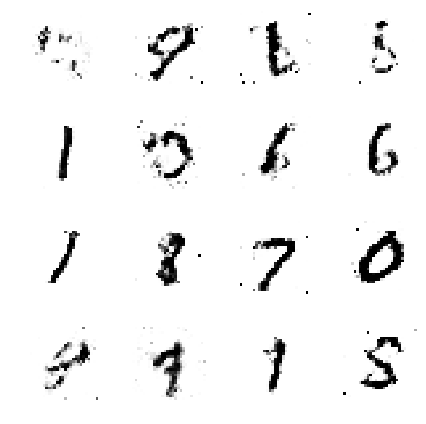

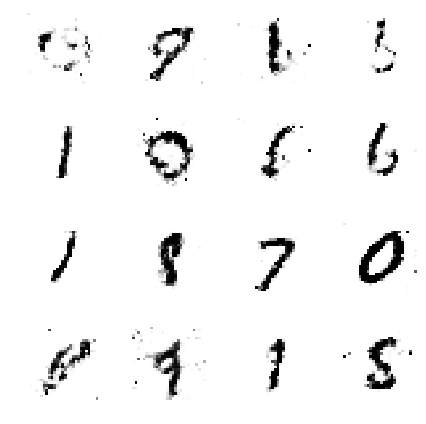

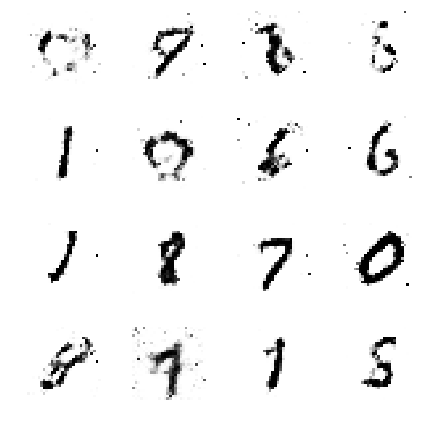

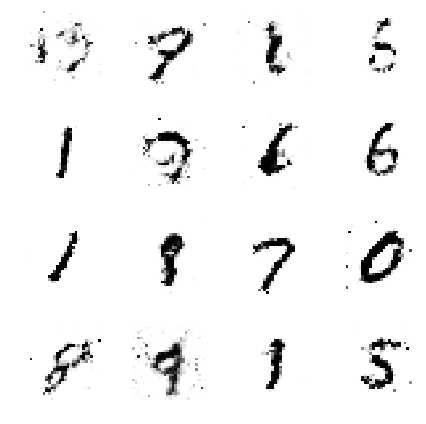

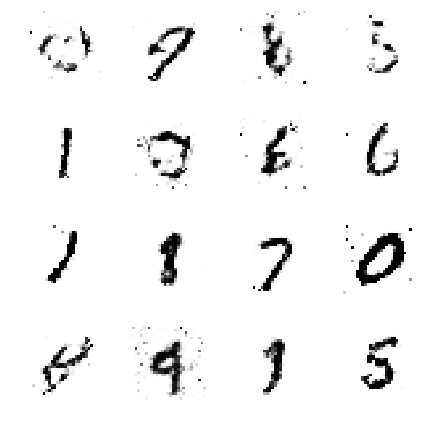

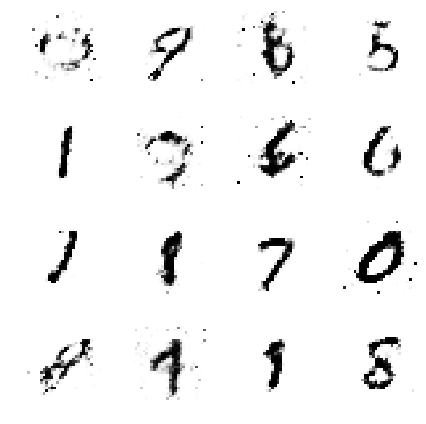

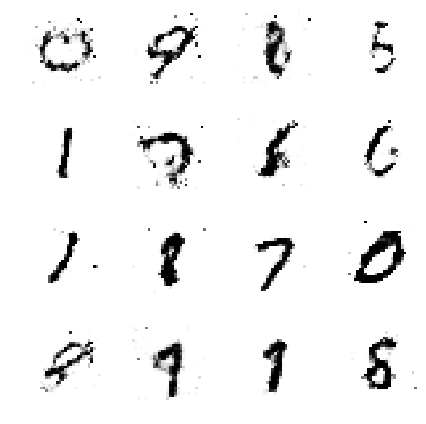

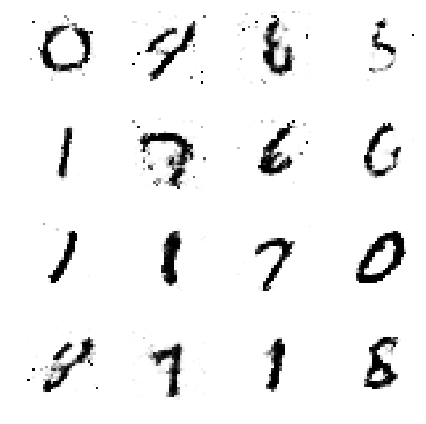

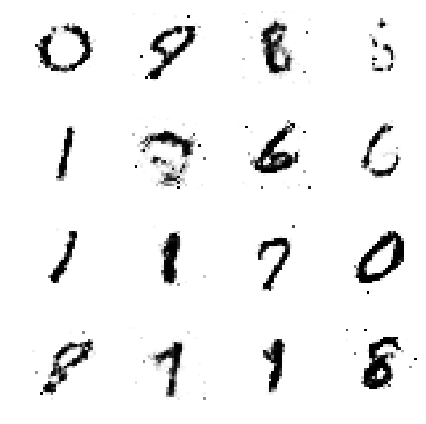

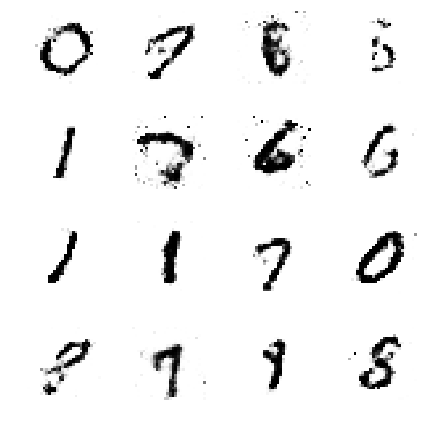

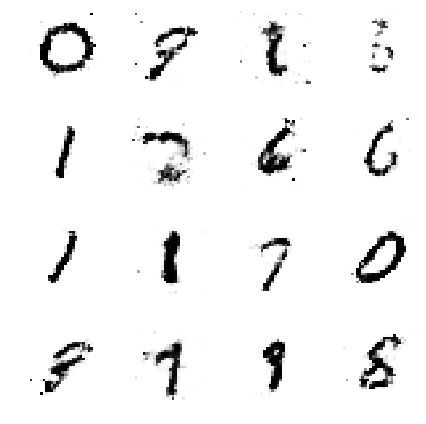

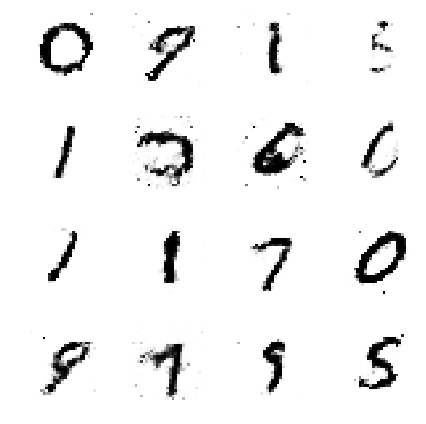

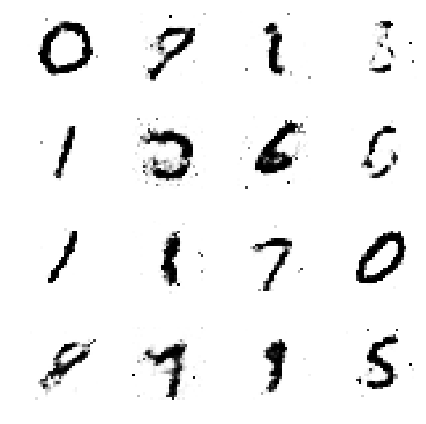

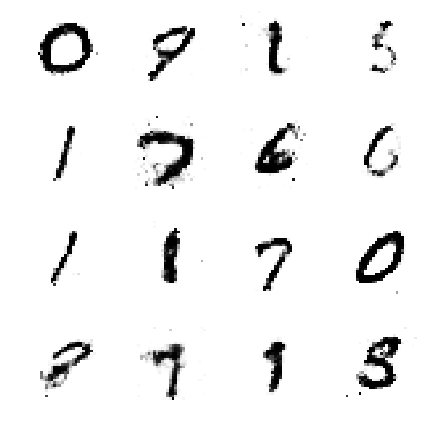

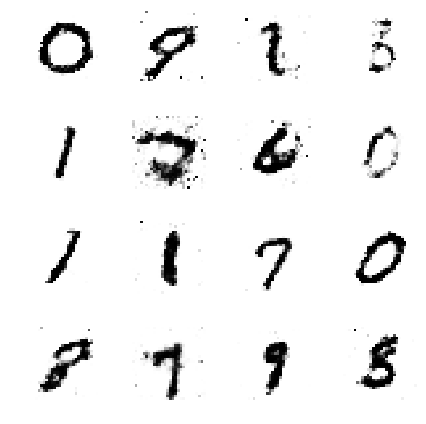

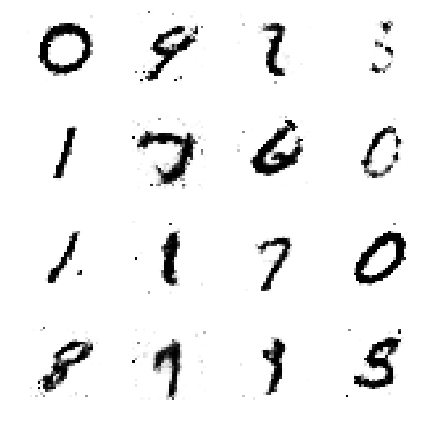

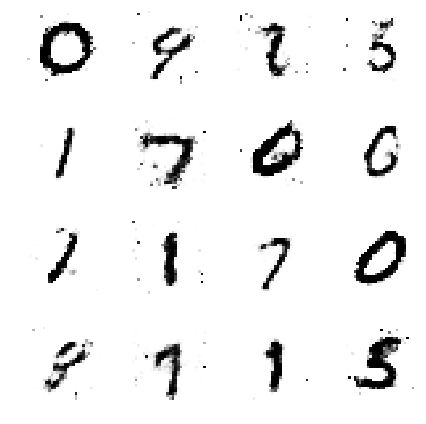

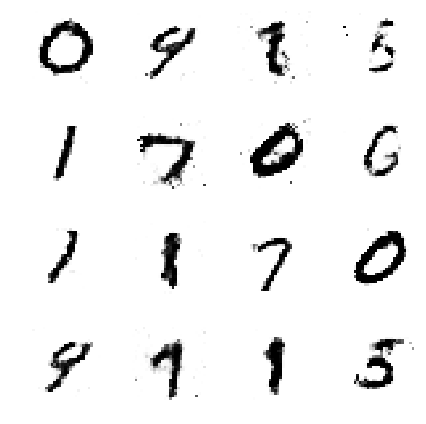

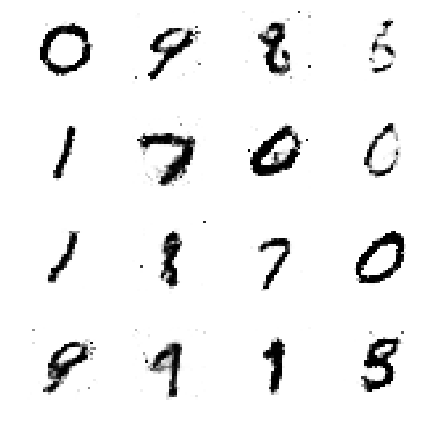

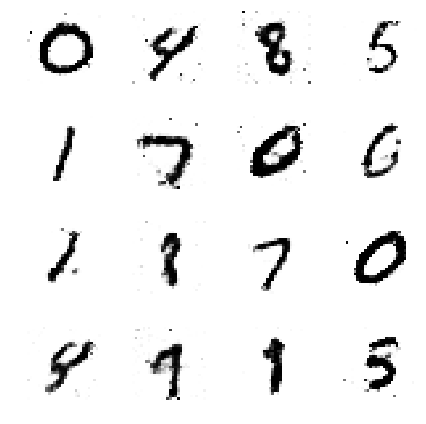

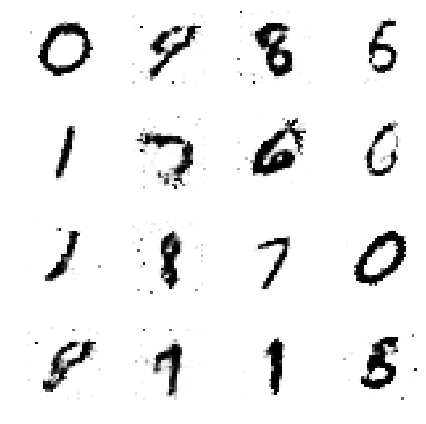

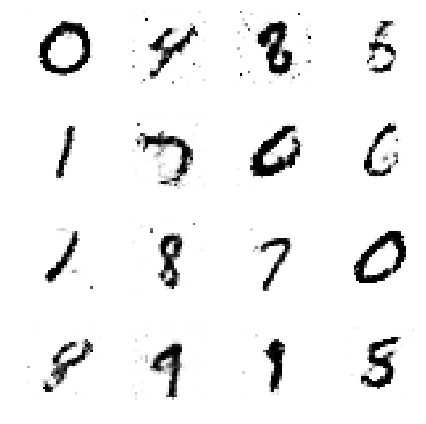

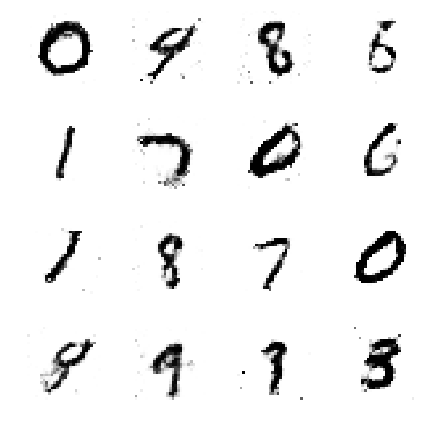

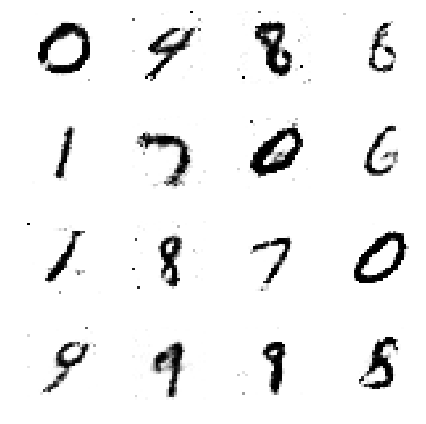

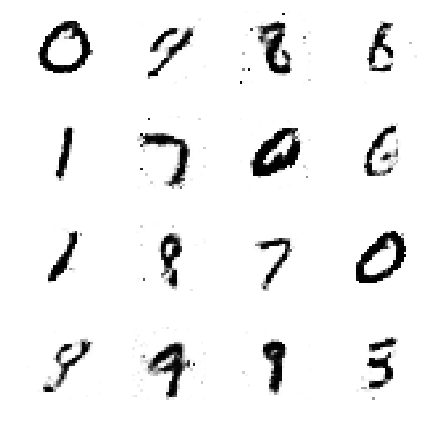

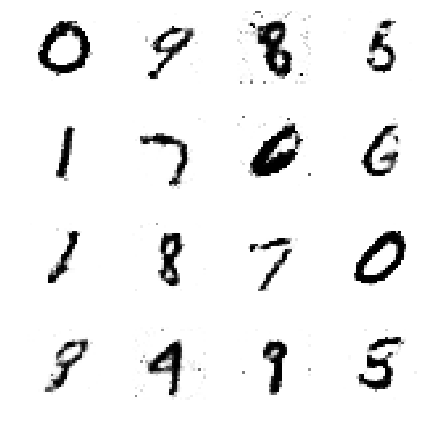

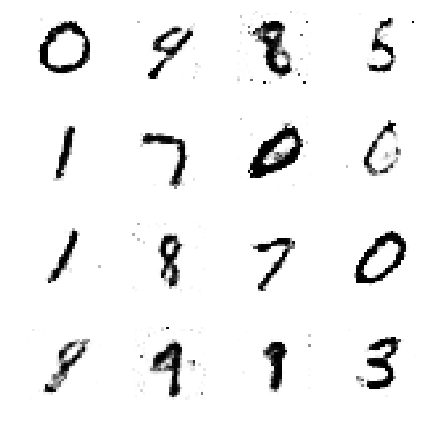

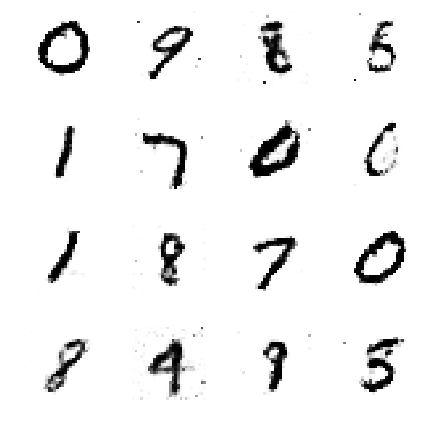

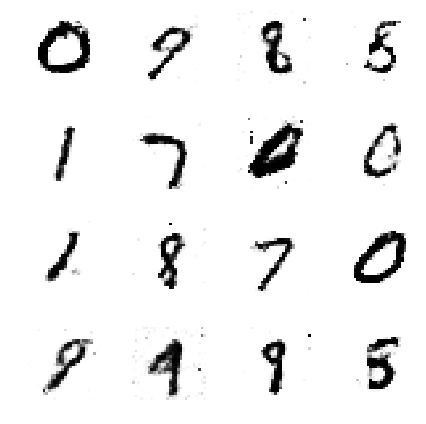

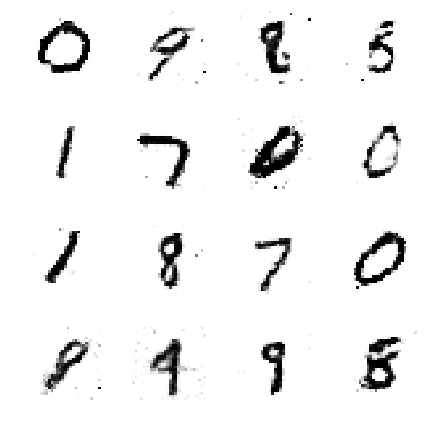

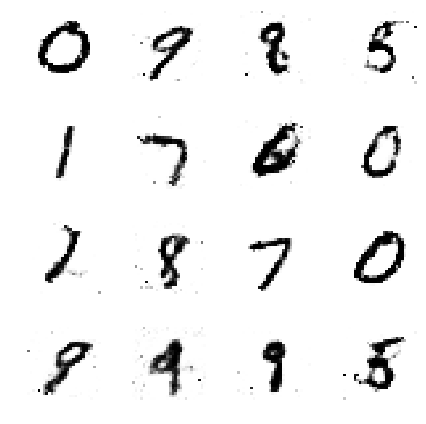

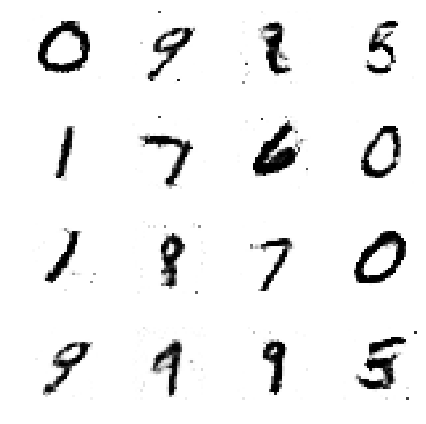

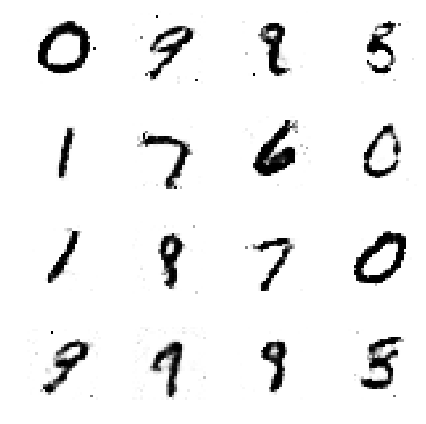

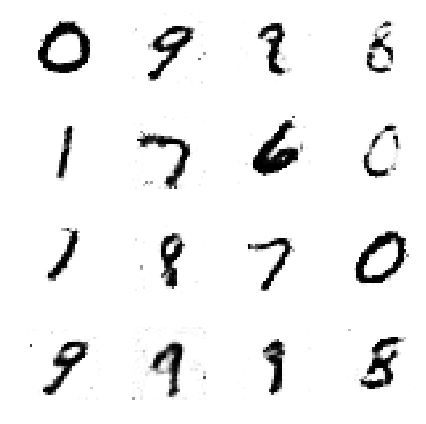

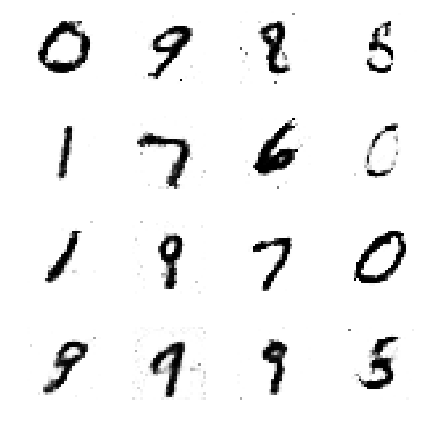

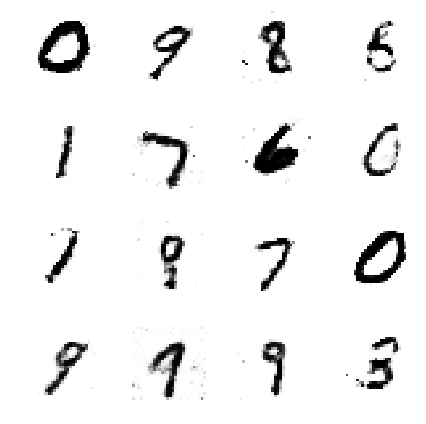

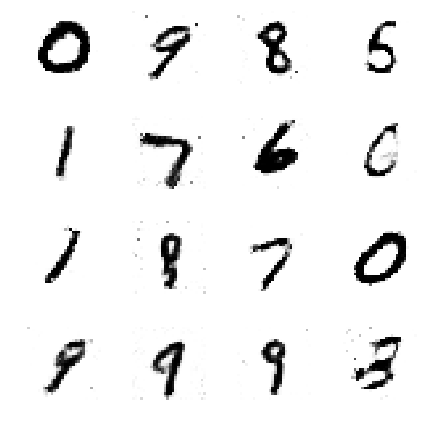

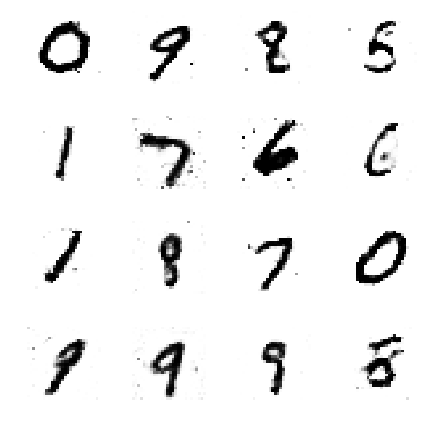

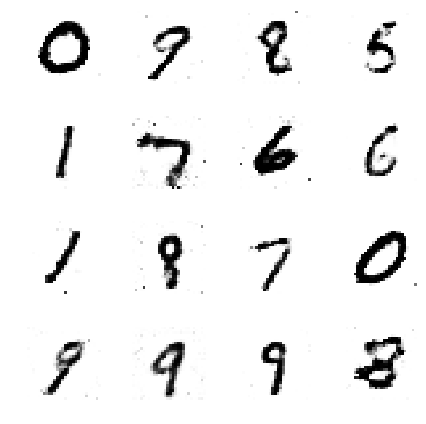

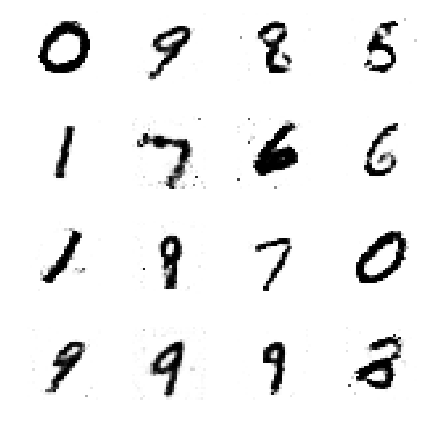

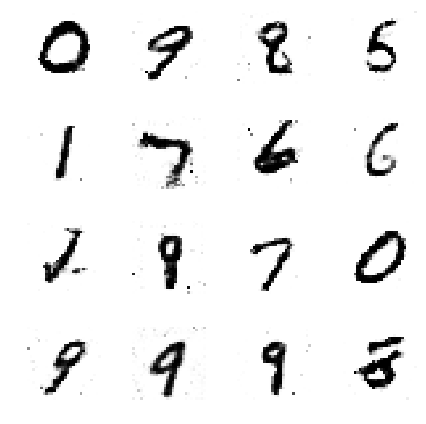

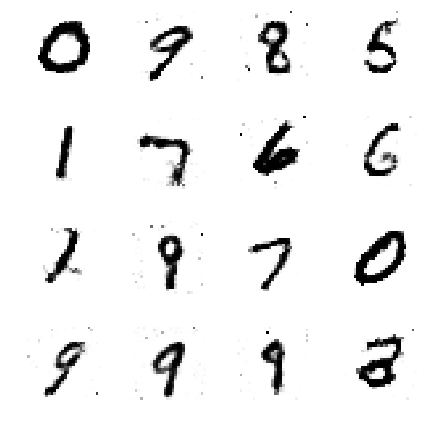

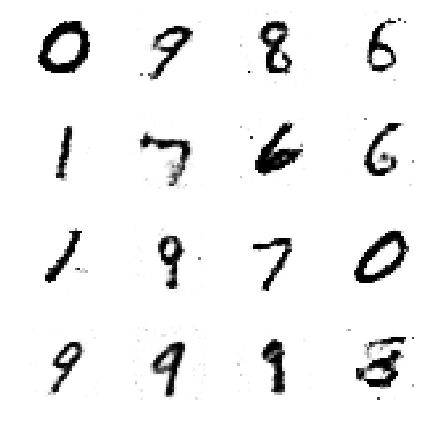

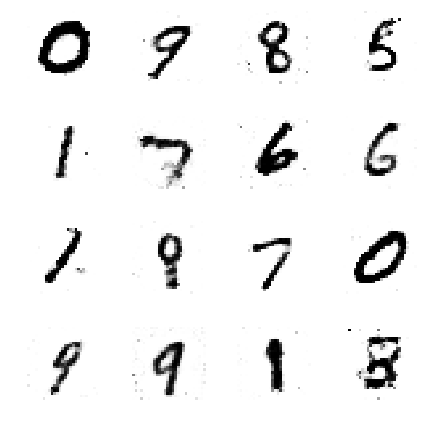

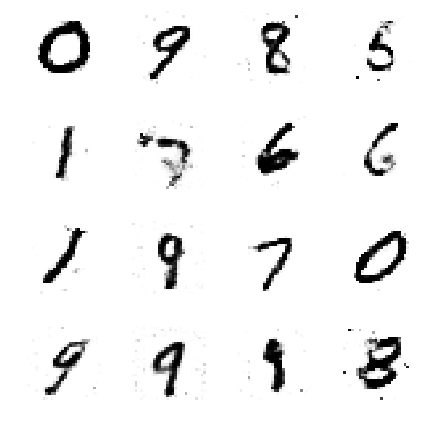

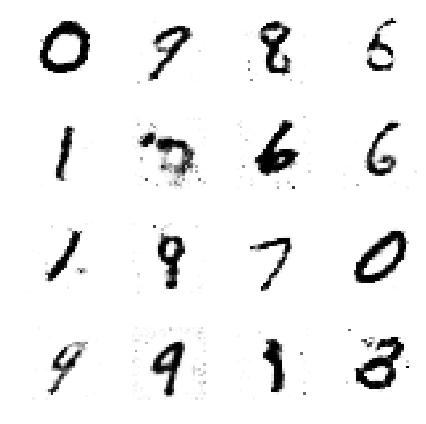

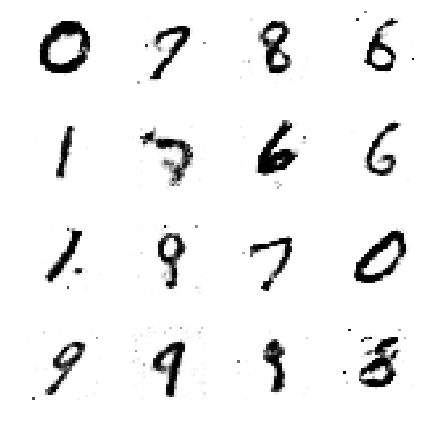

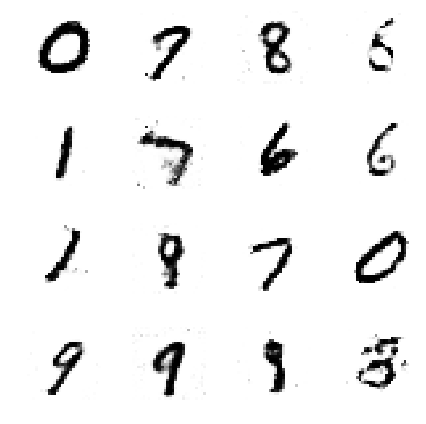

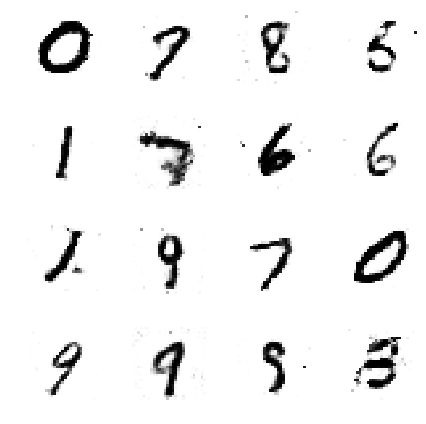

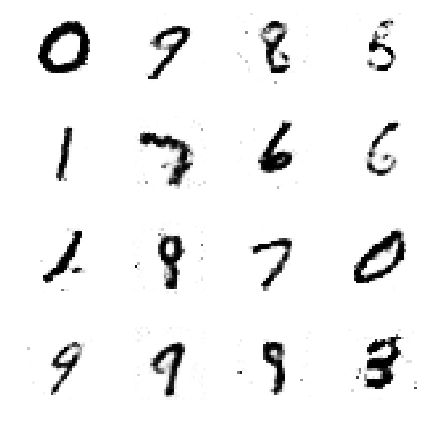

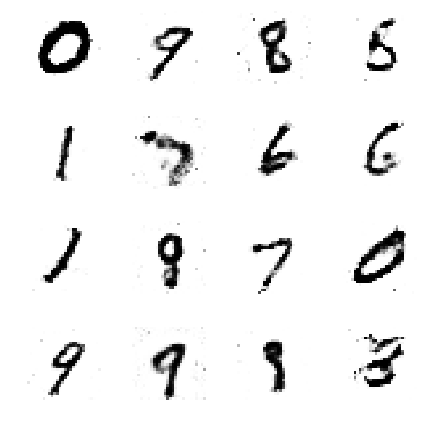

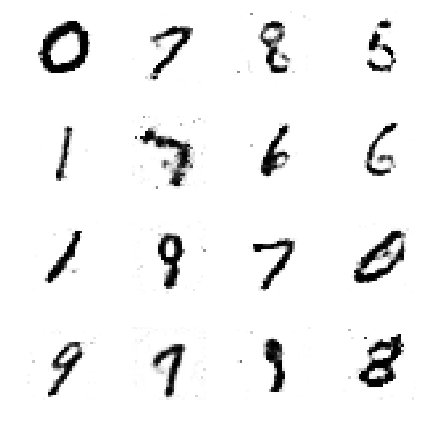

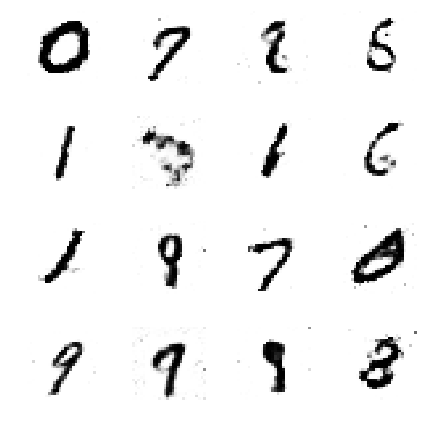

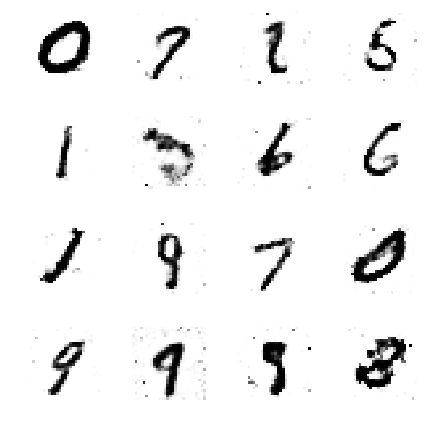

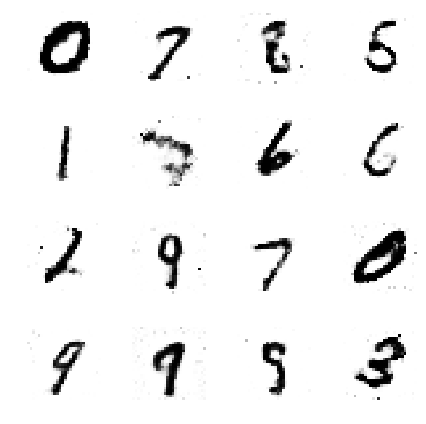

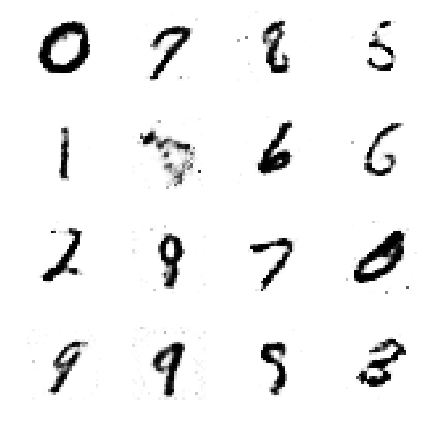

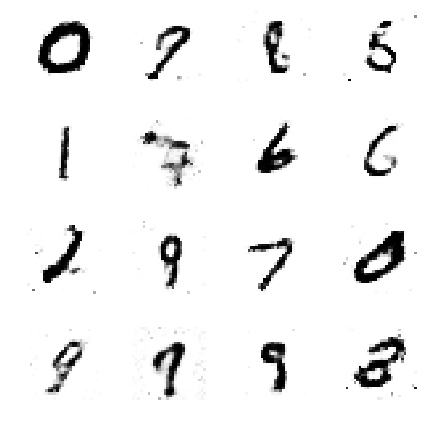

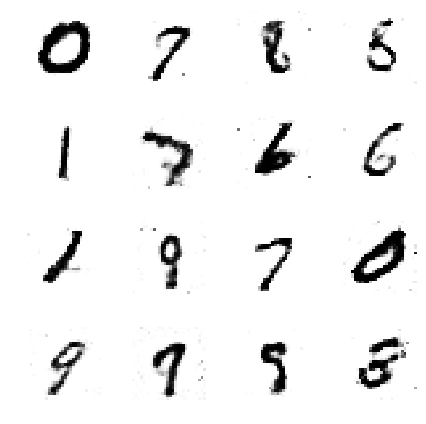

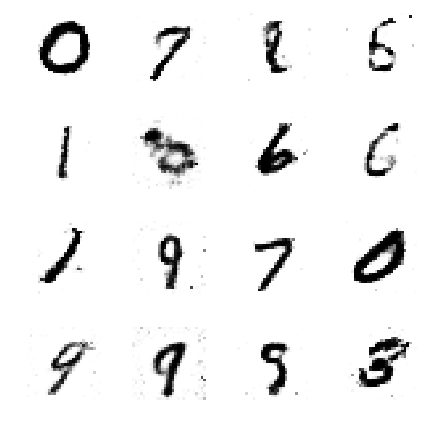

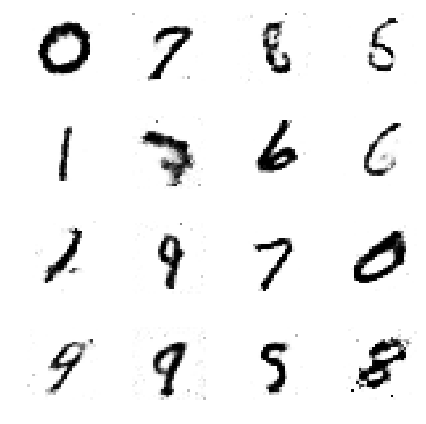

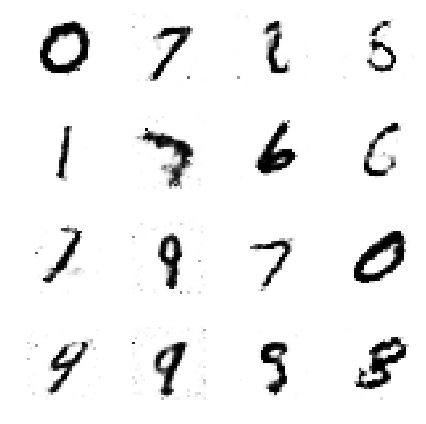

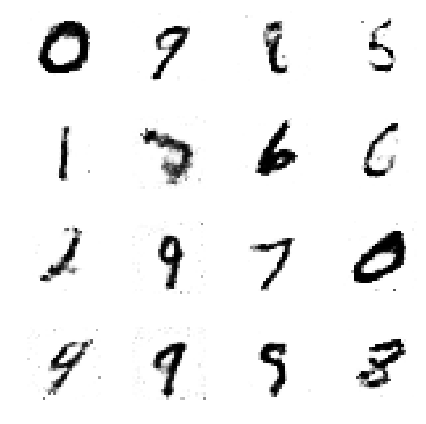

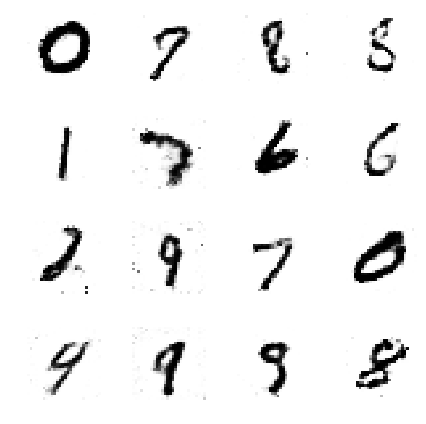

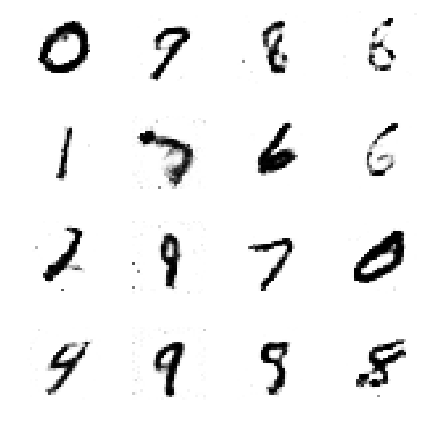

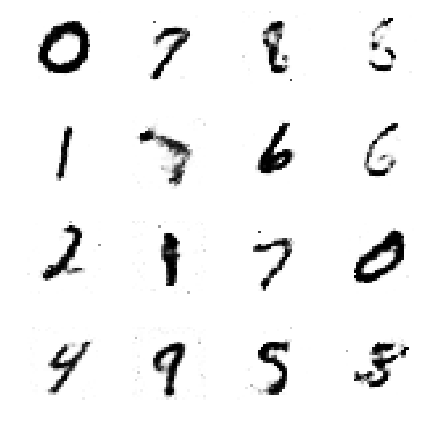

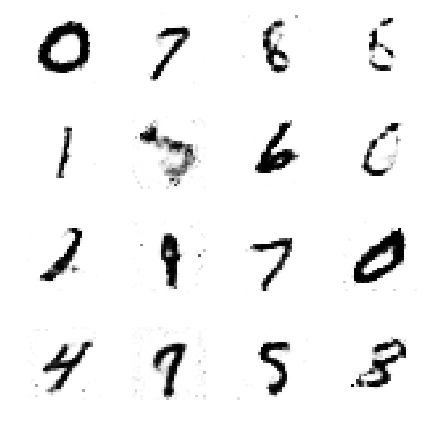

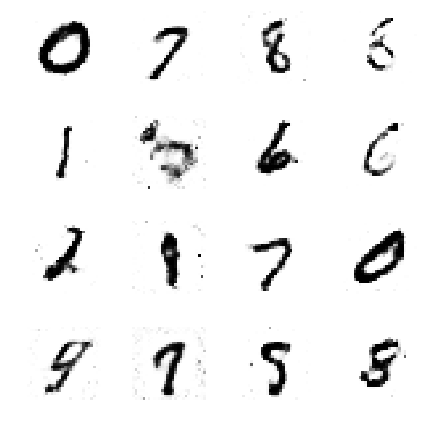

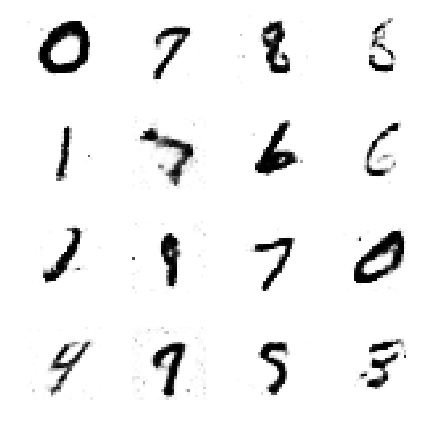

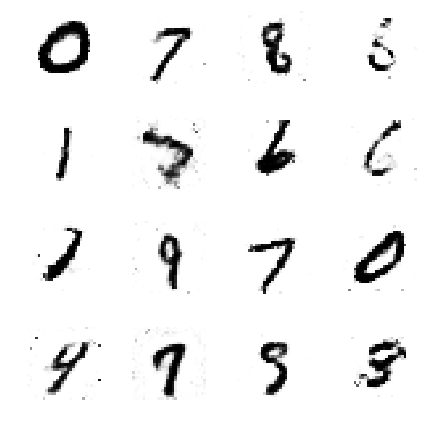

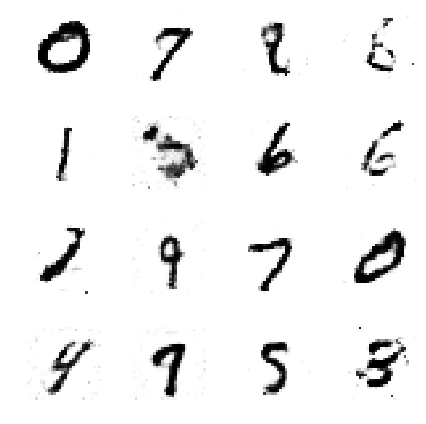

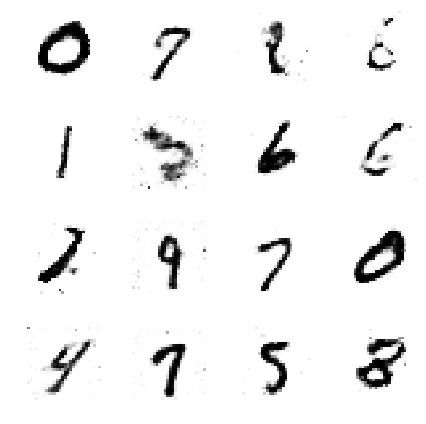

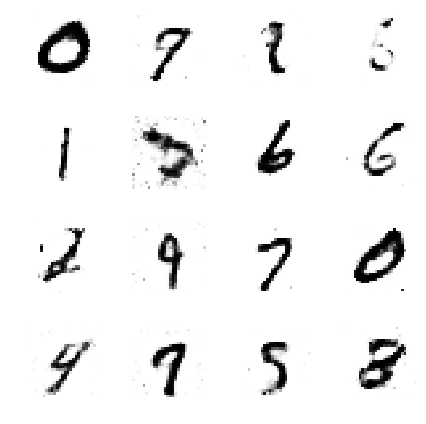

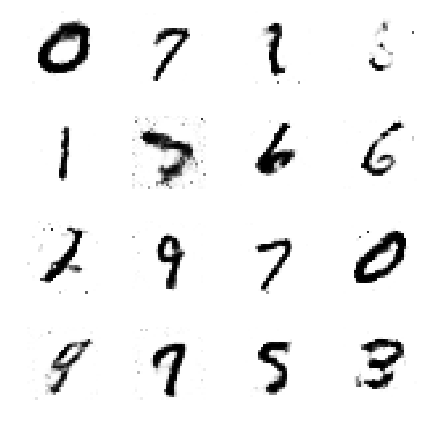

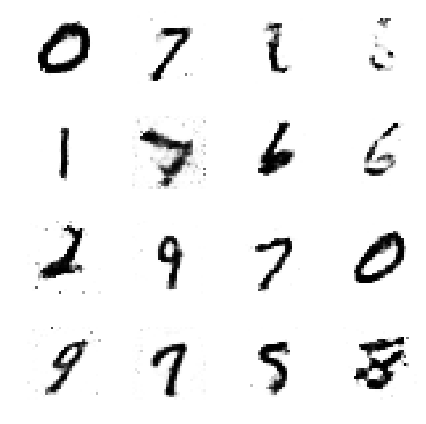

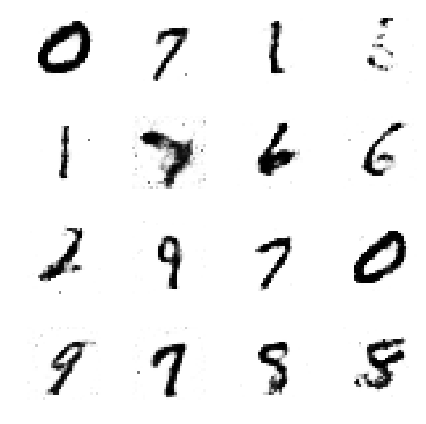

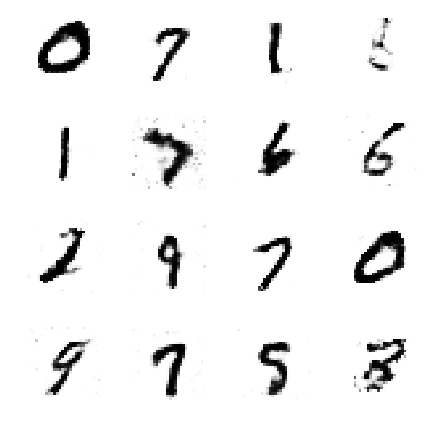

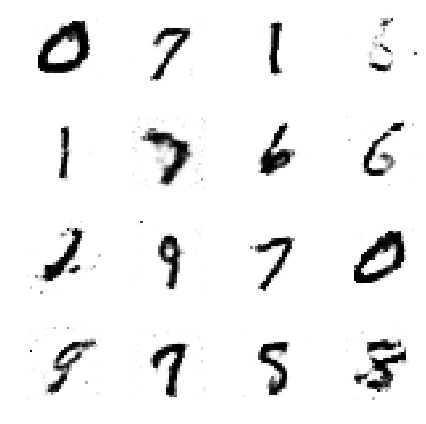

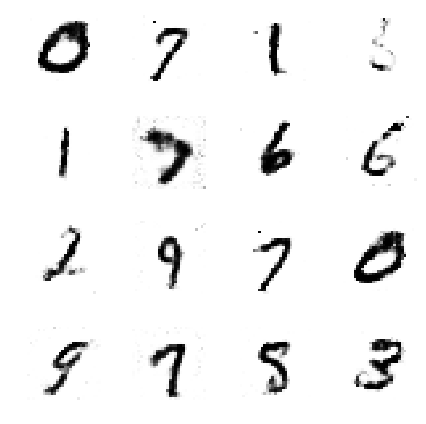

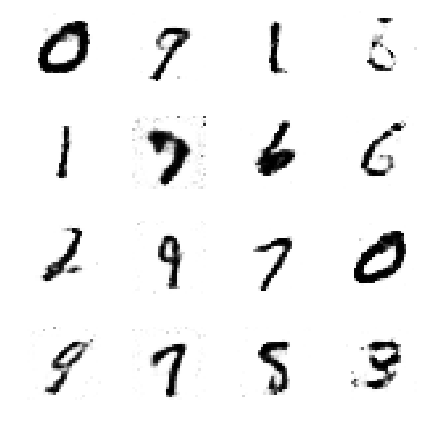

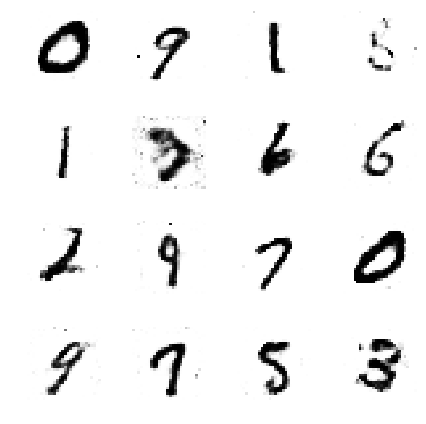

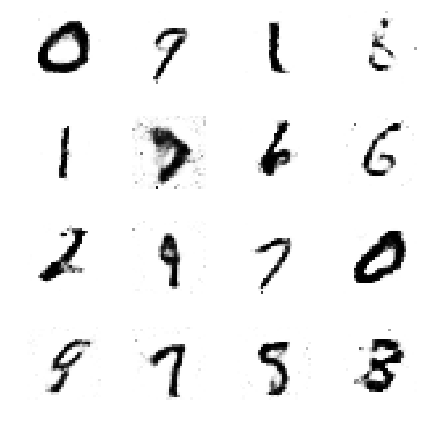

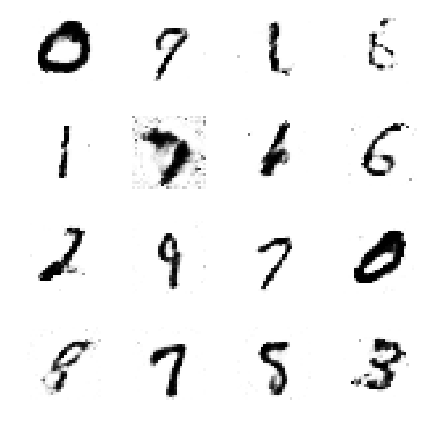

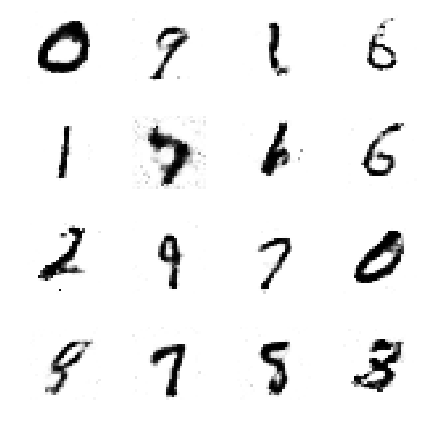

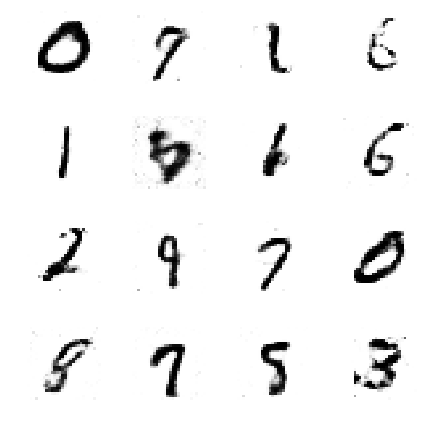

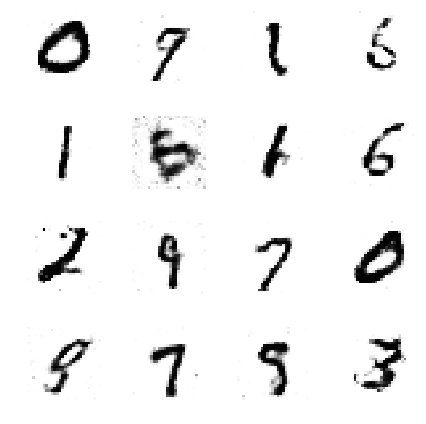

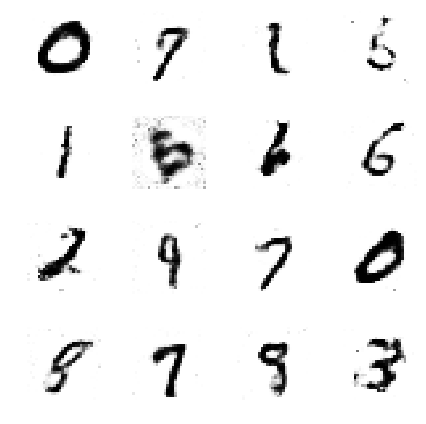

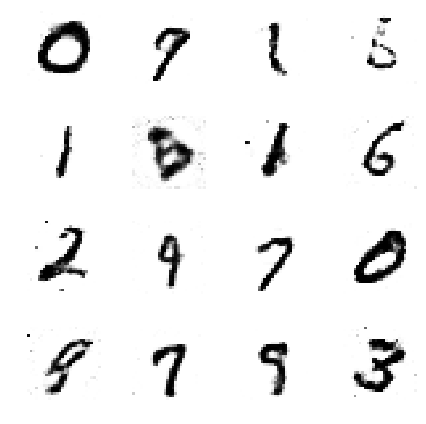

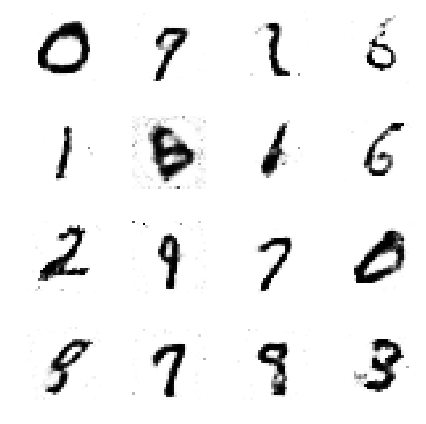

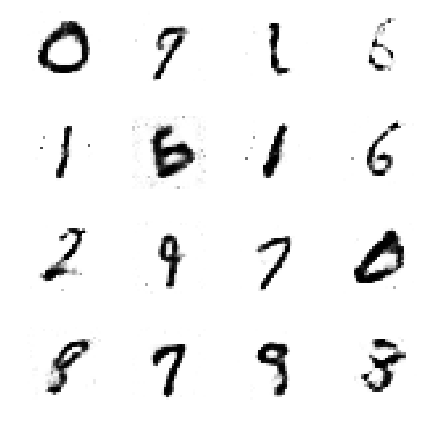

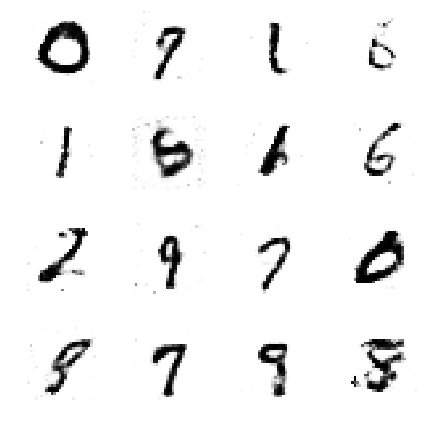

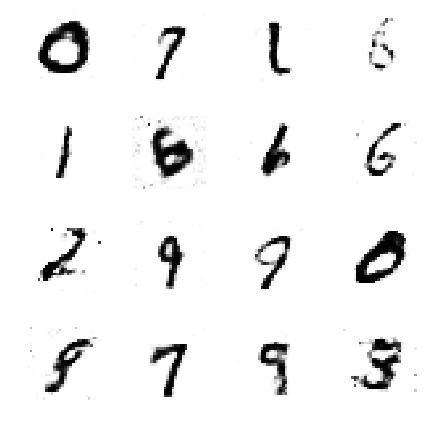

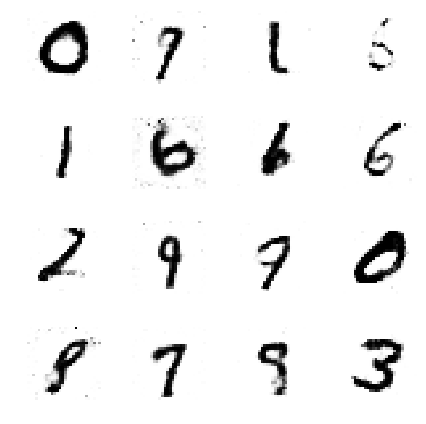

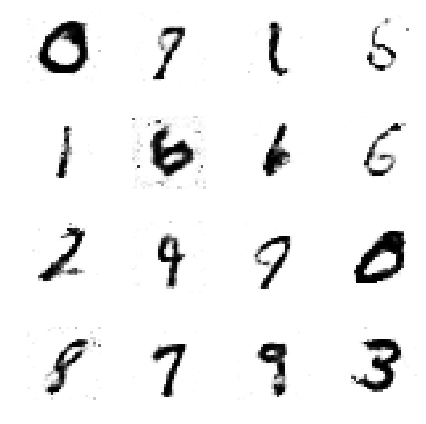

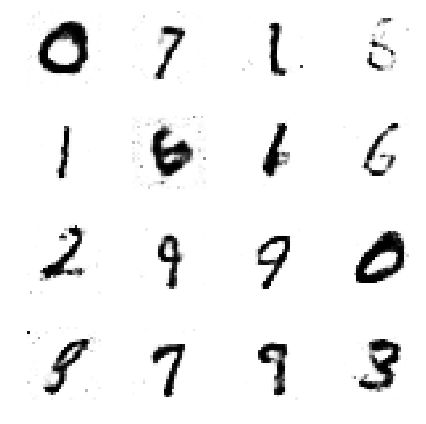

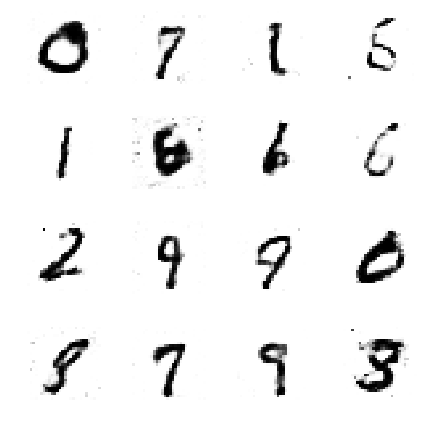

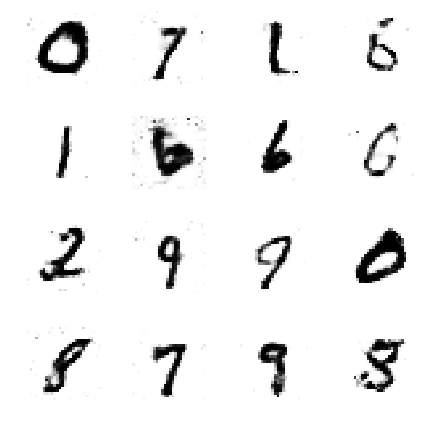

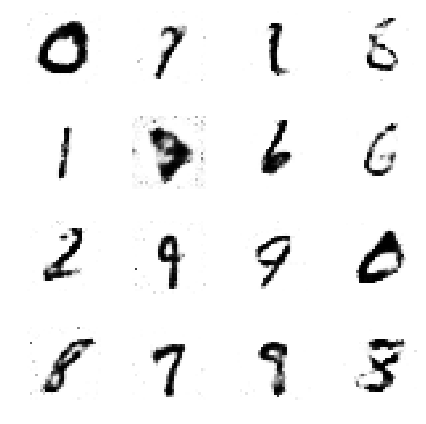

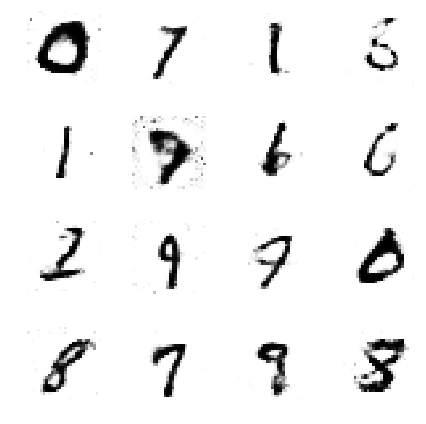

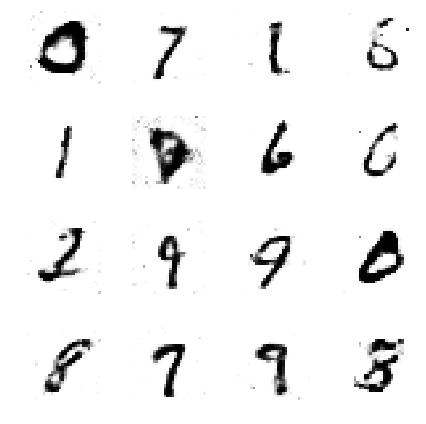

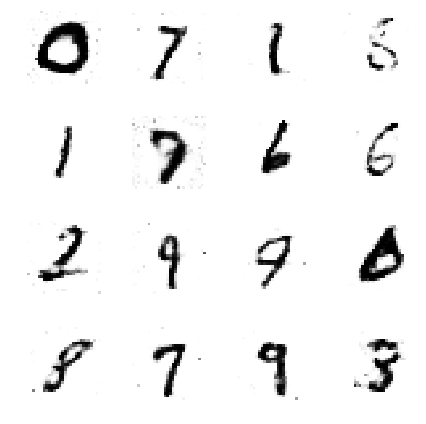

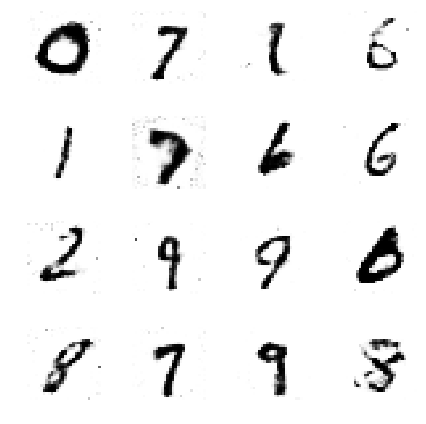

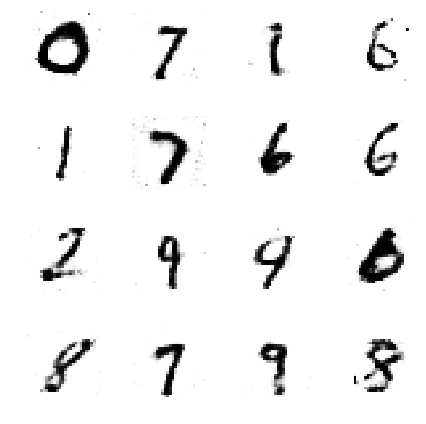

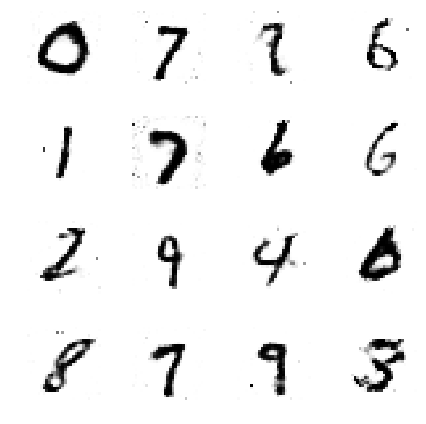

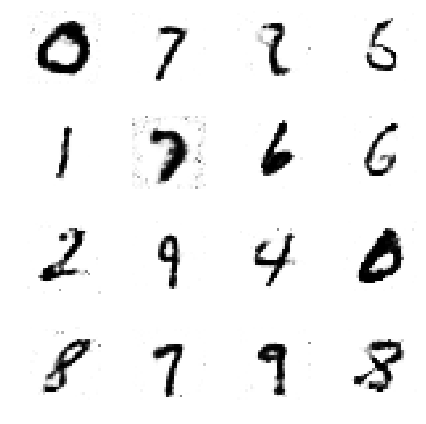

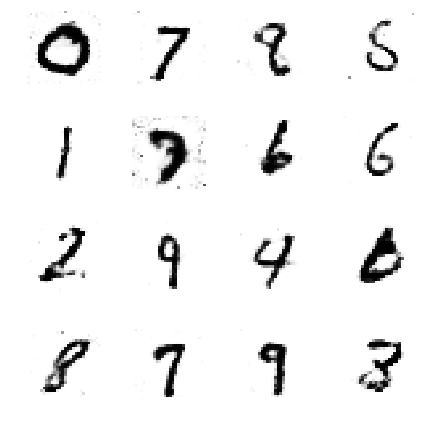

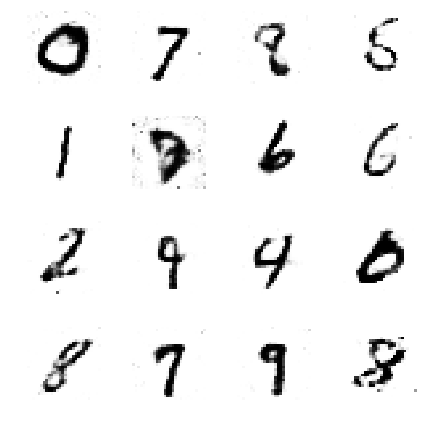

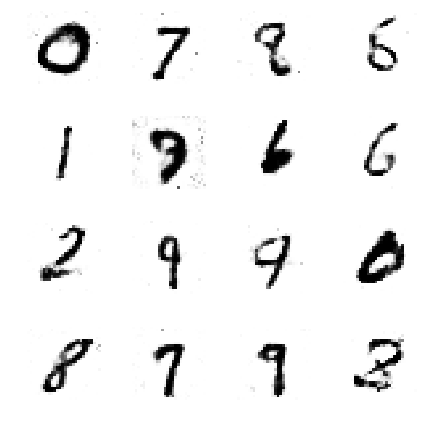

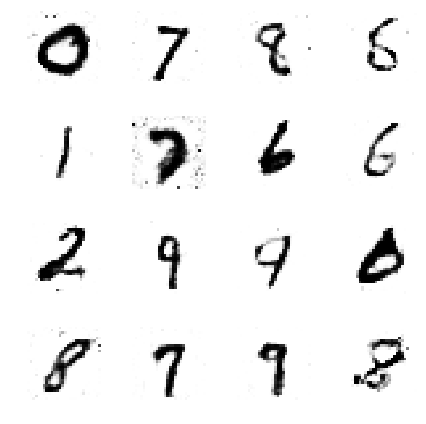

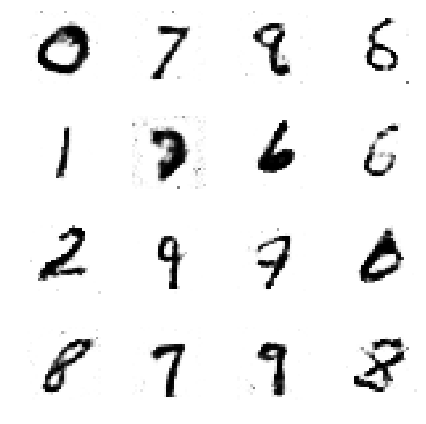

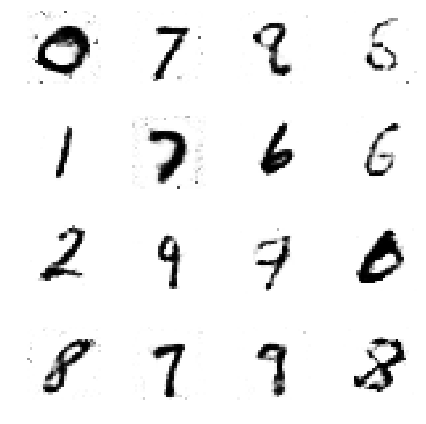

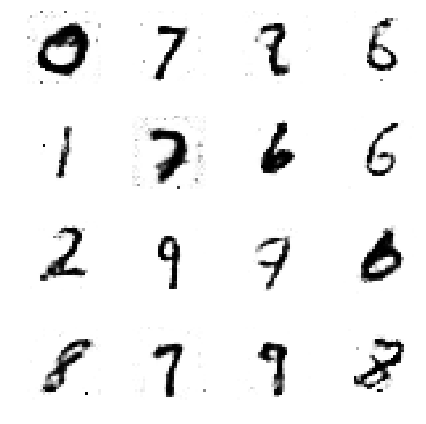

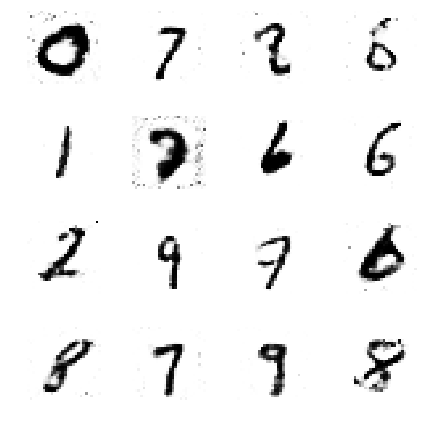

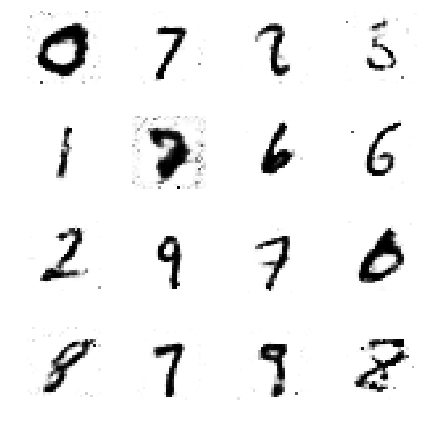

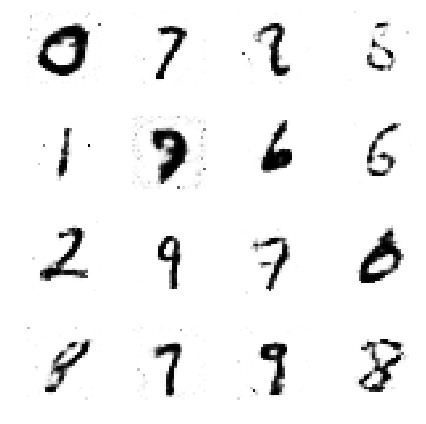

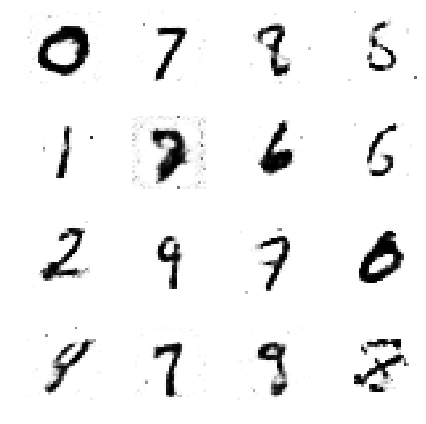

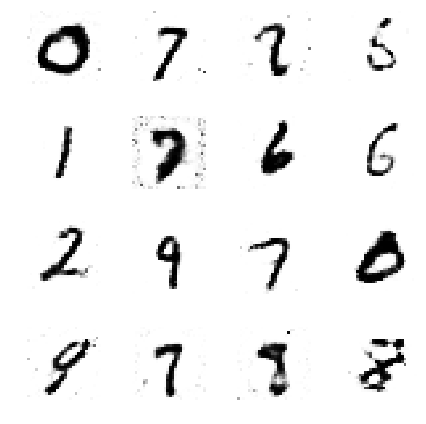

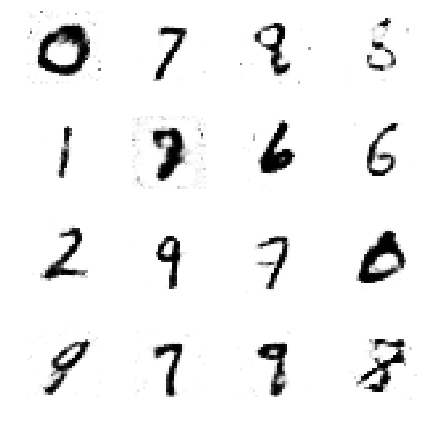

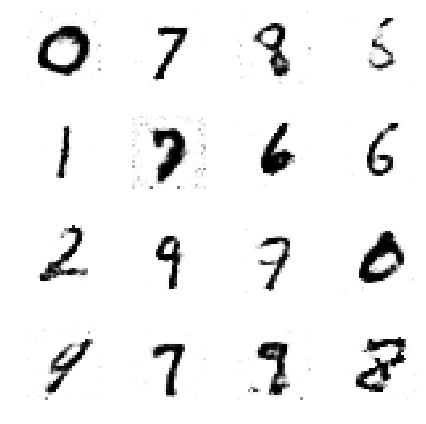

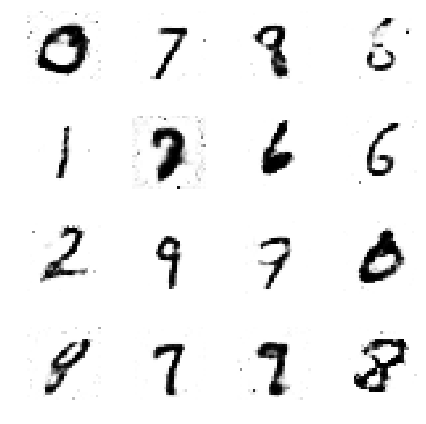

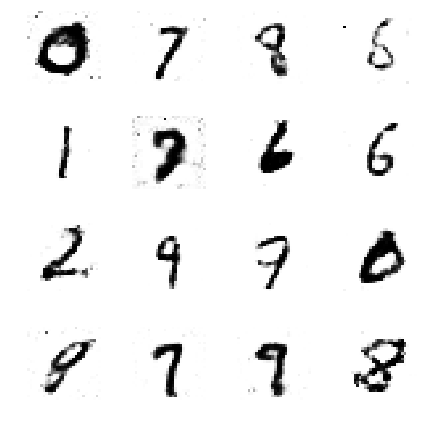

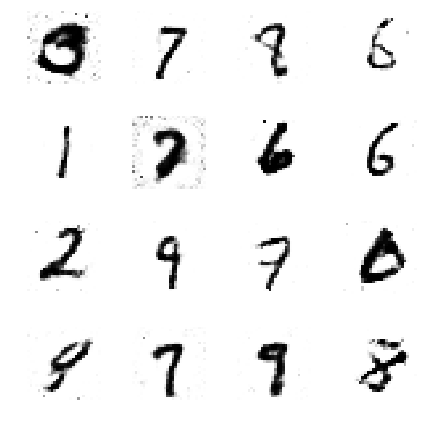

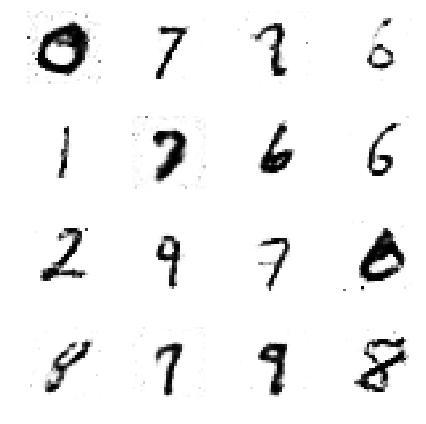

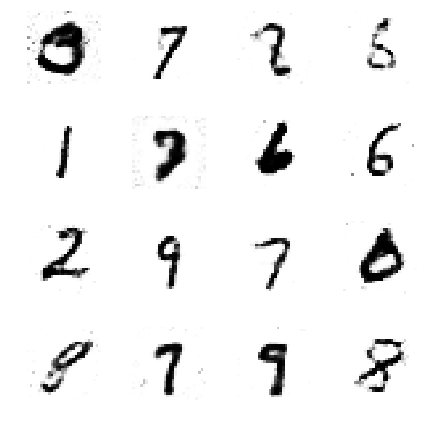

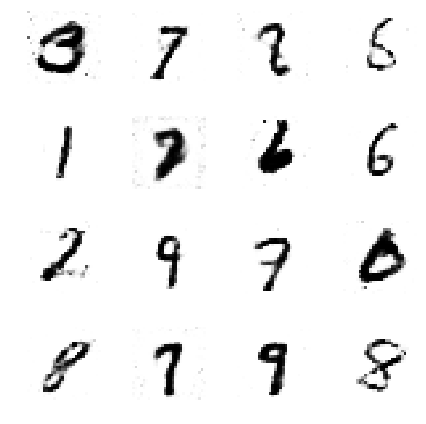

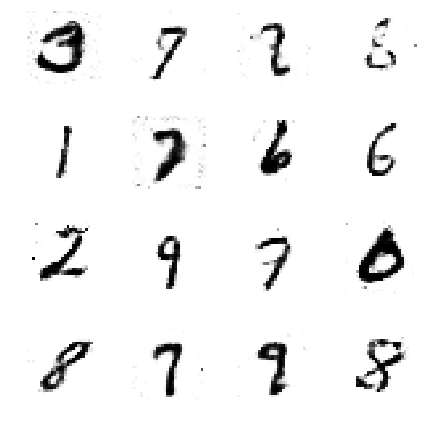

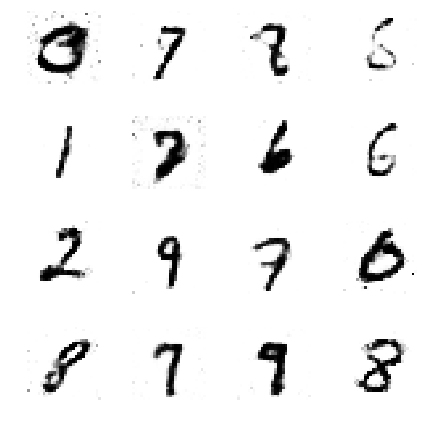

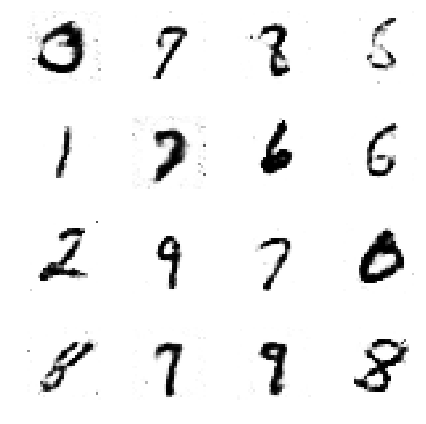

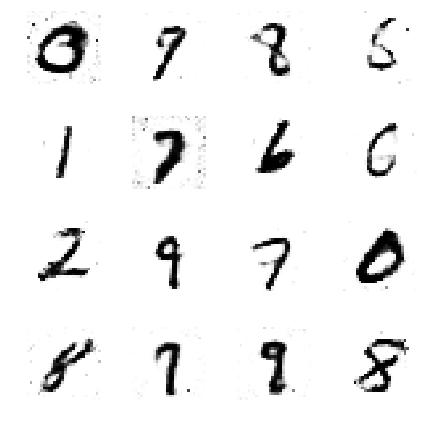

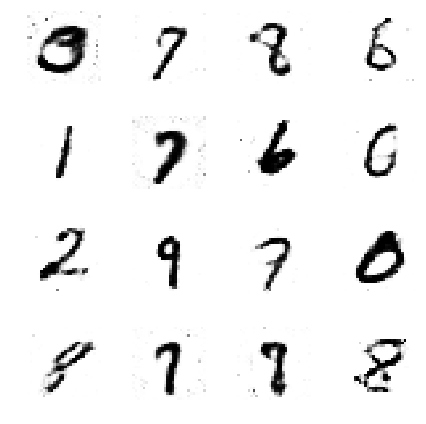

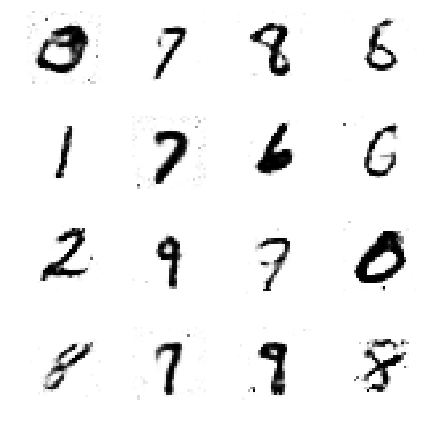

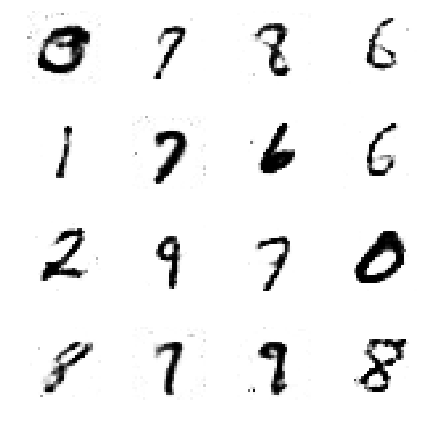

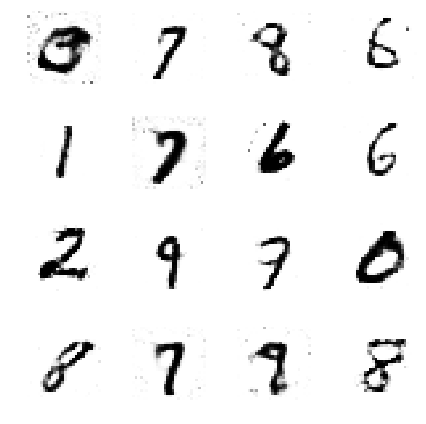

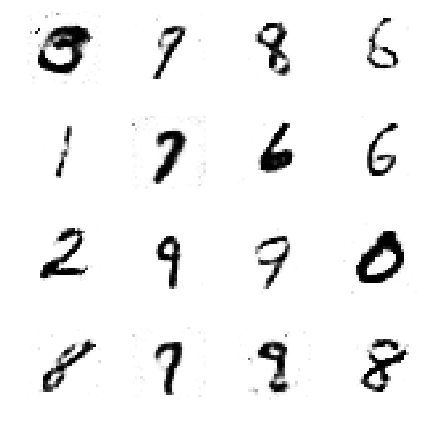

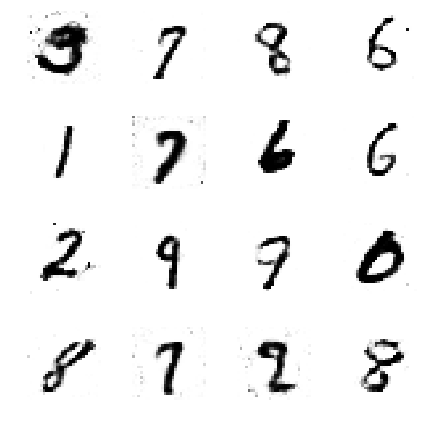

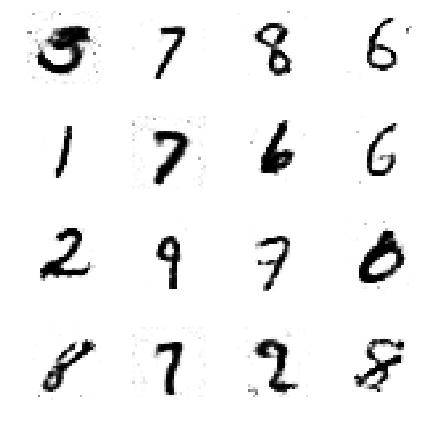

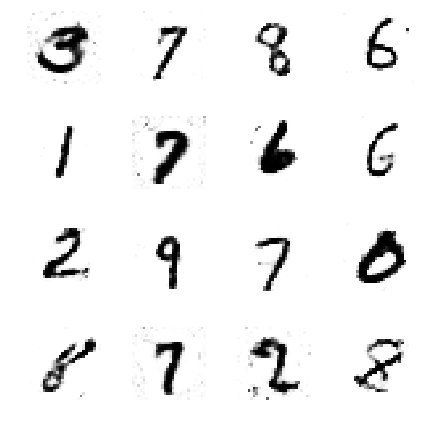

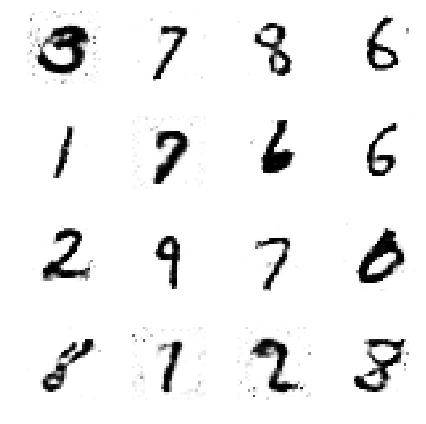

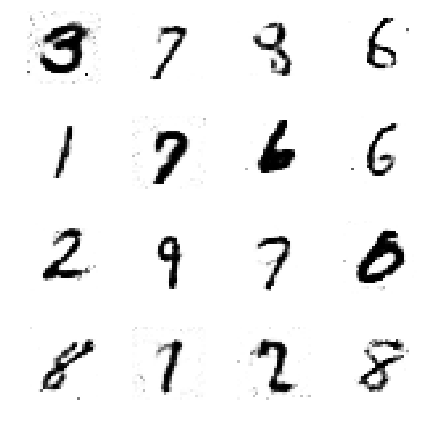

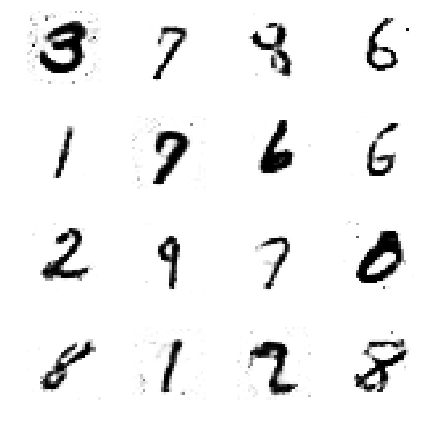

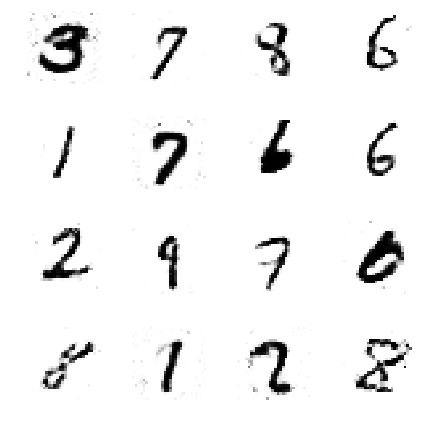

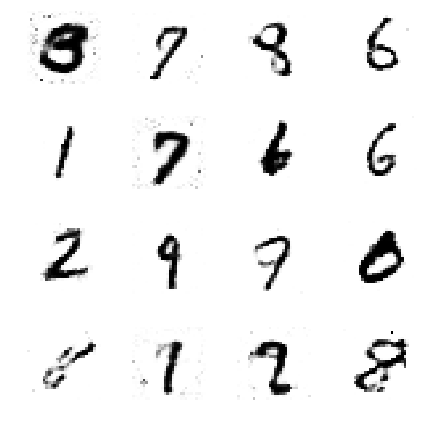

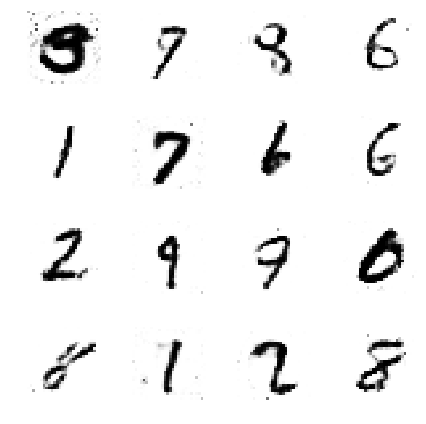

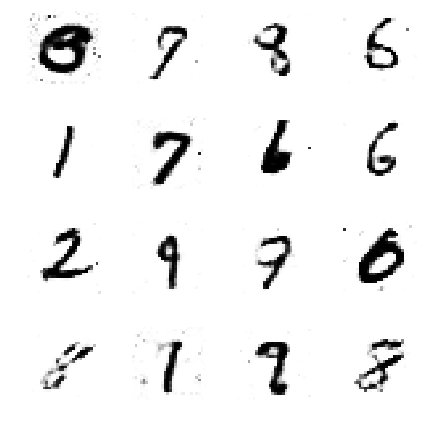

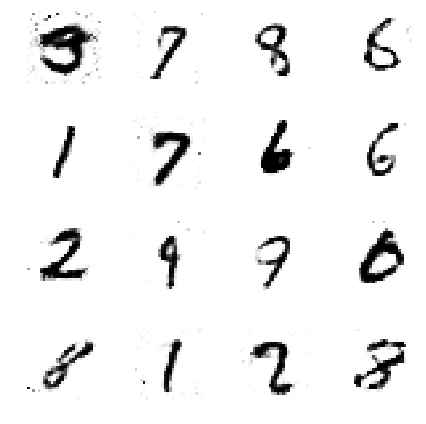

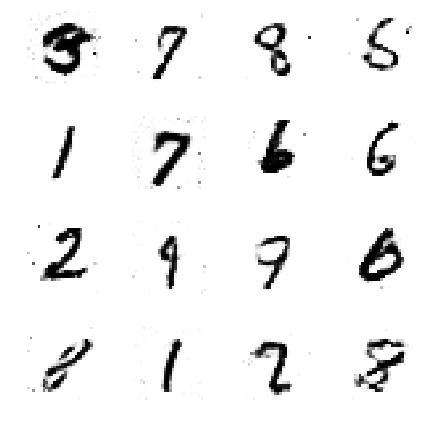

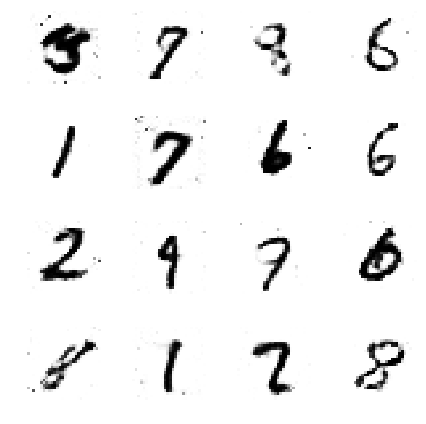

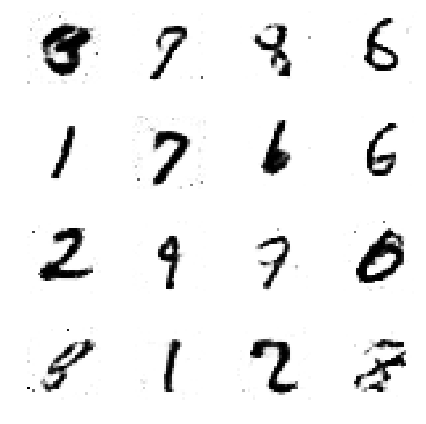

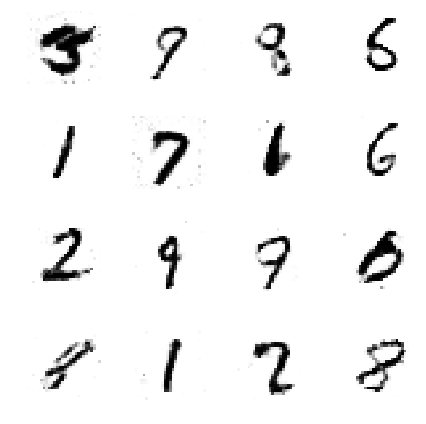

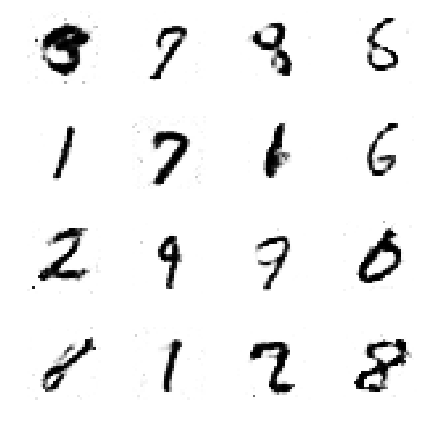

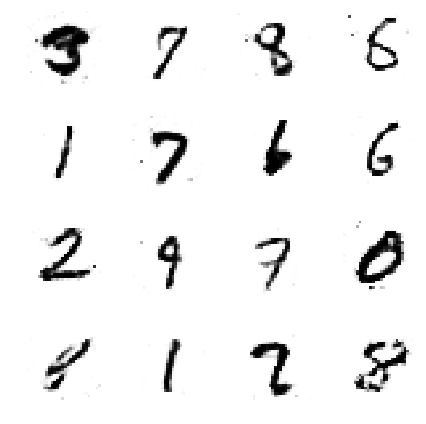

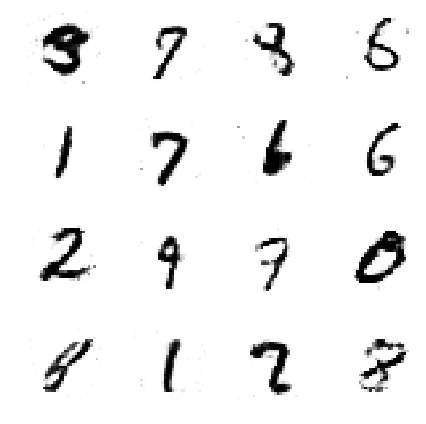

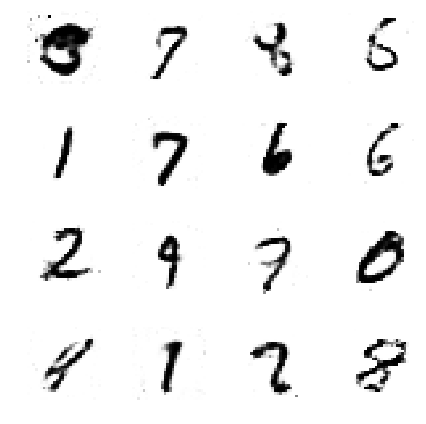

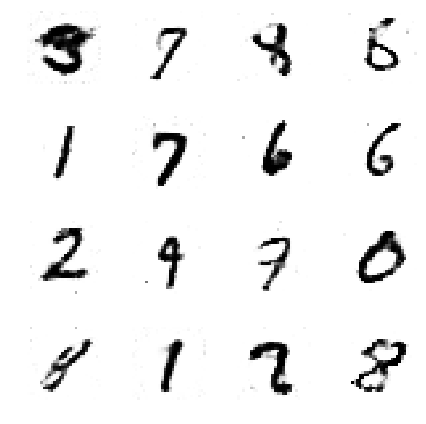

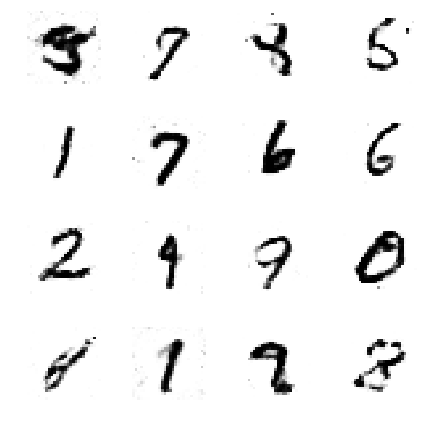

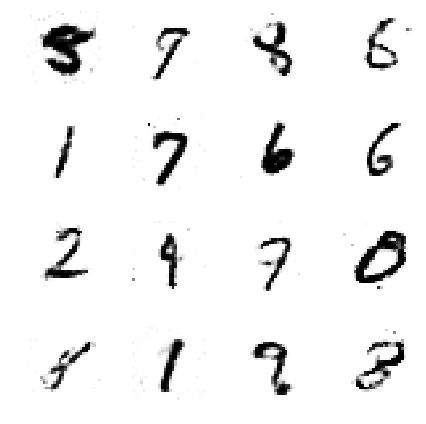

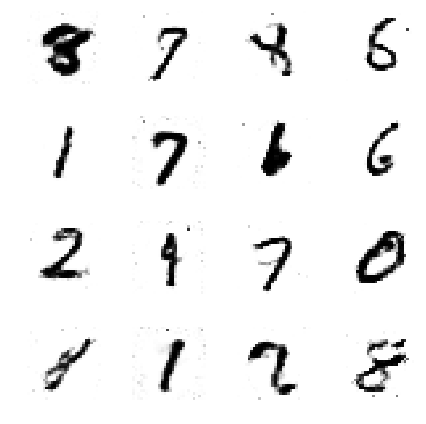

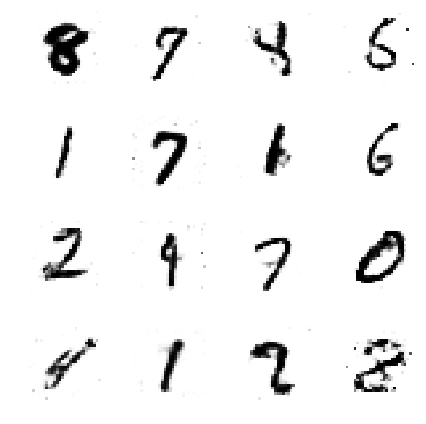

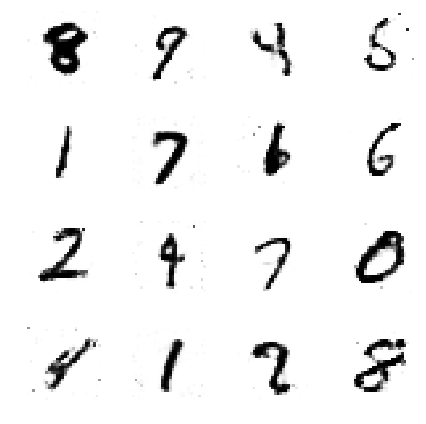

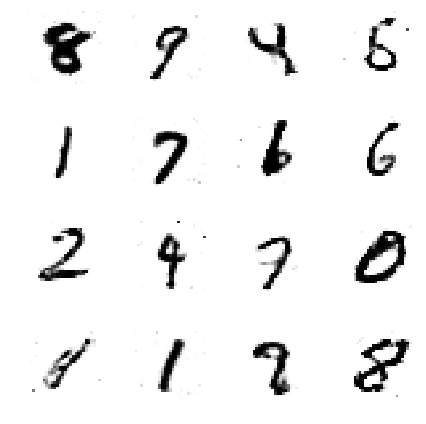

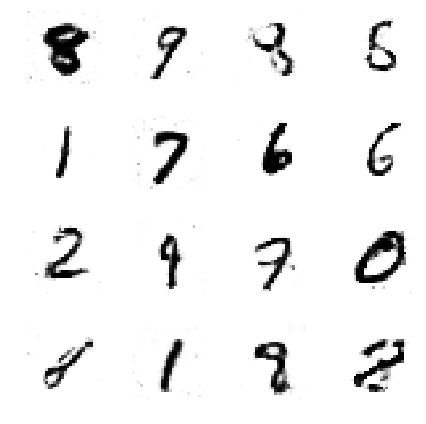

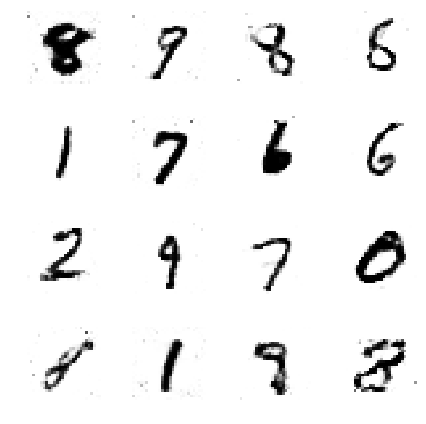

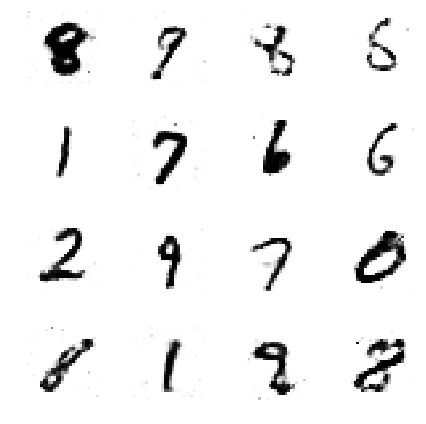

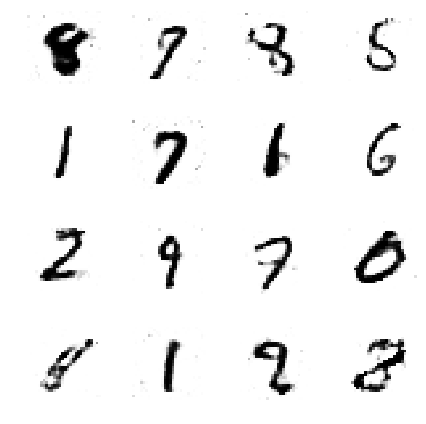

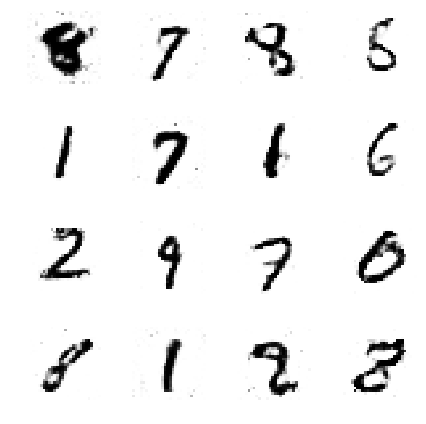

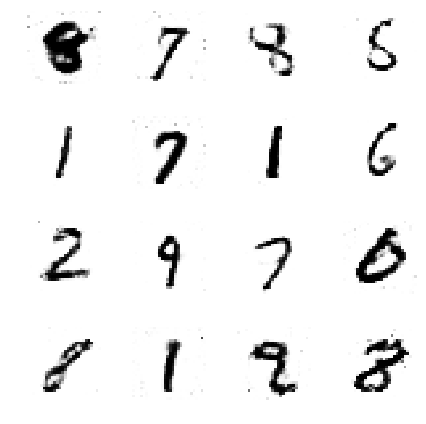

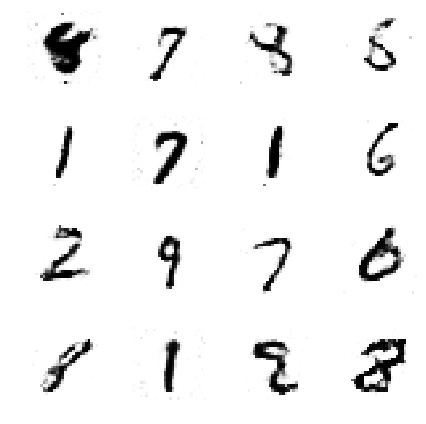

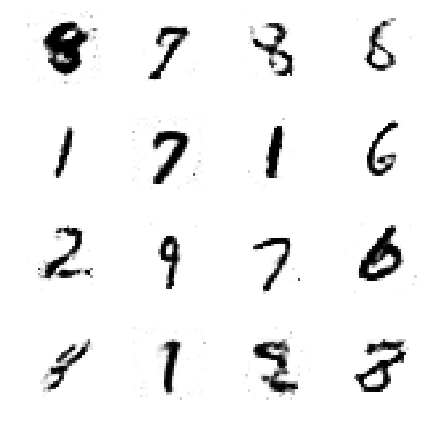

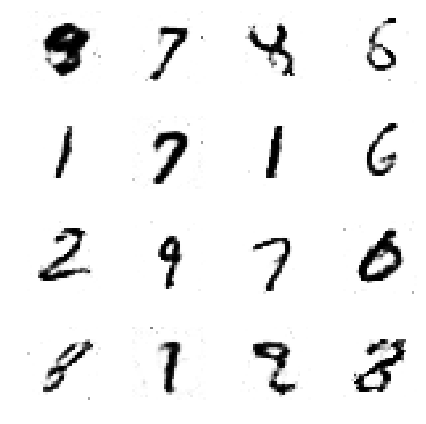

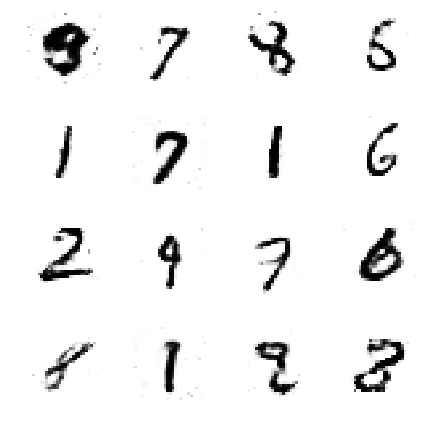

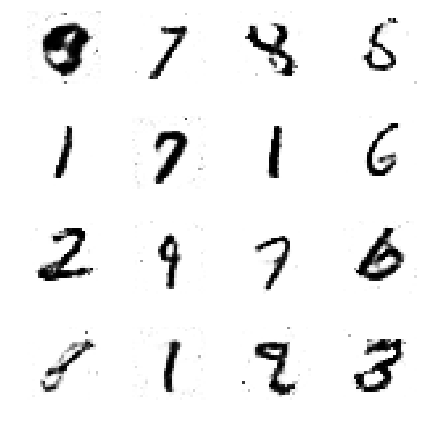

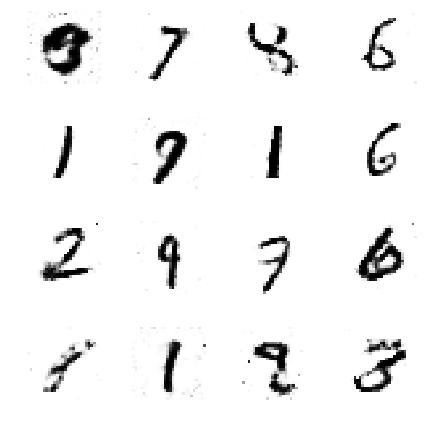

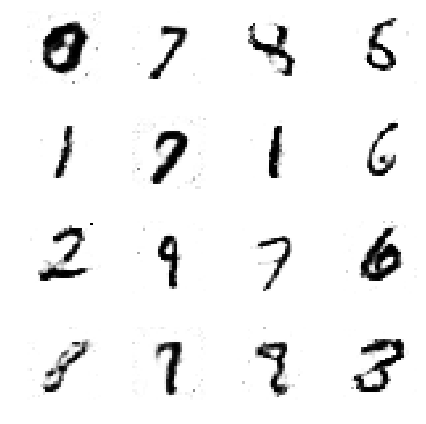

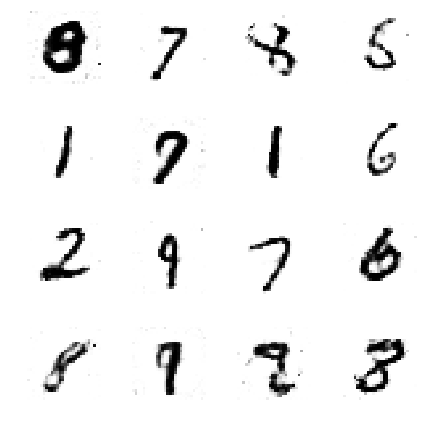

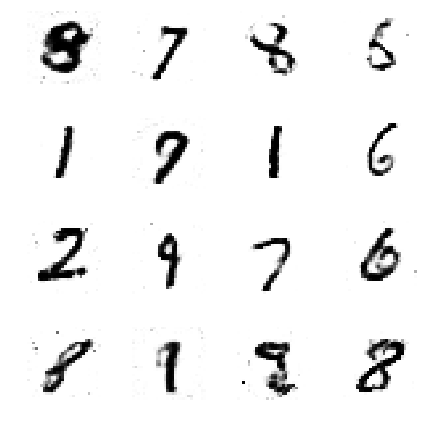

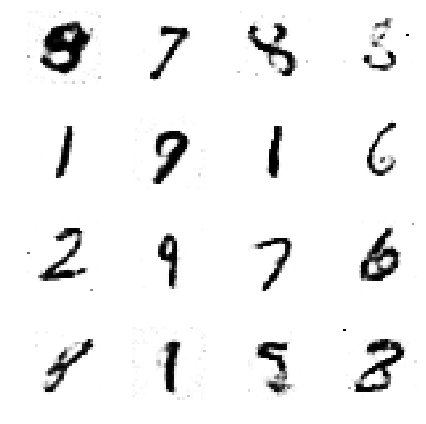

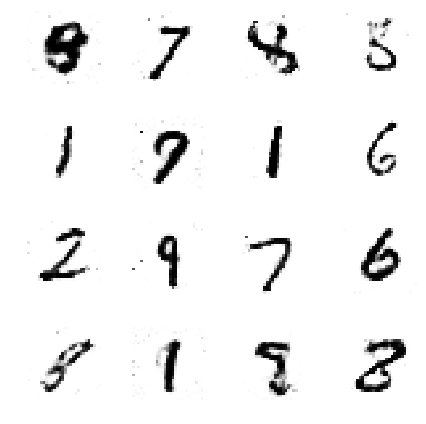

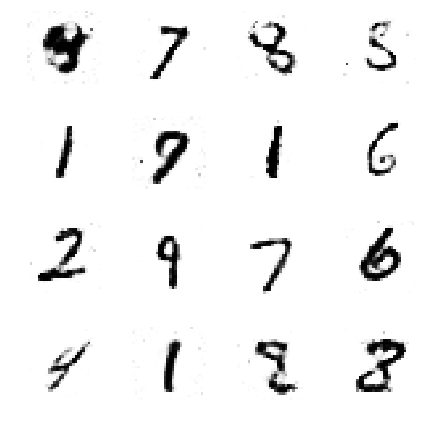

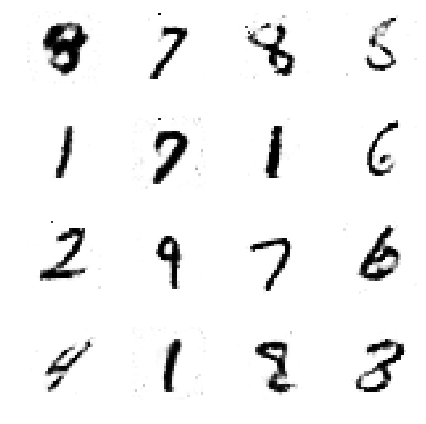

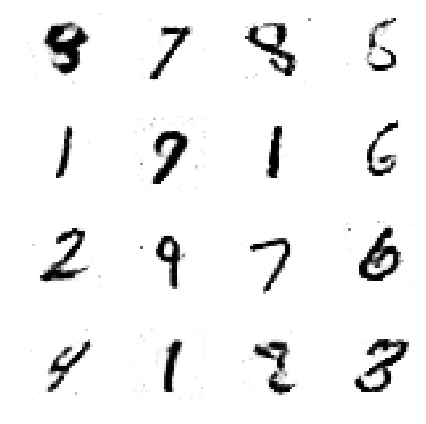

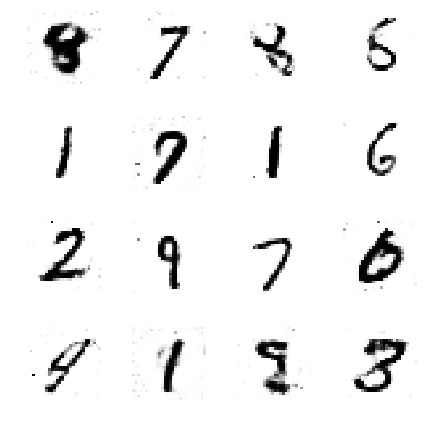

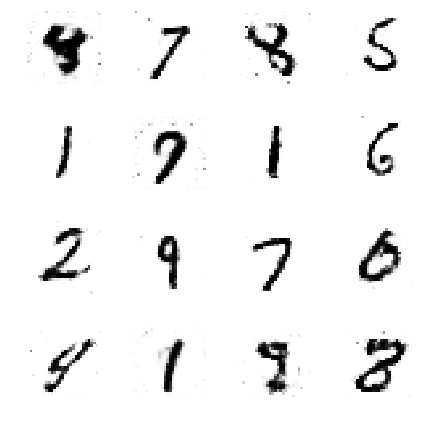

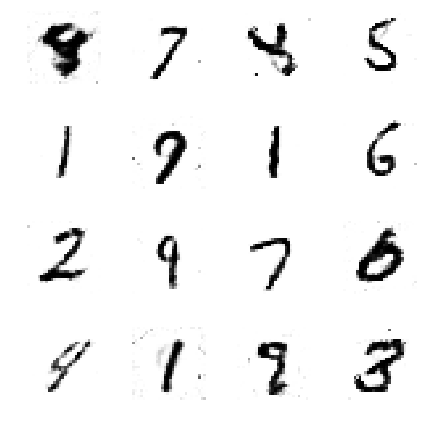

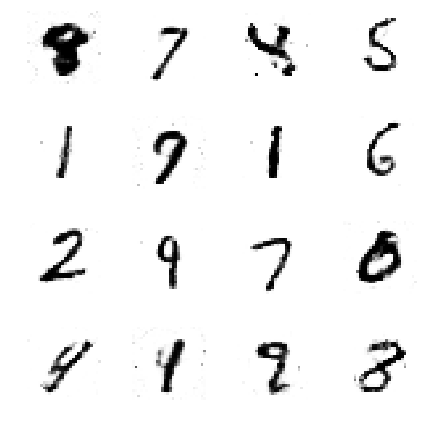

In [101]:
train(200, 100)

---

한 순간 집중의 끈을 놓으니 이런 참사가 발생했네요.. 반성하고 앞으로는 코드 짤 때 정신 똑띠 차려야겠습니다.

minibatch discrimination 기법도 써볼까 했는데, keras에서는 지원이 되지 않는 기능이었습니다.

무튼간에 문제점을 파악할 수 있어서 다행입니다.

Loss는 aws서버에서 로컬로 옮기던 중 손실이 생겼습니다 ㅠㅠ

일단 Keras version의 GAN의 결과는 아래와 같습니다.

### 1th EPOCH

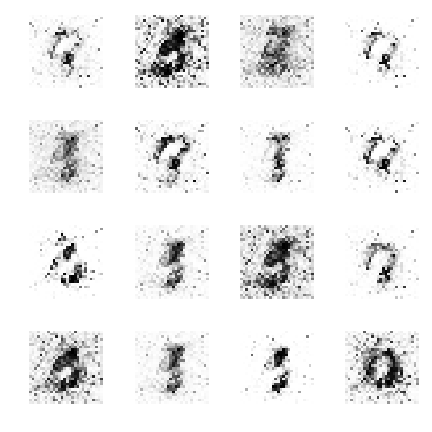

In [16]:
from PIL import Image
Image.open("./result/gan_generated_image_epoch_1.png")

### 10th EPOCH

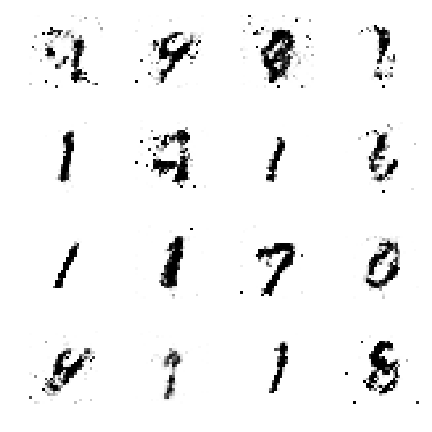

In [17]:
Image.open("./result/gan_generated_image_epoch_10.png")

### 20th EPOCH

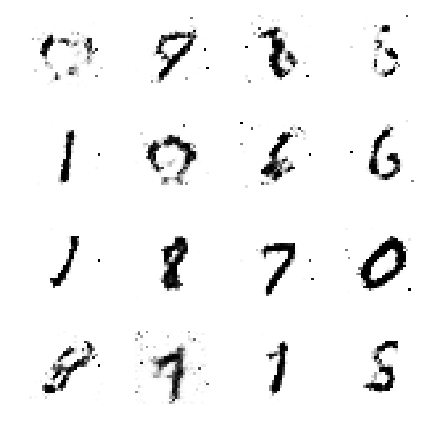

In [18]:
Image.open("./result/gan_generated_image_epoch_20.png")

### 30th EPOCH

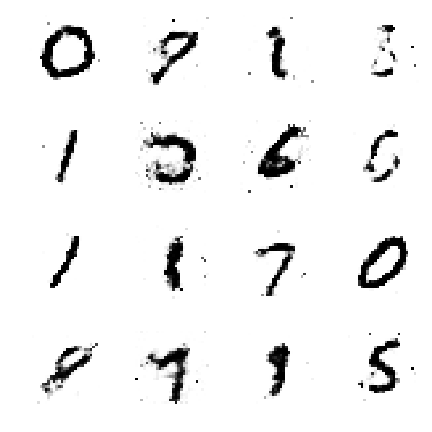

In [19]:
Image.open("./result/gan_generated_image_epoch_30.png")

### 50th EPOCH

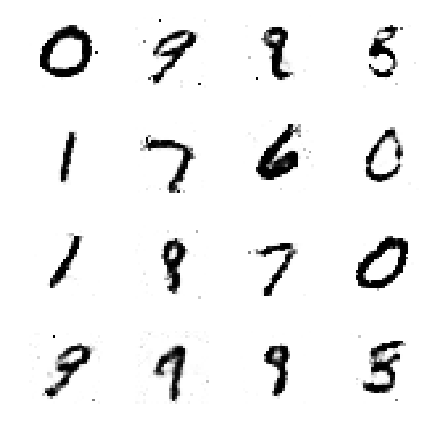

In [20]:
Image.open("./result/gan_generated_image_epoch_50.png")

### 100th EPOCH

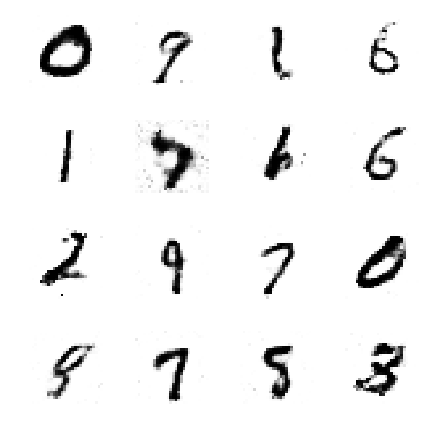

In [21]:
Image.open("./result/gan_generated_image_epoch_100.png")

### 150th EPOCH

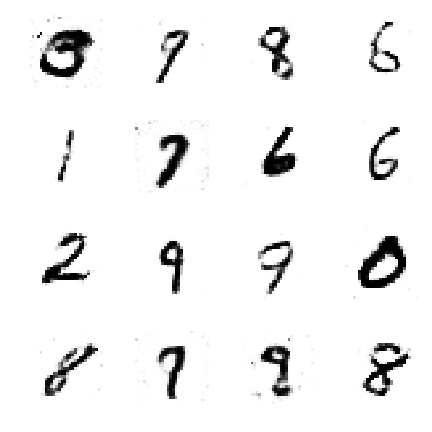

In [22]:
Image.open("./result/gan_generated_image_epoch_150.png")

### 200th EPOCH

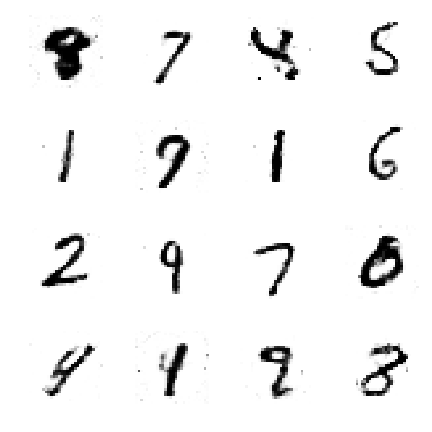

In [23]:
Image.open("./result/gan_generated_image_epoch_200.png")

조금 어설픈 결과물도 있지만 대체로 숫자 비슷하게 나오긴 합니다. 

지난 결과물처럼 하나의 숫자만 나오는 것도 아니구요.

이쯤에서 만족하고,,, Conditional GAN과 DC GAN으로 넘어가려고 합니다.

이상입니다.